In [ ]:
# ============================================
# 0: Installing Required Libraries
# ============================================

!pip install ta yfinance statsmodels lightgbm shap tensorflow-addons pingouin scikeras keras-tuner fred requests

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.4 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=b16975ef39cbdb81880ccd8d9a9f4f112275baf4bc518771fc268f28b08ef572
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
  Created wheel for fred: filename=fred-3.1-py3-none-any.whl size=3897 sha256=c92c0f8f24fa85daa3e2c1263cfc1b30ee3aabf9d0b2570691fb5453c0027cc8
  Stored in directory: /root/.cache/pip/wheels/ff/66/4e/52148d2f8680f6fbc96635c13272981a9b058af93bda192e28
Successfully built ta fred
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled ty

In [ ]:
# ============================================
# 1: Importing Libraries
# ============================================

# Core Libraries
import os
import numpy as np
import pandas as pd
import random
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and Data Analysis
from scipy import stats
from scipy.stats import norm, skew, kurtosis
import statsmodels.api as sm

# Financial Data and Technical Analysis
import yfinance as yf
import ta

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)

# Gradient Boosting Models
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation


# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU
from scikeras.wrappers import KerasClassifier
from keras_tuner import RandomSearch
import shap


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# ===============================================
# 1.1: Set Global Random Seed for Reproducibility
# ===============================================

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Print seed confirmation
print(f"Global random seed set to {SEED}")

Global random seed set to 42


In [ ]:
# ============================================
# 2: Extracting Data
# ============================================

# Fetch ICLN Price and Volume Data from Yahoo Finance
icln = yf.Ticker("ICLN")
icln_data = icln.history(start="2008-06-24", end="2024-11-01", auto_adjust=False, actions=False)[['Open', 'High', 'Low', 'Close', 'Volume']]
icln_data.index = icln_data.index.tz_localize(None)

# Add Technical Indicators to ICLN Data
icln_data['SMA_5'] = icln_data['Close'].rolling(window=5).mean()
icln_data['EMA_12'] = icln_data['Close'].ewm(span=12, adjust=False).mean()
icln_data['EMA_26'] = icln_data['Close'].ewm(span=26, adjust=False).mean()
icln_data['EMA_50'] = icln_data['Close'].ewm(span=50, adjust=False).mean()
icln_data['MACD'] = icln_data['EMA_12'] - icln_data['EMA_26']
icln_data['Bollinger_Upper'] = icln_data['Close'].rolling(window=20).mean() + (icln_data['Close'].rolling(window=20).std() * 2)
icln_data['Bollinger_Lower'] = icln_data['Close'].rolling(window=20).mean() - (icln_data['Close'].rolling(window=20).std() * 2)
icln_data['CCI_14'] = ta.trend.CCIIndicator(high=icln_data['High'], low=icln_data['Low'], close=icln_data['Close'], window=14).cci()
icln_data['ATR_10'] = ta.volatility.AverageTrueRange(high=icln_data['High'], low=icln_data['Low'], close=icln_data['Close'], window=10).average_true_range()
icln_data['ADX_5'] = ta.trend.ADXIndicator(high=icln_data['High'], low=icln_data['Low'], close=icln_data['Close'], window=5).adx()
icln_data['ADX_14'] = ta.trend.ADXIndicator(high=icln_data['High'], low=icln_data['Low'], close=icln_data['Close'], window=14).adx()
icln_data['RSI_5'] = ta.momentum.RSIIndicator(close=icln_data['Close'], window=5).rsi()
icln_data['RSI_14'] = ta.momentum.RSIIndicator(close=icln_data['Close'], window=14).rsi()
icln_data['Momentum_1'] = icln_data['Close'].diff(1)

# Fetch additional data (macroeconomic indicators and futures)
def fetch_data(ticker, column_name, icln_dates):
    try:
        data = yf.Ticker(ticker).history(start=icln_dates[0], end="2024-11-01")['Close']
        data = data.rename(column_name)
        data.index = data.index.tz_localize(None)
        data = data.reindex(icln_dates).ffill()
        return data
    except Exception as e:
        print(f"Error fetching data for {column_name} ({ticker}): {e}")
        return pd.Series(index=icln_dates, name=column_name)

icln_dates = icln_data.index
vix = fetch_data("^VIX", "VIX", icln_dates)
sp500 = fetch_data("^GSPC", "S&P500", icln_dates)
gold = fetch_data("GC=F", "Gold_Prices", icln_dates)
us10yr = fetch_data("^TNX", "Interest_Rates", icln_dates)
oil = fetch_data("CL=F", "Oil_Prices", icln_dates)
copper = fetch_data("HG=F", "Copper_Futures", icln_dates)
natural_gas = fetch_data("NG=F", "Natural_Gas_Prices", icln_dates)

# Display available dates for each dataset
available_dates = {
    "ICLN": (icln_data.index.min(), icln_data.index.max()),
    "VIX": (vix.dropna().index.min(), vix.dropna().index.max()),
    "S&P500": (sp500.dropna().index.min(), sp500.dropna().index.max()),
    "Gold_Prices": (gold.dropna().index.min(), gold.dropna().index.max()),
    "Interest_Rates": (us10yr.dropna().index.min(), us10yr.dropna().index.max()),
    "Oil_Prices": (oil.dropna().index.min(), oil.dropna().index.max()),
    "Copper_Futures": (copper.dropna().index.min(), copper.dropna().index.max()),
    "Natural_Gas_Prices": (natural_gas.dropna().index.min(), natural_gas.dropna().index.max())
}

# Print date range availability
for key, (start, end) in available_dates.items():
    print(f"{key}: Available from {start} to {end}")

# Create 1-week (5 trading days) and 1-month (21 trading days) lags for each macroeconomic variable
macro_data = pd.DataFrame({
    'VIX': vix,
    'S&P500': sp500,
    'Gold_Prices': gold,
    'Interest_Rates': us10yr,
    'Oil_Prices': oil,
    'Copper_Futures': copper,
    'Natural_Gas_Prices': natural_gas
})

for column in macro_data.columns:
    macro_data[f'{column}_lag_1w'] = macro_data[column].shift(5)
    macro_data[f'{column}_lag_1m'] = macro_data[column].shift(21)

# Combine ICLN data with macroeconomic indicators and their lags
data = icln_data.join(macro_data, how='outer')

# Daily log returns for Buy and Hold strategy (ICLN)
data['ICLN_Return'] = np.log(data['Close'] / data['Close'].shift(1))

# Binary target variable for classification
data['Target'] = (data['ICLN_Return'] > 0).astype(int)

# Count the number of missing values in each column
missing_data_counts = data.isnull().sum()

print("Number of missing data points per column:\n", missing_data_counts)

total_missing_data = data.isnull().sum().sum()
print(f"Total number of missing data points: {total_missing_data}")

# Drop rows with missing values
data.dropna(inplace=True)

# Save dataset
data.to_excel("thesis_code.xlsx", index=True)

# Preview and summary
print("Data preview:\n", data.head())
print("Data summary:\n", data.info())
data.describe()

ICLN: Available from 2008-06-25 00:00:00 to 2024-10-31 00:00:00
VIX: Available from 2008-06-25 00:00:00 to 2024-10-31 00:00:00
S&P500: Available from 2008-06-25 00:00:00 to 2024-10-31 00:00:00
Gold_Prices: Available from 2008-06-25 00:00:00 to 2024-10-31 00:00:00
Interest_Rates: Available from 2008-06-25 00:00:00 to 2024-10-31 00:00:00
Oil_Prices: Available from 2008-06-25 00:00:00 to 2024-10-31 00:00:00
Copper_Futures: Available from 2008-06-25 00:00:00 to 2024-10-31 00:00:00
Natural_Gas_Prices: Available from 2008-06-25 00:00:00 to 2024-10-31 00:00:00
Number of missing data points per column:
 Open                          0
High                          0
Low                           0
Close                         0
Volume                        0
SMA_5                         4
EMA_12                        0
EMA_26                        0
EMA_50                        0
MACD                          0
Bollinger_Upper              19
Bollinger_Lower              19
CCI_14       

Open         High          Low        Close        Volume  \
count  4096.000000  4096.000000  4096.000000  4096.000000  4.096000e+03   
mean     14.183999    14.307307    13.984990    14.133906  1.299506e+06   
std       6.445289     6.520083     6.266650     6.365307  2.574981e+06   
min       6.230000     6.230000     6.130000     6.170000  1.100000e+03   
25%       9.257500     9.320000     9.180000     9.260000  1.890000e+04   
50%      11.715000    11.755000    11.595000    11.685000  4.985000e+04   
75%      18.549999    18.775001    18.260000    18.520000  1.729025e+06   
max      53.119999    53.119999    50.119999    50.480000  2.513540e+07   

             SMA_5       EMA_12       EMA_26       EMA_50         MACD  ...  \
count  4096.000000  4096.000000  4096.000000  4096.000000  4096.000000  ...   
mean     14.151128    14.181721    14.243967    14.353925    -0.062245  ...   
std       6.399520     6.448772     6.557221     6.739456     0.540996  ...   
min       6.254000     6.387695     6.498279     6.612100    -4.925007  ...   
25%       9.253500     9.253854     9.238637     9.198783    -0.170446  ...   
50%      11.679000    11.627376    11.539159    11.479983    -0.005272  ...   
75%      18.524000    18.585651    18.874139    19.155842     0.130008  ...   
max      49.788000    49.073555    49.475758    50.458064     2.350532  ...   

       Interest_Rates_lag_1w  Interest_Rates_lag_1m  Oil_Prices_lag_1w  \
count            4096.000000            4096.000000        4096.000000   
mean                2.546629               2.546105          71.725720   
std                 0.919046               0.918206          21.603174   
min                 0.499000               0.499000         -37.630001   
25%                 1.867500               1.867500          53.017500   
50%                 2.470000               2.470000          72.259998   
75%                 3.194000               3.194000          88.952497   
max                 4.988000               4.988000         131.039993   

       Oil_Prices_lag_1m  Copper_Futures_lag_1w  Copper_Futures_lag_1m  \
count        4096.000000            4096.000000            4096.000000   
mean           71.987068               3.226632               3.224436   
std            22.014393               0.734601               0.732001   
min           -37.630001               1.247500               1.247500   
25%            53.017500               2.687375               2.687375   
50%            72.445000               3.182500               3.182500   
75%            89.332500               3.764500               3.760750   
max           145.289993               5.119000               5.119000   

       Natural_Gas_Prices_lag_1w  Natural_Gas_Prices_lag_1m  ICLN_Return  \
count                4096.000000                4096.000000  4096.000000   
mean                    3.525772                   3.564611    -0.000312   
std                     1.403874                   1.510680     0.020959   
min                     1.482000                   1.482000    -0.167229   
25%                     2.621000                   2.626750    -0.009431   
50%                     3.109000                   3.129000     0.000000   
75%                     4.109000                   4.132250     0.009832   
max                    10.570000                  13.577000     0.160004   

            Target  
count  4096.000000  
mean      0.486084  
std       0.499867  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000  

[8 rows x 42 columns]

Missing values per feature:
 Close                 0
Volume                0
SMA_5                 0
EMA_12                0
EMA_26                0
EMA_50                0
MACD                  0
Bollinger_Upper       0
Bollinger_Lower       0
CCI_14                0
ATR_10                0
ADX_5                 0
ADX_14                0
RSI_5                 0
RSI_14                0
Momentum_1            0
VIX                   0
S&P500                0
Gold_Prices           0
Interest_Rates        0
Oil_Prices            0
Copper_Futures        0
Natural_Gas_Prices    0
dtype: int64
Close - Skewness: 1.73, Kurtosis: 5.29
Volume - Skewness: 3.16, Kurtosis: 14.51
SMA_5 - Skewness: 1.75, Kurtosis: 5.40
EMA_12 - Skewness: 1.78, Kurtosis: 5.53
EMA_26 - Skewness: 1.84, Kurtosis: 5.86
EMA_50 - Skewness: 1.93, Kurtosis: 6.27
MACD - Skewness: -3.33, Kurtosis: 25.38
Bollinger_Upper - Skewness: 1.89, Kurtosis: 5.72
Bollinger_Lower - Skewness: 1.89, Kurtosis: 6.59
CCI_14 - Skewness: -0.06, Kur

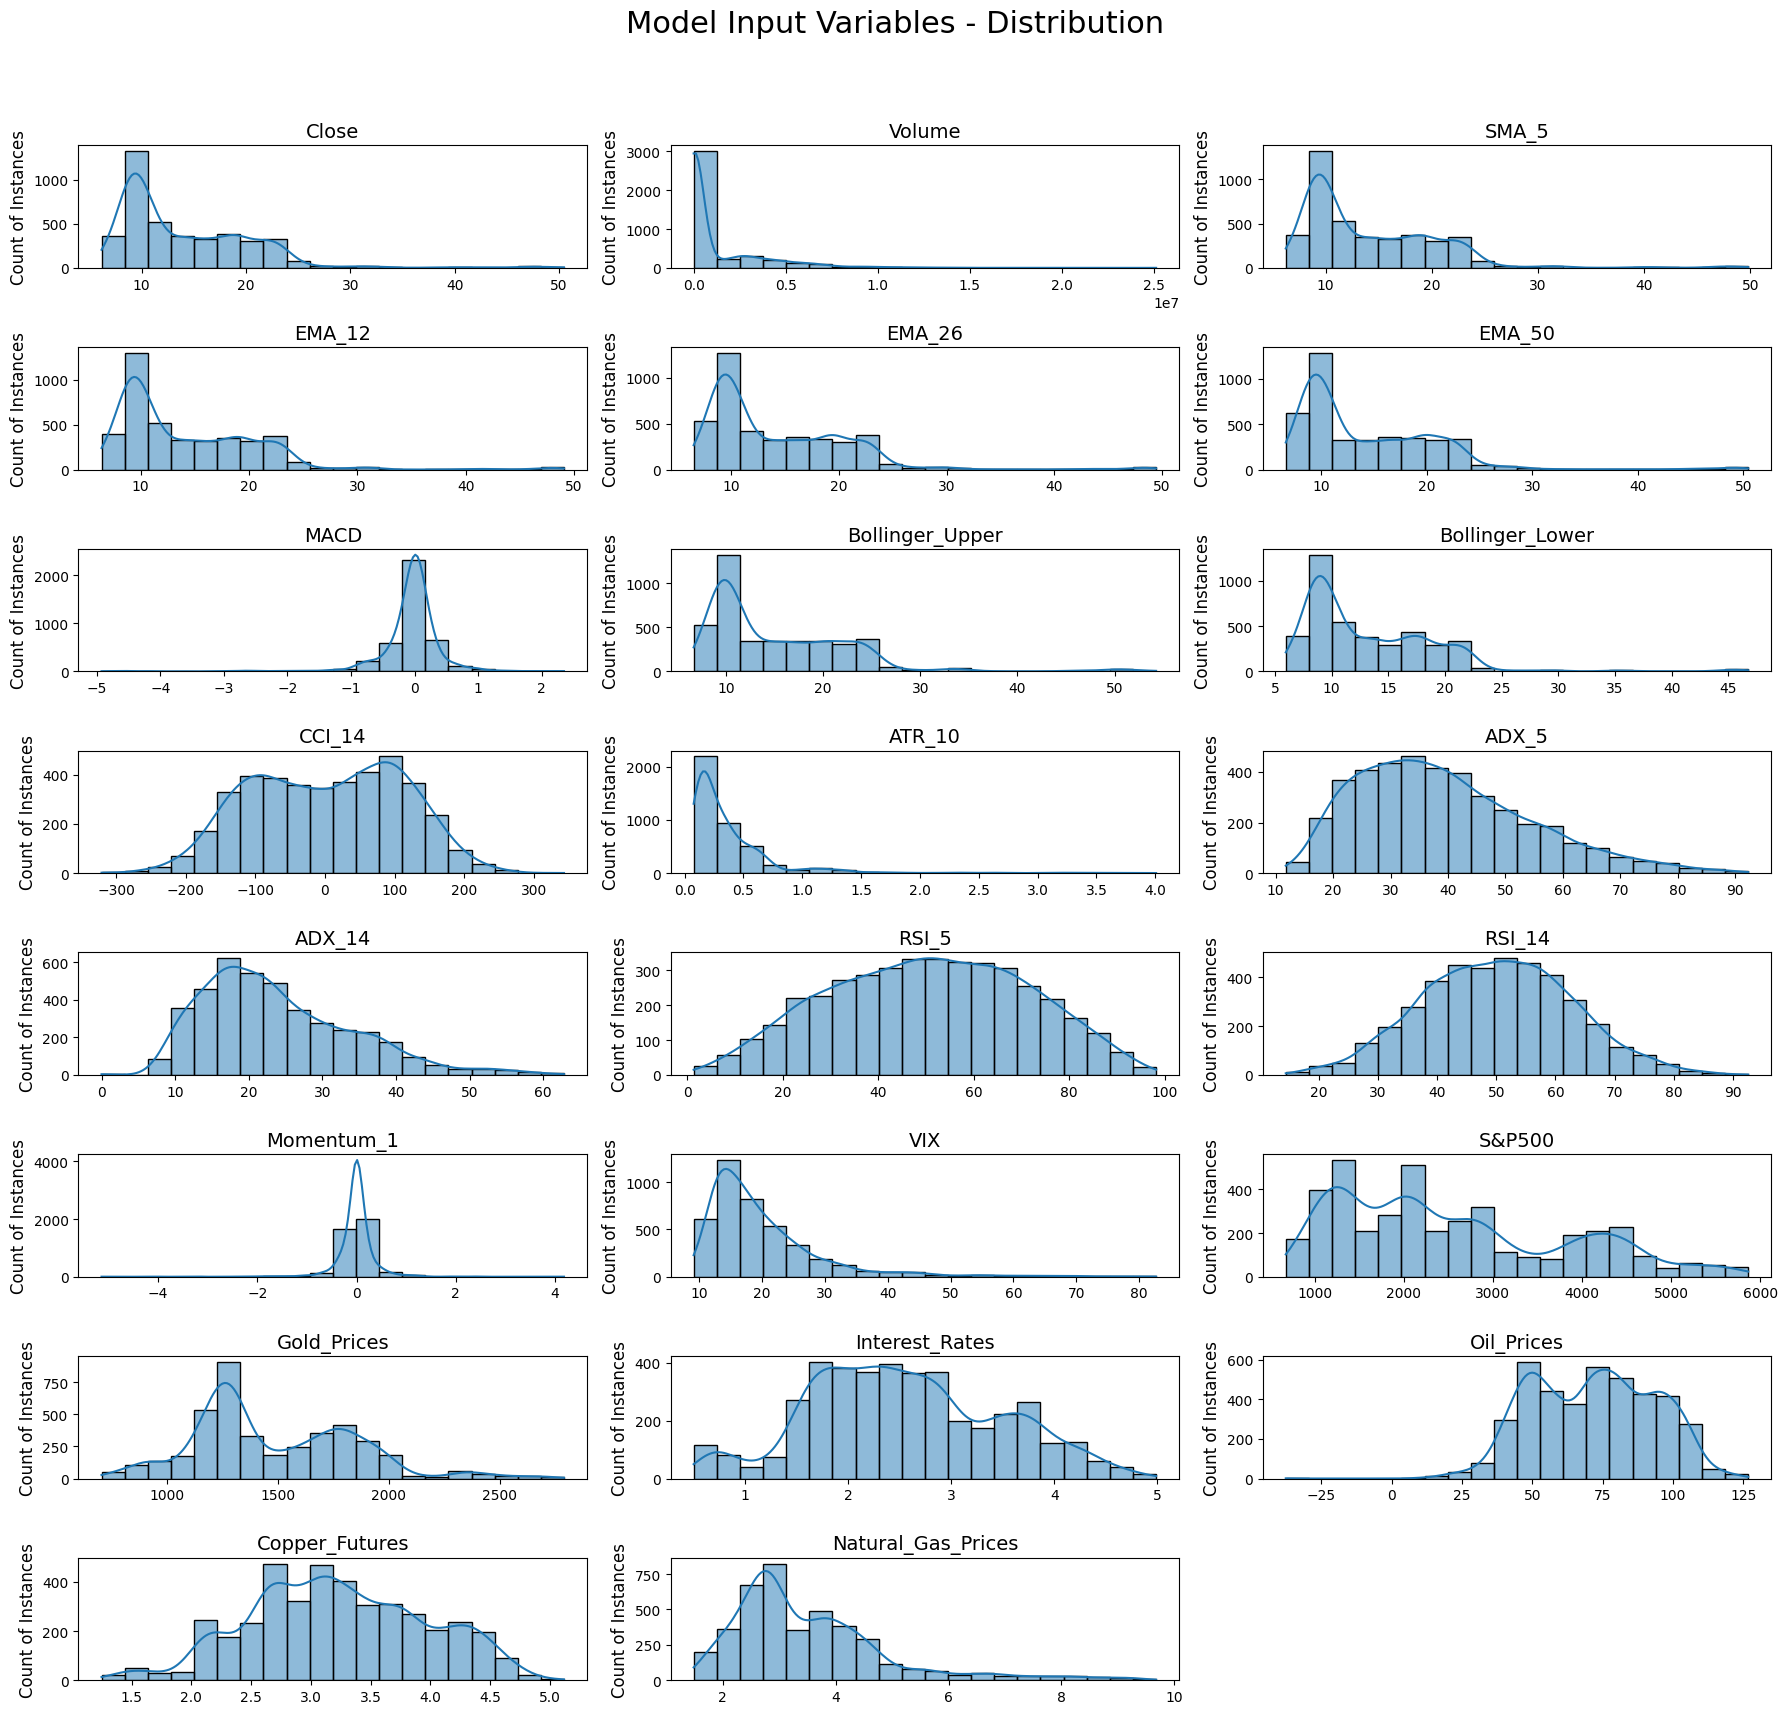

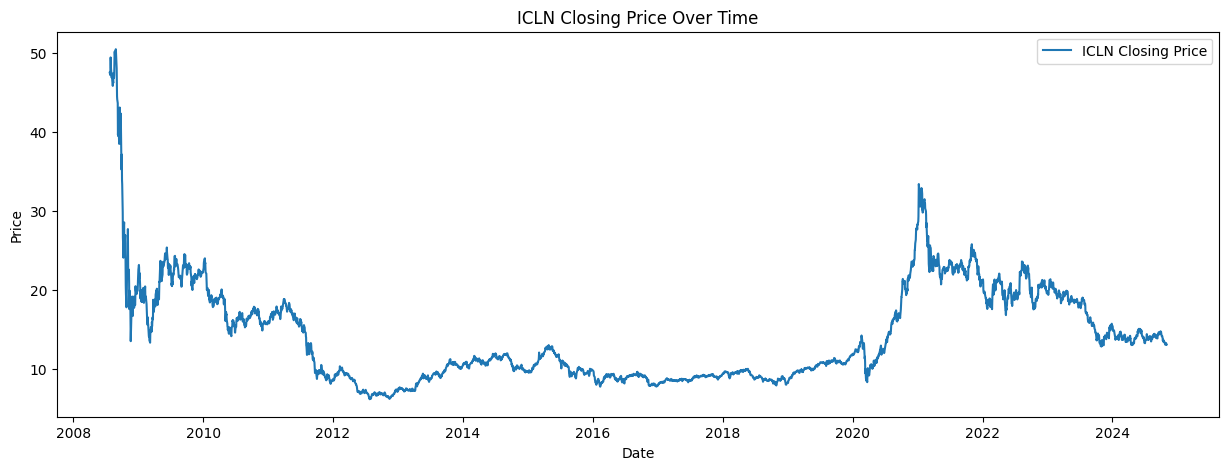

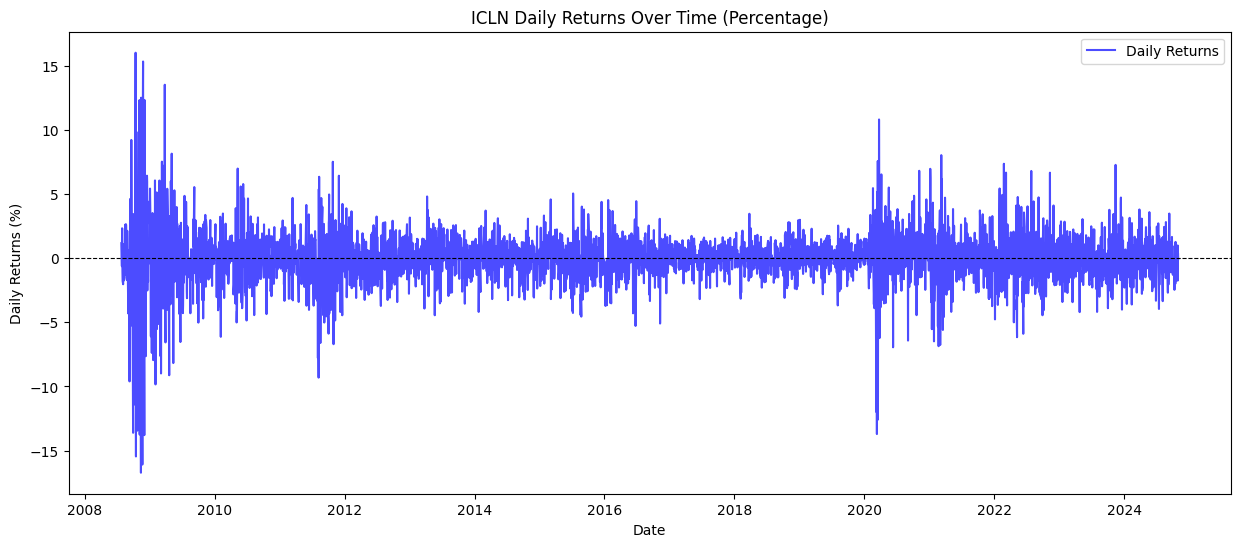

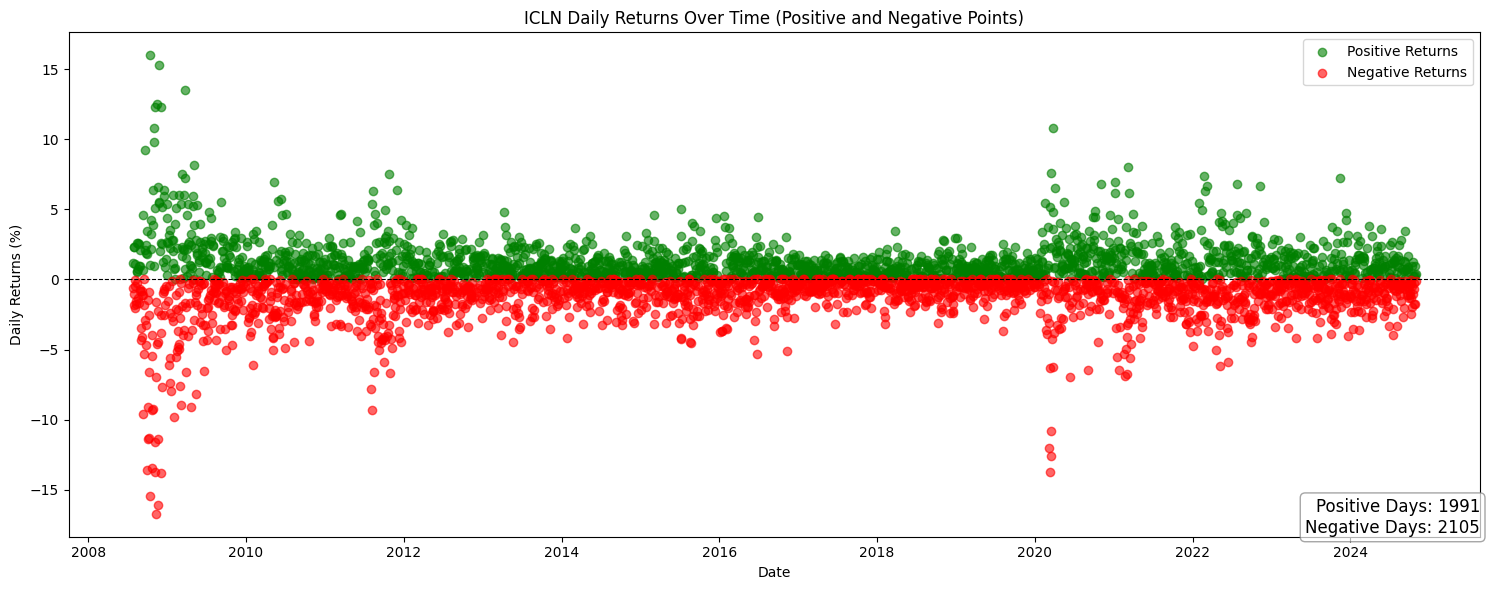

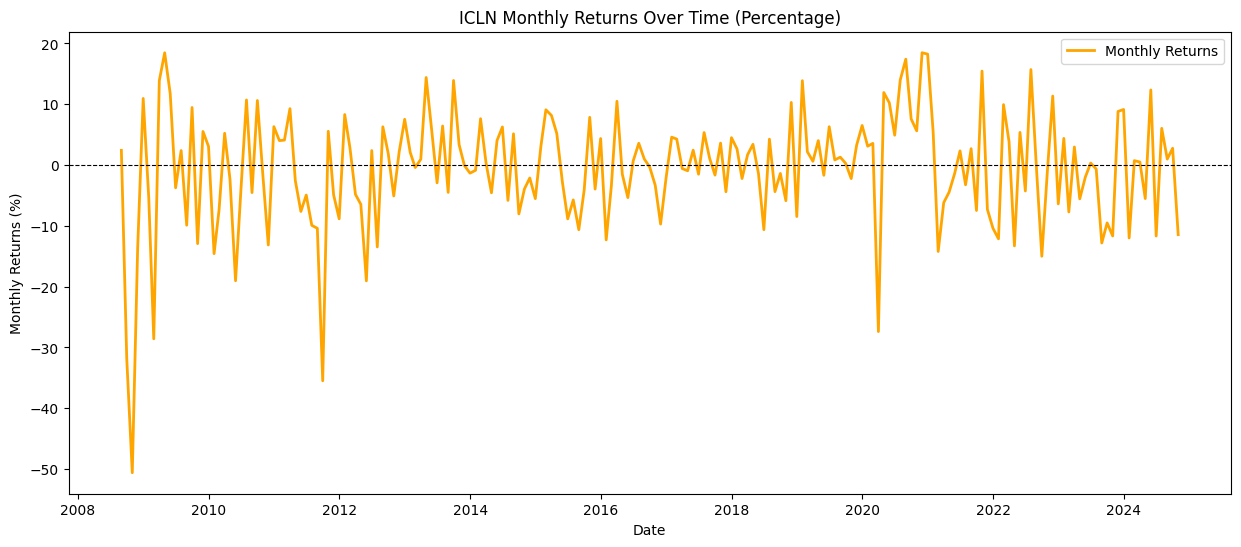

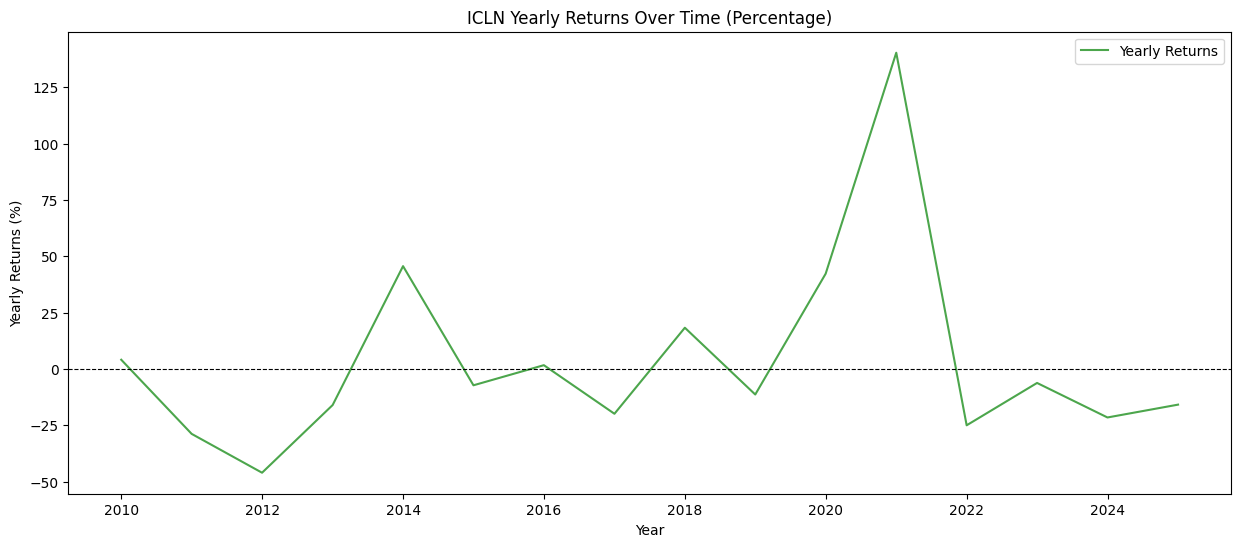

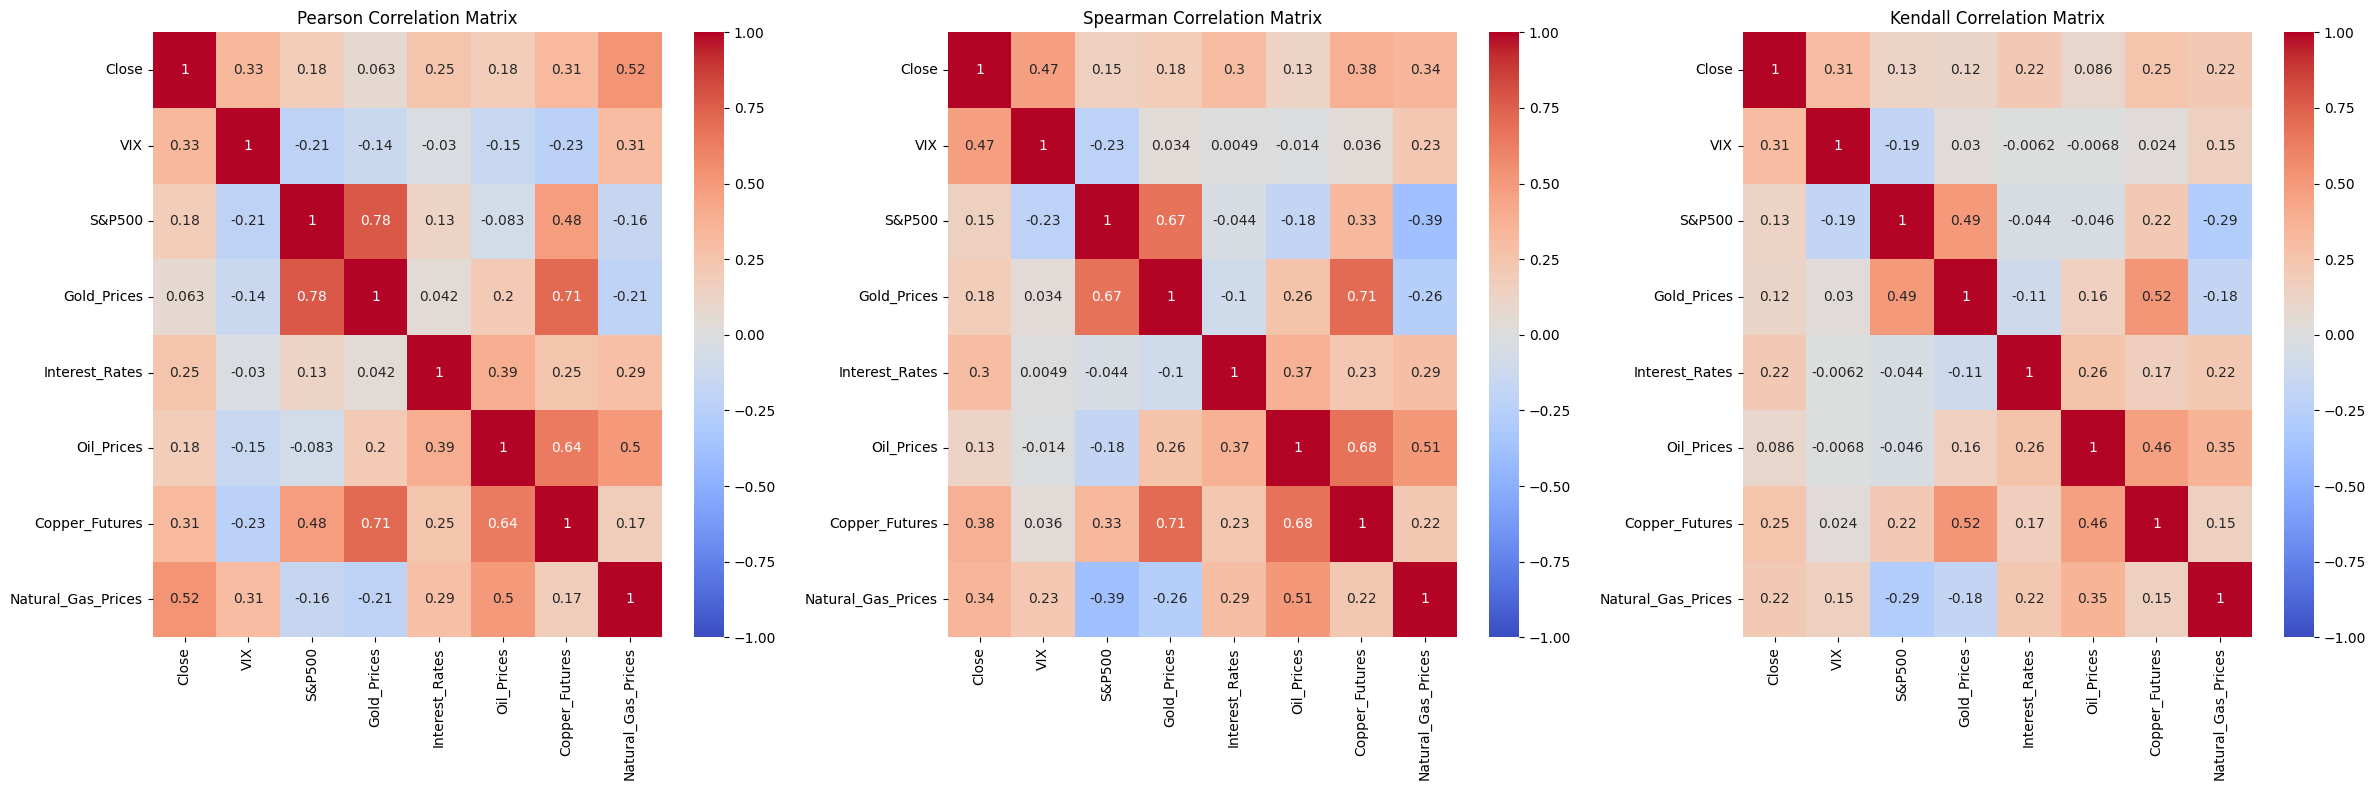

In [ ]:
# ============================================
# 3: EDA
# ============================================

# Features to visualize
features_to_plot = [
    # ICLN Data and Technical Indicators
    'Close', 'Volume',
    'SMA_5', 'EMA_12', 'EMA_26', 'EMA_50', 'MACD',
    'Bollinger_Upper', 'Bollinger_Lower', 'CCI_14',
    'ATR_10', 'ADX_5', 'ADX_14', 'RSI_5', 'RSI_14', 'Momentum_1',

    # Macroeconomic Indicators
    'VIX', 'S&P500', 'Gold_Prices', 'Interest_Rates',
    'Oil_Prices', 'Copper_Futures', 'Natural_Gas_Prices']

missing_values = data[features_to_plot].isna().sum()
print("Missing values per feature:\n", missing_values)

# Set up the subplots grid
n_features = len(features_to_plot)
n_cols = 3  # Number of columns
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 18))
fig.suptitle('Model Input Variables - Distribution', fontsize=22)

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot histograms for each feature
for idx, feature in enumerate(features_to_plot):
    sns.histplot(data[feature].dropna(), ax=axes[idx], kde=True, bins=20)
    axes[idx].set_title(feature, fontsize=14)
    axes[idx].set_ylabel('Count of Instances', fontsize=12)
    axes[idx].set_xlabel('')

for feature in features_to_plot:
    print(f"{feature} - Skewness: {skew(data[feature].dropna()):.2f}, Kurtosis: {kurtosis(data[feature].dropna()):.2f}")

# Remove any empty subplots if there are more grid cells than features
for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(data.index, data['Close'], label='ICLN Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ICLN Closing Price Over Time')
plt.legend()
plt.show()

# Calculate Daily Returns
daily_returns = data['ICLN_Return']

# Calculate Monthly Returns
monthly_prices = data['Close'].resample('ME').last()
monthly_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

# Calculate Yearly Returns
yearly_prices = data['Close'].resample('YE').last()  # Get the last closing price of each year
yearly_returns = yearly_prices.pct_change()  # Calculate yearly returns as percentage change

# Plot Daily Returns as Percentage
plt.figure(figsize=(15, 6))
plt.plot(daily_returns.index, daily_returns * 100, label='Daily Returns', color='blue', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.title('ICLN Daily Returns Over Time (Percentage)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a line at 0 for reference
plt.legend()
plt.show()

# Splitting daily returns into positive and negative
positive_days = data[data['ICLN_Return'] > 0]
negative_days = data[data['ICLN_Return'] <= 0]

# Plotting only the positive and negative return markers
plt.figure(figsize=(15, 6))
plt.scatter(positive_days.index, positive_days['ICLN_Return'] * 100, color='green', label='Positive Returns', alpha=0.6)
plt.scatter(negative_days.index, negative_days['ICLN_Return'] * 100, color='red', label='Negative Returns', alpha=0.6)

# Adding a reference line at 0
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Adding titles and labels
plt.title('ICLN Daily Returns Over Time (Positive and Negative Points)')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.legend()

# Annotating the counts of positive and negative points at the bottom right
plt.annotate(
    f"Positive Days: {len(positive_days)}\nNegative Days: {len(negative_days)}",
    xy=(1, 0), xycoords='axes fraction', fontsize=12, color='black',
    horizontalalignment='right', verticalalignment='bottom',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.7)
)

# Show plot
plt.tight_layout()
plt.show()

# Plot Monthly Returns as Percentage
plt.figure(figsize=(15, 6))
plt.plot(monthly_returns.index, monthly_returns * 100, label='Monthly Returns', color='orange', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Monthly Returns (%)')
plt.title('ICLN Monthly Returns Over Time (Percentage)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a line at 0 for reference
plt.legend()
plt.show()

# Plot Yearly Returns as Percentage
plt.figure(figsize=(15, 6))
plt.plot(yearly_returns.index, yearly_returns * 100, label='Yearly Returns', color='green', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Yearly Returns (%)')
plt.title('ICLN Yearly Returns Over Time (Percentage)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a line at 0 for reference
plt.legend()
plt.show()

# Select relevant columns for correlation analysis
columns_of_interest = ['Close', 'VIX', 'S&P500', 'Gold_Prices', 'Interest_Rates',
    'Oil_Prices', 'Copper_Futures', 'Natural_Gas_Prices']

# Calculate correlation matrices
pearson_corr = data[columns_of_interest].corr(method='pearson')
spearman_corr = data[columns_of_interest].corr(method='spearman')
kendall_corr = data[columns_of_interest].corr(method='kendall')

# Plot all three correlation matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Pearson Correlation Matrix
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Pearson Correlation Matrix")

# Spearman Correlation Matrix
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Spearman Correlation Matrix")

# Kendall Correlation Matrix
sns.heatmap(kendall_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[2])
axes[2].set_title("Kendall Correlation Matrix")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


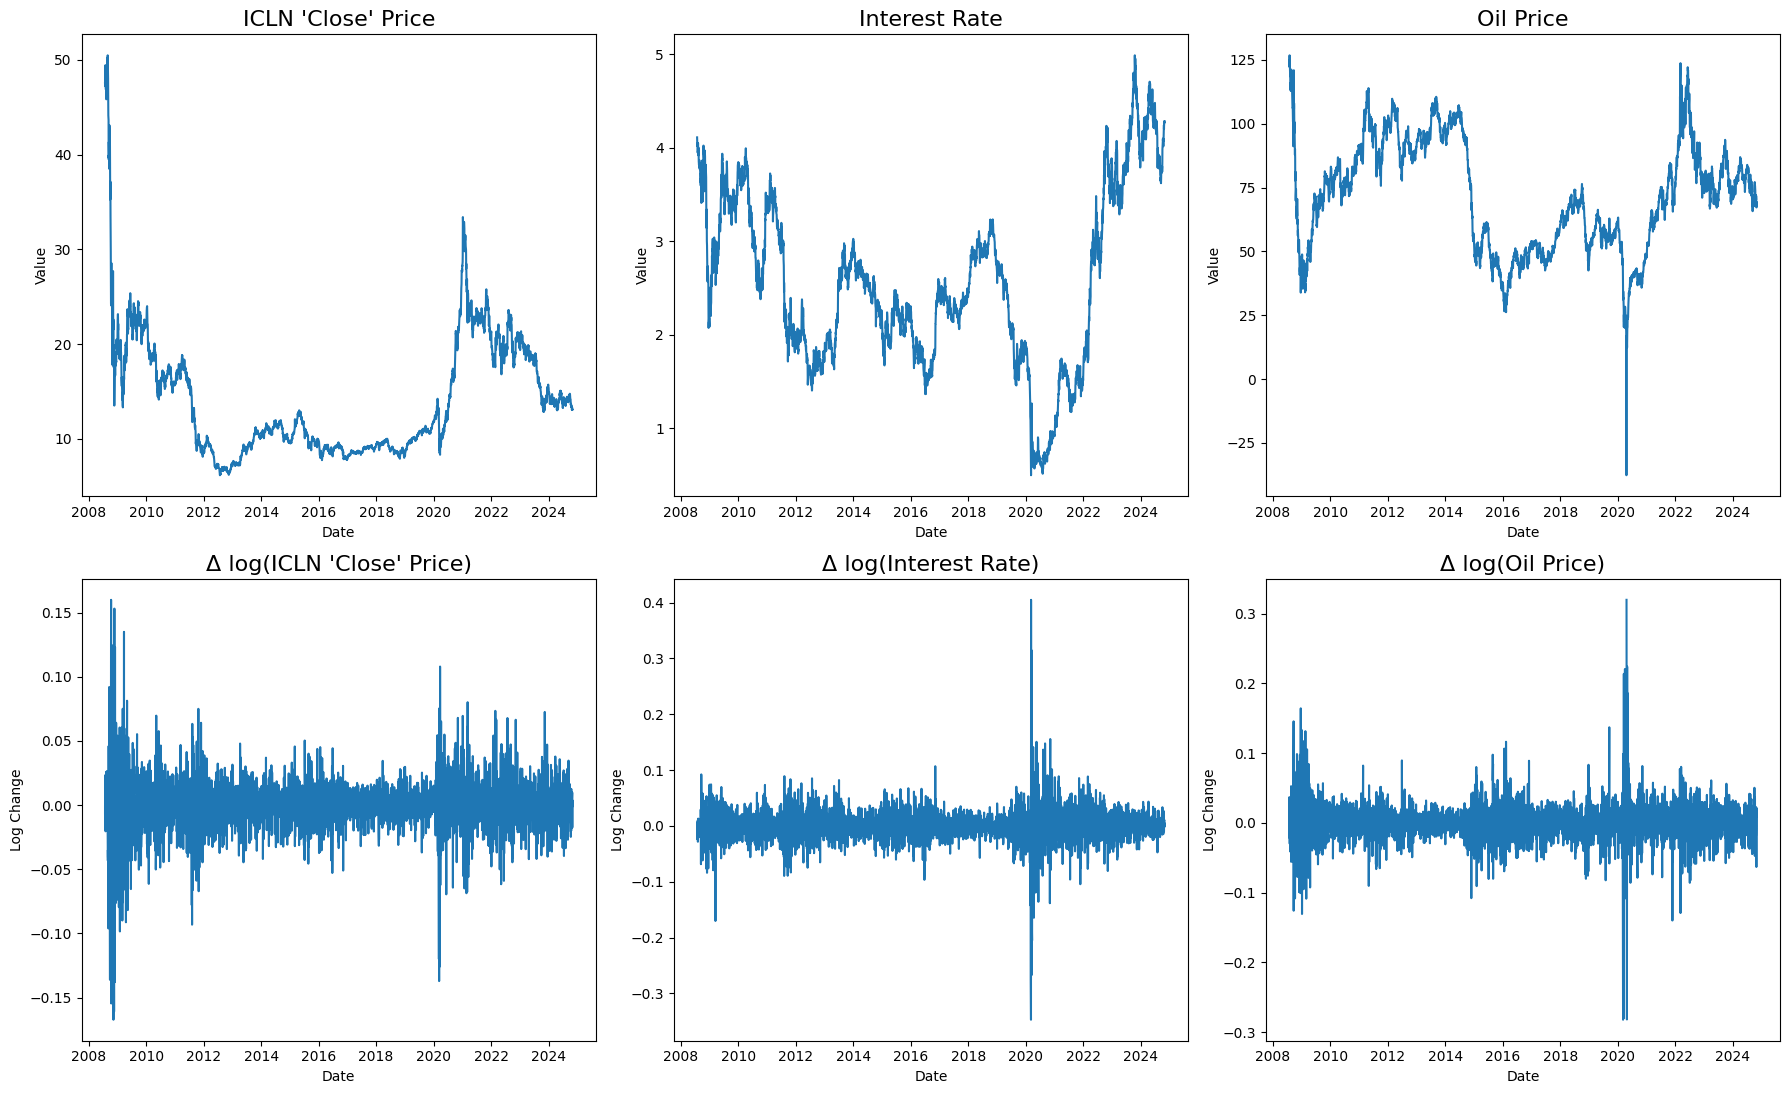

In [ ]:
# ============================================
# 3.1: EDA
# ============================================

# Ensure the features exist in the dataset
features = {
    "ICLN 'Close' Price": 'Close',
    'Interest Rate': 'Interest_Rates',
    'Oil Price': 'Oil_Prices'
}

# Prepare data for transformations
log_transforms = {}
for label, column in features.items():
    log_transforms[label] = np.log(data[column].dropna())
    log_transforms[f"diff_{label}"] = log_transforms[label].diff()

# Create subplots for time-series and log-transformed data
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot the original time series (Top Row)
for i, (label, column) in enumerate(features.items()):
    axes[0, i].plot(data.index, data[column], label=label)
    axes[0, i].set_title(label, fontsize=16)
    axes[0, i].set_ylabel('Value')
    axes[0, i].set_xlabel('Date')

# Plot the log-transformed differences (Bottom Row)
for i, (label, column) in enumerate(features.items()):
    axes[1, i].plot(log_transforms[f"diff_{label}"], label=f"Δ log({label})")
    axes[1, i].set_title(f"Δ log({label})", fontsize=16)
    axes[1, i].set_ylabel('Log Change')
    axes[1, i].set_xlabel('Date')

# Layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


In [ ]:
# ============================================
# 4: Split and Scale Dataset
# ============================================

# Verify the full range of the data
print(f"Full Data Period: {data.index.min()} to {data.index.max()}")

# Split the dataset into training, validation, and test sets
total_size = len(data)
test_size = int(total_size * 0.2)
train_size = int(total_size * 0.65)
validation_size = total_size - train_size - test_size

# Train, validation, and test sets
train_set = data.iloc[:train_size].copy()
validation_set = data.iloc[train_size:train_size + validation_size].copy()
test_set = data.iloc[train_size + validation_size:].copy()

# Validate splits to avoid overlap
assert train_set.index.max() < validation_set.index.min(), "Overlap between training and validation sets!"
assert validation_set.index.max() < test_set.index.min(), "Overlap between validation and test sets!"

# Print split details with periods
print(f"\nTrain Set: {len(train_set)} ({len(train_set) / len(data) * 100:.2f}%)")
print(f"Train Period: {train_set.index.min()} to {train_set.index.max()}")

print(f"\nValidation Set: {len(validation_set)} ({len(validation_set) / len(data) * 100:.2f}%)")
print(f"Validation Period: {validation_set.index.min()} to {validation_set.index.max()}")

print(f"\nTest Set: {len(test_set)} ({len(test_set) / len(data) * 100:.2f}%)")
print(f"Test Period: {test_set.index.min()} to {test_set.index.max()}")

# Features to scale for neural networks
features_to_scale = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5', 'EMA_12', 'EMA_26', 'EMA_50', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower',
    'CCI_14', 'ATR_10', 'ADX_5', 'ADX_14', 'RSI_5', 'RSI_14', 'Momentum_1',
    'VIX', 'S&P500', 'Gold_Prices', 'Interest_Rates', 'Oil_Prices',
    'Copper_Futures', 'Natural_Gas_Prices',
    'VIX_lag_1w', 'VIX_lag_1m', 'S&P500_lag_1w', 'S&P500_lag_1m',
    'Gold_Prices_lag_1w', 'Gold_Prices_lag_1m', 'Interest_Rates_lag_1w', 'Interest_Rates_lag_1m',
    'Oil_Prices_lag_1w', 'Oil_Prices_lag_1m', 'Copper_Futures_lag_1w', 'Copper_Futures_lag_1m',
    'Natural_Gas_Prices_lag_1w', 'Natural_Gas_Prices_lag_1m'
]

# Initialize MinMaxScaler for neural networks
min_max_scaler = MinMaxScaler()

# Fit the scaler only on the training set
train_scaled = train_set.copy()
validation_scaled = validation_set.copy()
test_scaled = test_set.copy()

train_scaled[features_to_scale] = min_max_scaler.fit_transform(train_set[features_to_scale])
validation_scaled[features_to_scale] = min_max_scaler.transform(validation_set[features_to_scale])
test_scaled[features_to_scale] = min_max_scaler.transform(test_set[features_to_scale])

# Verify that no NaN values are introduced after scaling
assert not train_scaled[features_to_scale].isnull().values.any(), "NaN values found in train set!"
assert not validation_scaled[features_to_scale].isnull().values.any(), "NaN values found in validation set!"
assert not test_scaled[features_to_scale].isnull().values.any(), "NaN values found in test set!"

# Display a preview of each scaled dataset
print("\nScaled Training Set Preview:\n", train_scaled[features_to_scale].head())
print("\nScaled Validation Set Preview:\n", validation_scaled[features_to_scale].head())
print("\nScaled Test Set Preview:\n", test_scaled[features_to_scale].head())

# Maintain raw datasets for models that don't require scaling
train_raw = train_set.copy()
validation_raw = validation_set.copy()
test_raw = test_set.copy()


Full Data Period: 2008-07-25 00:00:00 to 2024-10-31 00:00:00

Train Set: 2662 (64.99%)
Train Period: 2008-07-25 00:00:00 to 2019-02-21 00:00:00

Validation Set: 615 (15.01%)
Validation Period: 2019-02-22 00:00:00 to 2021-07-30 00:00:00

Test Set: 819 (20.00%)
Test Period: 2021-08-02 00:00:00 to 2024-10-31 00:00:00

Scaled Training Set Preview:
                 Open      High       Low     Close    Volume     SMA_5  \
Date                                                                     
2008-07-25  0.875240  0.880358  0.924756  0.932972  0.001286  0.972527   
2008-07-28  0.864363  0.880785  0.923619  0.926202  0.014229  0.959112   
2008-07-29  0.881425  0.901898  0.939532  0.951253  0.014551  0.955070   
2008-07-30  0.914694  0.922585  0.974767  0.976529  0.002010  0.956356   
2008-07-31  0.921945  0.924931  0.940441  0.965245  0.001688  0.965452   

              EMA_12    EMA_26    EMA_50      MACD  ...  Gold_Prices_lag_1w  \
Date                                                ...

Baseline B&H Strategy Metrics for Test Period:
RoI: -0.4232
Volatility: 0.2811
Sharpe_Ratio: -0.6023
Sortino_Ratio: -1.0286
Calmar_Ratio: -0.2973

D-Ratio and related metrics for Test Period:
D-Ratio for Full Period: 1.0000
D-Ratio for First Period: 1.0000
D-Ratio for Second Period: 1.0000


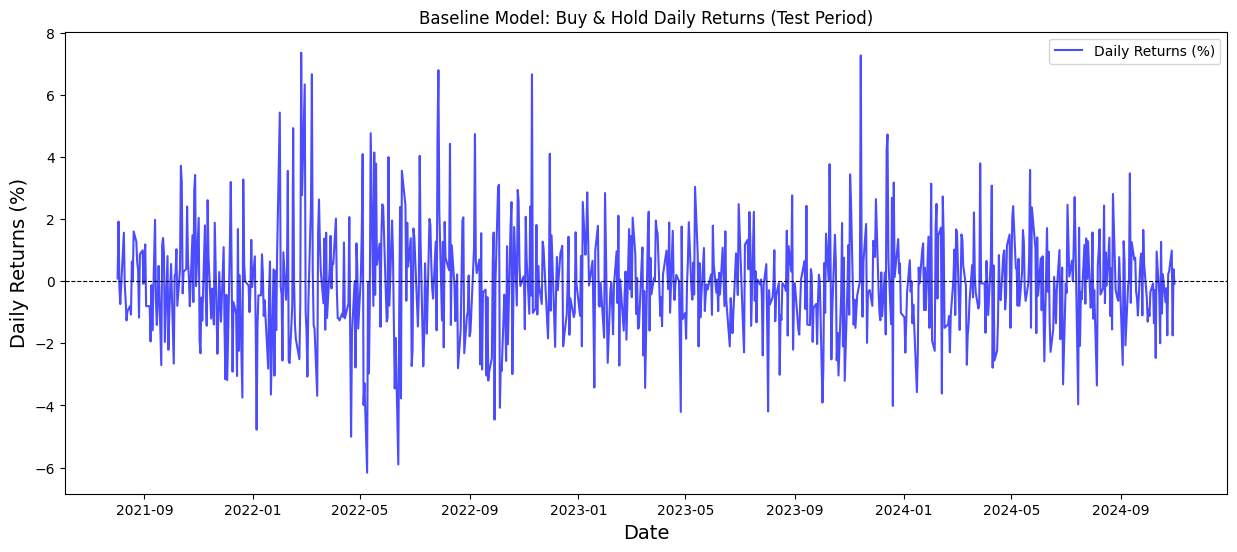

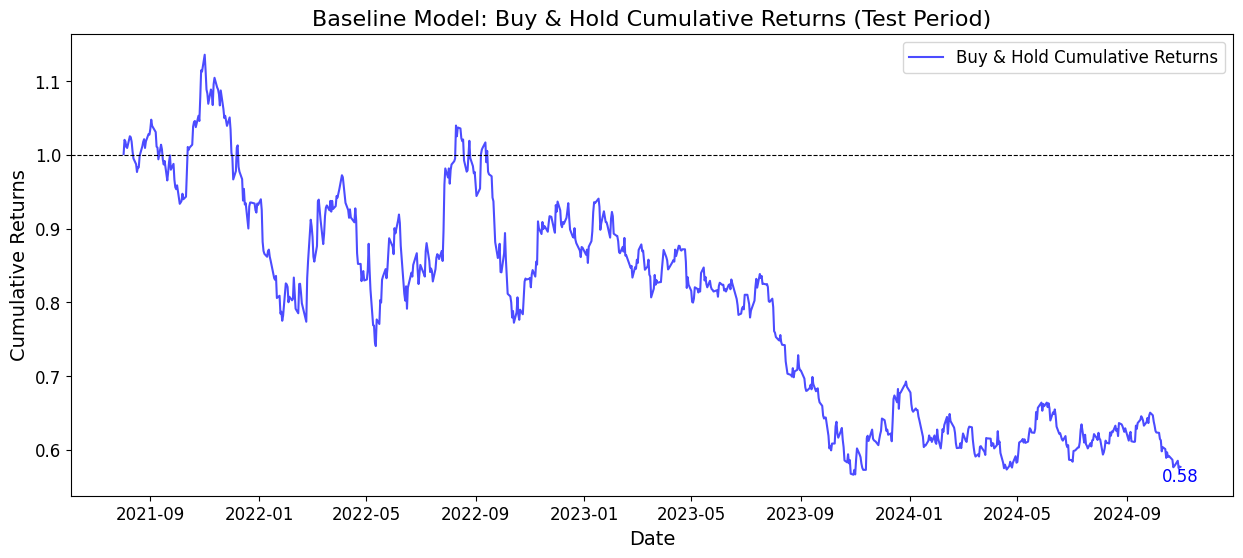

In [ ]:
# ============================================
# 5: Baseline Model: Buy & Hold Strategy
# ============================================

# Use the original non-standardized dataset to calculate daily returns
bnh_close_prices = data['Close']

# Calculate Daily Log Returns
data['ICLN_Return'] = np.log(bnh_close_prices / bnh_close_prices.shift(1))
test_daily_returns = data['ICLN_Return'].iloc[train_size + validation_size:].dropna()

# Define Sub-Periods for D-Ratio Calculation
period1 = len(test_daily_returns) // 2
returns_1st_period = test_daily_returns.iloc[:period1]
returns_2nd_period = test_daily_returns.iloc[period1:]

# Define Performance Metrics
def calculate_metrics(returns, rf_rate=0.0):
    """
    Calculate performance metrics for Buy & Hold strategy.
    :param returns: Daily log returns.
    :param rf_rate: Risk-free rate (default is 0.0).
    :return: Dictionary of performance metrics.
    """
    metrics = {}
    # 1. Return on Investment (RoI)
    metrics['RoI'] = np.exp(np.sum(returns)) - 1  # Total return over the period

    # 2. Volatility (Standard Deviation of returns)
    metrics['Volatility'] = np.std(returns) * np.sqrt(252)  # Annualized volatility

    # 3. Sharpe Ratio
    mean_return = np.mean(returns) * 252  # Annualized mean return
    metrics['Sharpe_Ratio'] = mean_return / metrics['Volatility']

    # 4. Sortino Ratio (Downside Risk)
    downside_returns = returns[returns < 0]
    downside_vol = np.std(downside_returns) * np.sqrt(252)  # Annualized downside deviation
    metrics['Sortino_Ratio'] = mean_return / downside_vol if downside_vol > 0 else np.nan

    # 5. Calmar Ratio
    cumulative_returns_bh = np.exp(returns.cumsum())  # Log returns
    max_drawdown = (cumulative_returns_bh.cummax() - cumulative_returns_bh).max()
    metrics['Calmar_Ratio'] = mean_return / max_drawdown if max_drawdown > 0 else np.nan

    return metrics

# Define Functions for D-Ratio Calculation
def risk_skew_kurt(log_return):
    """
    Calculate skewness and kurtosis for log returns.
    """
    mean = np.mean(log_return)
    st_dev = np.std(log_return)
    skew = stats.skew(log_return)
    kurt = stats.kurtosis(log_return)
    return (mean, st_dev), (skew, kurt)

def risk_cf_exp_var(log_return, asset_value=100, confid=0.01):
    """
    Calculate Cornish-Fisher Value at Risk (VaR).
    """
    (mean, st_dev), (skew, kurt) = risk_skew_kurt(log_return)
    quantile = norm.ppf(confid)
    cf_exp = (
        quantile + (quantile ** 2 - 1) * skew / 6
        + (quantile ** 3 - 3 * quantile) * kurt / 24
        - (2 * quantile ** 3 - 5 * quantile) * (skew ** 2) / 36
    )
    cf_var = mean + st_dev * cf_exp
    cf_asset_value = asset_value * (1 + cf_var)
    return cf_exp, cf_var, cf_asset_value

def get_d_ratio(returns_bh, returns_pred):
    """
    Calculate D-Ratio for B&H vs predictions.
    """
    epsilon = 1e-8  # Small constant to prevent division by zero
    returns_bh = returns_bh[1:]  # Exclude the first return for consistency
    returns_pred = returns_pred[1:]  # Exclude the first return for consistency
    d_ratios = np.zeros((7, 3))  # Initialize D-Ratio array

    period1 = len(returns_bh) // 2  # Mid-point for sub-period splits

    # Calculate metrics for full, first, and second sub-periods
    for i, (start, end) in enumerate([(0, len(returns_bh)), (0, period1), (period1, len(returns_bh))]):
        _, var_bh, _ = risk_cf_exp_var(returns_bh[start:end], 100, 0.01)
        _, var_pred, _ = risk_cf_exp_var(returns_pred[start:end], 100, 0.01)
        d_ratios[1, i] = np.mean(returns_bh[start:end]) * 252
        d_ratios[2, i] = np.mean(returns_pred[start:end]) * 252
        d_ratios[3, i] = var_bh
        d_ratios[4, i] = var_pred
        d_ratios[0, i] = (1 + (d_ratios[2, i] - d_ratios[1, i]) / (abs(d_ratios[1, i]) + epsilon)) * \
                         (d_ratios[3, i] / (d_ratios[4, i] + epsilon))
        d_ratios[5, i] = d_ratios[1, i] / -(d_ratios[3, i] + epsilon)  # RTV for B&H
        d_ratios[6, i] = d_ratios[2, i] / -(d_ratios[4, i] + epsilon)  # RTV for predictions

    return d_ratios

# Run B&H Metrics Calculation
metrics_bh = calculate_metrics(test_daily_returns)
d_ratios = get_d_ratio(test_daily_returns, test_daily_returns)

# Display Metrics
print("Baseline B&H Strategy Metrics for Test Period:")
for key, value in metrics_bh.items():
    print(f"{key}: {value:.4f}")

print("\nD-Ratio and related metrics for Test Period:")
print(f"D-Ratio for Full Period: {d_ratios[0, 0]:.4f}")
print(f"D-Ratio for First Period: {d_ratios[0, 1]:.4f}")
print(f"D-Ratio for Second Period: {d_ratios[0, 2]:.4f}")

# Plot Daily Returns
plt.figure(figsize=(15, 6))
plt.plot(test_daily_returns.index, test_daily_returns * 100, label='Daily Returns (%)', color='blue', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Baseline Model: Buy & Hold Daily Returns (Test Period)')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Returns (%)', fontsize=14)
plt.legend()
plt.show()

# Plot cumulative returns for the Buy & Hold strategy
cumulative_returns_bh = np.exp(test_daily_returns.cumsum())
plt.figure(figsize=(15, 6))
plt.plot(cumulative_returns_bh.index, cumulative_returns_bh, label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8)

# Get the last value and its index for annotation
last_value = cumulative_returns_bh.iloc[-1]
last_date = cumulative_returns_bh.index[-1]

# Annotate the last value
plt.text(last_date, last_value, f'{last_value:.2f}',
         color='blue', fontsize=12,
         verticalalignment='bottom' if last_value >= 1 else 'top',
         horizontalalignment='center')

# Add titles and labels
plt.title('Baseline Model: Buy & Hold Cumulative Returns (Test Period)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Increase font size for grid labels
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.show()






Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best Parameters from RandomizedSearchCV:
{'subsample': 0.5, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.001, 'gamma': 0.5, 'colsample_bytree': 0.7}
Accuracy: 0.5379
ROC AUC: 0.5280

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.89      0.68       458
           1       0.39      0.09      0.14       360

    accuracy                           0.54       818
   macro avg       0.47      0.49      0.41       818
weighted avg       0.48      0.54      0.45       818


Confusion Matrix:
[[408  50]
 [328  32]]

Investment Strategy Metrics for Test Period:
RoI: -0.352250
Volatility: 0.100907
Sharpe Ratio: -1.325764
Sortino Ratio: -0.644233
Calmar Ratio: -0.318362

D-Ratio and related metrics for Test Period:
D-Ratio for Full Period: 0.746080
D-Ratio for First Period: 0.056624
D-Ratio for Second P

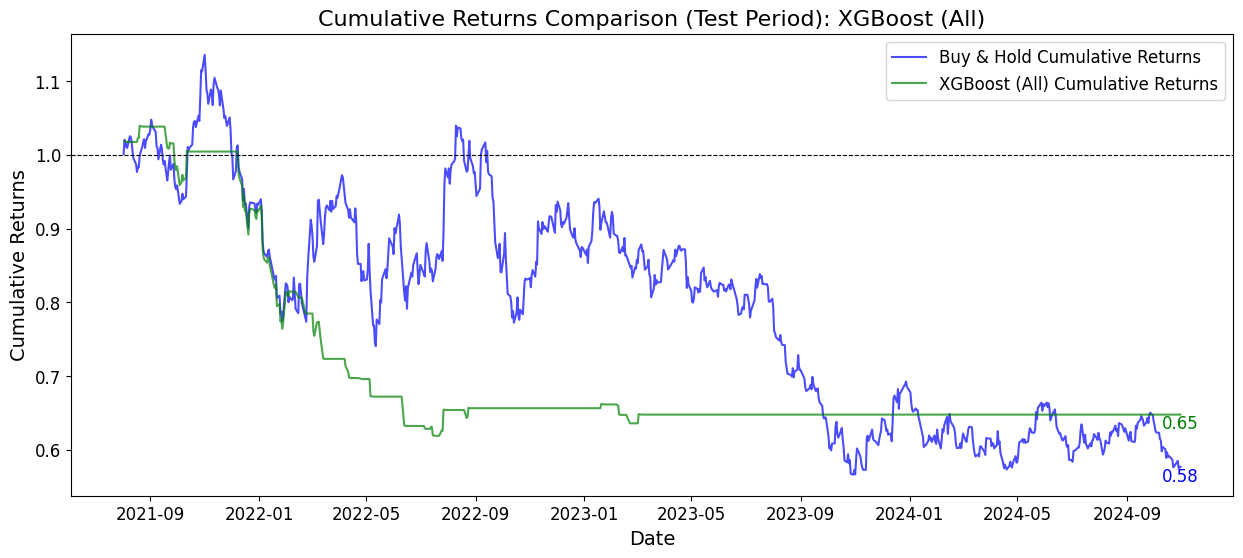

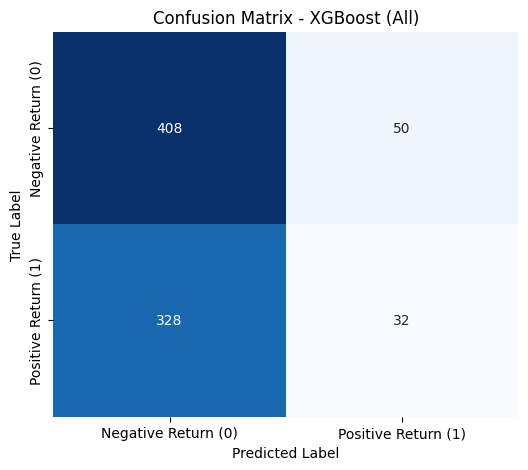

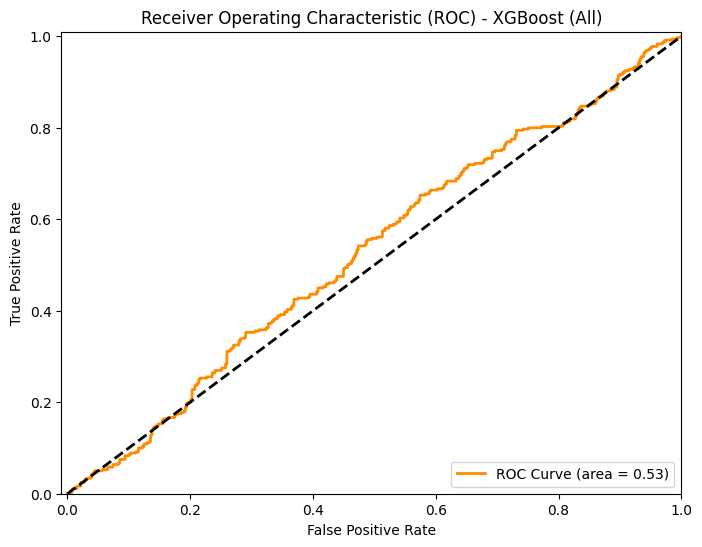


XGBoost (All) SHAP Plot - Bar Chart


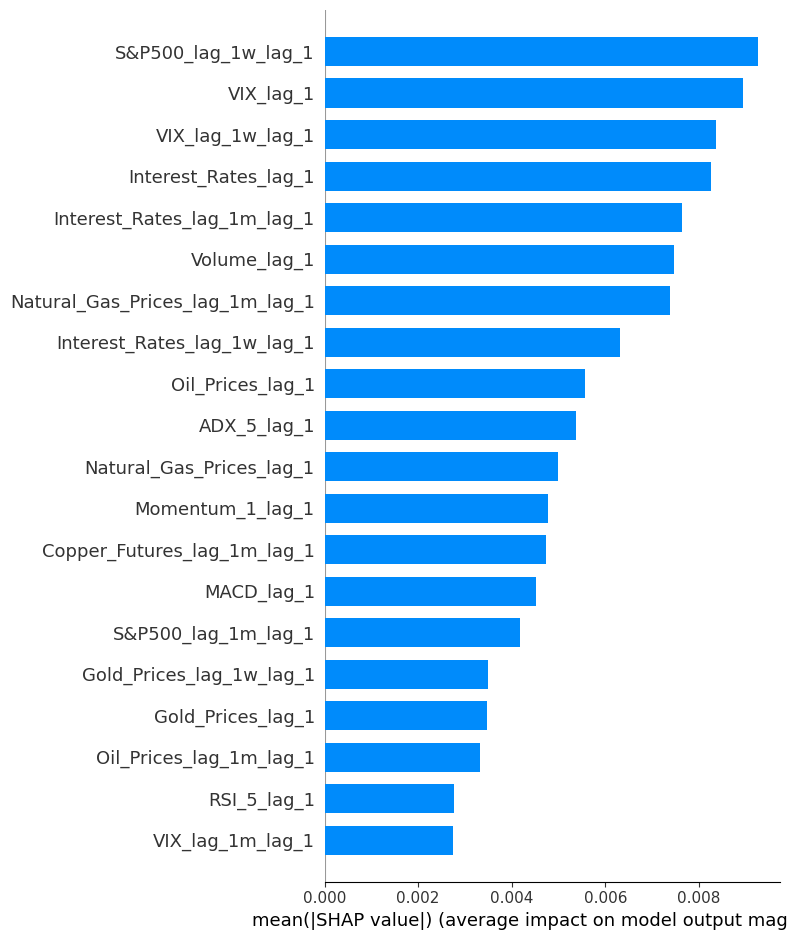


XGBoost (All) SHAP Plot - Beeswarm


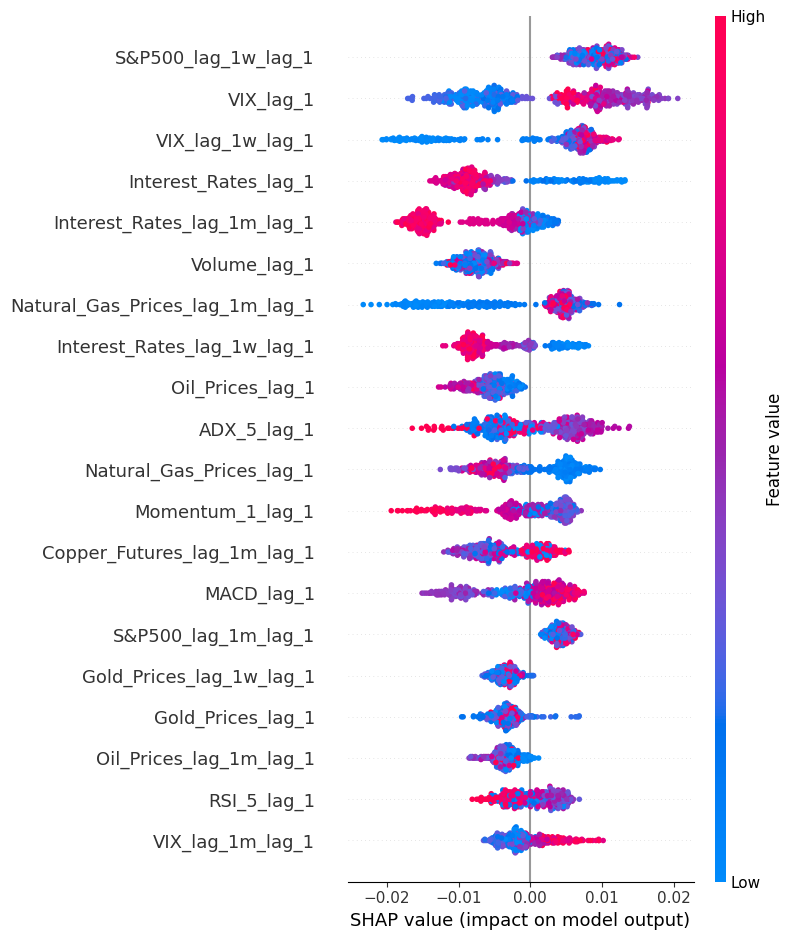


SHAP Summary Values (Bar Chart Data):
                            Feature  Mean Absolute SHAP Value
28              S&P500_lag_1w_lag_1                  0.009271
19                        VIX_lag_1                  0.008943
26                 VIX_lag_1w_lag_1                  0.008377
22             Interest_Rates_lag_1                  0.008250
33      Interest_Rates_lag_1m_lag_1                  0.007648
4                      Volume_lag_1                  0.007468
39  Natural_Gas_Prices_lag_1m_lag_1                  0.007373
32      Interest_Rates_lag_1w_lag_1                  0.006310
23                 Oil_Prices_lag_1                  0.005567
14                      ADX_5_lag_1                  0.005382
25         Natural_Gas_Prices_lag_1                  0.004988
18                 Momentum_1_lag_1                  0.004770
37      Copper_Futures_lag_1m_lag_1                  0.004729
9                        MACD_lag_1                  0.004514
29              S&P500_lag_1m_l

In [ ]:

# ============================================
# 6.1: XGBoost Model with Hyperparameter Tuning
# ============================================

# Define feature columns and target
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5', 'EMA_12', 'EMA_26', 'EMA_50', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower',
    'CCI_14', 'ATR_10', 'ADX_5', 'ADX_14', 'RSI_5', 'RSI_14', 'Momentum_1',
    'VIX', 'S&P500', 'Gold_Prices', 'Interest_Rates', 'Oil_Prices',
    'Copper_Futures', 'Natural_Gas_Prices',
    'VIX_lag_1w', 'VIX_lag_1m', 'S&P500_lag_1w', 'S&P500_lag_1m',
    'Gold_Prices_lag_1w', 'Gold_Prices_lag_1m', 'Interest_Rates_lag_1w', 'Interest_Rates_lag_1m',
    'Oil_Prices_lag_1w', 'Oil_Prices_lag_1m', 'Copper_Futures_lag_1w', 'Copper_Futures_lag_1m',
    'Natural_Gas_Prices_lag_1w', 'Natural_Gas_Prices_lag_1m'
]

# Lagging all features by 1 day to prevent data leakage
lagged_features = []
for feature in features:
    data[feature + '_lag_1'] = data[feature].shift(1)
    lagged_features.append(feature + '_lag_1')

# Drop rows with NaN values introduced by lagging
data.dropna(inplace=True)

# Update train_set, validation_set, test_set after lagging
train_set = data.iloc[:train_size]
validation_set = data.iloc[train_size:train_size + validation_size]
test_set = data.iloc[train_size + validation_size:]

train_set.index.max() < validation_set.index.min()
validation_set.index.max() < test_set.index.min()

# Define the features and target for classification
X_train = train_set[lagged_features]
y_train = train_set['Target']

X_validation = validation_set[lagged_features]
y_validation = validation_set['Target']

X_test = test_set[lagged_features]
y_test = test_set['Target']

# Combine training and validation sets for final training
X_train_full = pd.concat([X_train, X_validation])
y_train_full = pd.concat([y_train, y_validation])

# Define extended parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]


}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Perform Randomized Search Cross Validation without early stopping
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        seed=SEED
    ),
    param_distributions=param_dist,
    n_iter=100,
    scoring='roc_auc',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=SEED
)

# Fit RandomizedSearchCV
random_search.fit(X_train_full, y_train_full)

# Get the best parameters from RandomizedSearchCV
best_params = random_search.best_params_
print("\nBest Parameters from RandomizedSearchCV:")
print(best_params)

# Instantiate a new model with the best parameters
xgb_best = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=SEED,
    **best_params
)

# Fit the model directly on the full training set
xgb_best.fit(
    X_train_full,
    y_train_full,
    verbose=True
)

# Predict probabilities using the best model from RandomizedSearchCV
y_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

# Predict binary class labels using the threshold
threshold = 0.5
y_pred_class = (y_pred_proba >= threshold).astype(int)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Positions based on predicted class
positions = pd.Series(y_pred_class, index=X_test.index)

# Calculate strategy returns by multiplying actual returns with positions
strategy_returns = test_set['ICLN_Return'] * positions

# Apply transaction costs when positions change (buying or selling)
transaction_cost_rate = 0.001

# Calculate changes in positions (buying or selling)
position_changes = positions.diff().abs()

# Handle the first day's position change
position_changes.iloc[0] = positions.iloc[0]

# Calculate transaction costs
transaction_costs = transaction_cost_rate * position_changes

# Subtract transaction costs from strategy returns
net_strategy_returns = strategy_returns - transaction_costs

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

# Confusion Matrix
cm_6_1 = confusion_matrix(y_test, y_pred_class)
print("\nConfusion Matrix:")
print(cm_6_1)

# Investment Performance Metrics
# Annual Return (RoI)
roi = np.exp(np.sum(net_strategy_returns)) - 1

# Annualized Volatility
volatility = np.std(net_strategy_returns) * np.sqrt(252)

# Annualized Mean Return
mean_return = np.mean(net_strategy_returns) * 252

# Sharpe Ratio
sharpe_ratio = mean_return / volatility

# Sortino Ratio
downside_returns = net_strategy_returns[net_strategy_returns < 0]
downside_volatility = np.std(downside_returns) * np.sqrt(252)
sortino_ratio = mean_return / downside_volatility if downside_volatility > 0 else np.nan

# Calmar Ratio
cumulative_returns  = np.exp(net_strategy_returns.cumsum())
max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
calmar_ratio = mean_return / max_drawdown if max_drawdown > 0 else np.nan

# Calculate D-Ratio
returns_bh = test_set['ICLN_Return']
d_ratios_xgb = get_d_ratio(returns_bh, net_strategy_returns)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred_proba)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_proba)

# Filter out invalid indices for MAPE calculation
epsilon = 1e-8  # To avoid division by zero or near-zero denominators
valid_indices = y_test.abs() > epsilon

# Calculate MAPE
mape = (
    np.mean(np.abs((y_test[valid_indices] - y_pred_proba[valid_indices]) / y_test[valid_indices])) * 100
    if valid_indices.any()
    else np.nan
)

# Display Metrics
print("\nInvestment Strategy Metrics for Test Period:")
print(f"RoI: {roi:.6f}")
print(f"Volatility: {volatility:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio:.6f}")
print(f"Sortino Ratio: {sortino_ratio:.6f}")
print(f"Calmar Ratio: {calmar_ratio:.6f}")

print("\nD-Ratio and related metrics for Test Period:")
print(f"D-Ratio for Full Period: {d_ratios_xgb[0, 0]:.6f}")
print(f"D-Ratio for First Period: {d_ratios_xgb[0, 1]:.6f}")
print(f"D-Ratio for Second Period: {d_ratios_xgb[0, 2]:.6f}")

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"MAPE: {mape:.6f}%")

# ============================================
# Plotting Cumulative Returns Comparison
# ============================================

# Cumulative Returns for XGBoost Strategy
cumulative_returns_strategy_xgb = np.exp(net_strategy_returns.cumsum())

# Plot cumulative returns for Buy & Hold and XGBoost Strategy
plt.figure(figsize=(15, 6))
plt.plot(cumulative_returns_bh.index, cumulative_returns_bh, label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7)
plt.plot(cumulative_returns_strategy_xgb.index, cumulative_returns_strategy_xgb, label='XGBoost (All) Cumulative Returns', color='green', alpha=0.7)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8)

# Annotate the last value for Buy & Hold
last_value_bh = cumulative_returns_bh.iloc[-1]
last_date_bh = cumulative_returns_bh.index[-1]
plt.text(last_date_bh, last_value_bh, f'{last_value_bh:.2f}',
         color='blue', fontsize=12,
         verticalalignment='bottom' if last_value_bh >= 1 else 'top',
         horizontalalignment='center')

# Annotate the last value for XGBoost Strategy
last_value_xgb = cumulative_returns_strategy_xgb.iloc[-1]
last_date_xgb = cumulative_returns_strategy_xgb.index[-1]
plt.text(last_date_xgb, last_value_xgb, f'{last_value_xgb:.2f}',
         color='green', fontsize=12,
         verticalalignment='bottom' if last_value_xgb >= 1 else 'top',
         horizontalalignment='center')

# Add titles and labels with increased font sizes
plt.title('Cumulative Returns Comparison (Test Period): XGBoost (All)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Increase font size for grid labels (tick labels)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.show()

# Define labels
labels = ['Negative Return (0)', 'Positive Return (1)']

# Plot Confusion Matrix with labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm_6_1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - XGBoost (All)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost (All)')
plt.legend(loc='lower right')
plt.show()

# ============================================
# SHAP Analysis
# ============================================

# Initialize the JS visualization code
shap.initjs()

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_best)

# Calculate SHAP values
sample_size = 500
if len(X_test) > sample_size:
    X_test_sample = X_test.sample(sample_size, random_state=SEED)
else:
    X_test_sample = X_test

shap_values = explainer.shap_values(X_test_sample)

# SHAP summary plot (bar)
print("\nXGBoost (All) SHAP Plot - Bar Chart")
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", max_display=20)

# SHAP summary plot (beeswarm)
print("\nXGBoost (All) SHAP Plot - Beeswarm")
shap.summary_plot(shap_values, X_test_sample, max_display=20)

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easy viewing and sorting
shap_summary_df = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values
}).sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Display the SHAP summary DataFrame
print("\nSHAP Summary Values (Bar Chart Data):")
print(shap_summary_df)

# Extract the top 15 features based on SHAP values
top_15_features = shap_summary_df['Feature'].head(15).tolist()

# Subset the dataset to include only the top 15 features
X_train_top_15 = X_train_full[top_15_features]
X_validation_top_15 = X_validation[top_15_features]
X_test_top_15 = X_test[top_15_features]

# Print the top 15 features
print("\nTop 15 features selected based on SHAP values:")
print(top_15_features)

# Filter the SHAP summary DataFrame to include all macroeconomic variables with _lag_1, _lag_1w, and _lag_1m
macroeconomic_features = [
    # VIX
    'VIX_lag_1', 'VIX_lag_1w_lag_1', 'VIX_lag_1m_lag_1',
    # S&P500
    'S&P500_lag_1', 'S&P500_lag_1w_lag_1', 'S&P500_lag_1m_lag_1',
    # Gold Prices
    'Gold_Prices_lag_1', 'Gold_Prices_lag_1w_lag_1', 'Gold_Prices_lag_1m_lag_1',
    # Interest Rates
    'Interest_Rates_lag_1', 'Interest_Rates_lag_1w_lag_1', 'Interest_Rates_lag_1m_lag_1',
    # Oil Prices
    'Oil_Prices_lag_1', 'Oil_Prices_lag_1w_lag_1', 'Oil_Prices_lag_1m_lag_1',
    # Copper Futures
    'Copper_Futures_lag_1', 'Copper_Futures_lag_1w_lag_1', 'Copper_Futures_lag_1m_lag_1',
    # Natural Gas Prices
    'Natural_Gas_Prices_lag_1', 'Natural_Gas_Prices_lag_1w_lag_1', 'Natural_Gas_Prices_lag_1m_lag_1'
]
# Filter SHAP summary DataFrame for macroeconomic variables
shap_summary_macro_df = shap_summary_df[
    shap_summary_df['Feature'].isin(macroeconomic_features)
]

# Sort and get the top 10 macroeconomic variables
xgb_top_10_macrofeatures = shap_summary_macro_df.head(10)['Feature'].tolist()

# Print the top 10 macroeconomic features
print("\nTop 10 macroeconomic features selected based on SHAP values:")
print(xgb_top_10_macrofeatures)

# Subset the datasets to include only the top 10 macroeconomic features
X_train_macro_top_10 = X_train_full[xgb_top_10_macrofeatures]
X_validation_macro_top_10 = X_validation[xgb_top_10_macrofeatures]
X_test_macro_top_10 = X_test[xgb_top_10_macrofeatures]


Accuracy (Excluding Macro): 0.4670

Classification Report (Excluding Macro):
              precision    recall  f1-score   support

           0       0.54      0.34      0.41       458
           1       0.43      0.63      0.51       360

    accuracy                           0.47       818
   macro avg       0.48      0.48      0.46       818
weighted avg       0.49      0.47      0.46       818


Confusion Matrix (Excluding Macro):
[[154 304]
 [132 228]]


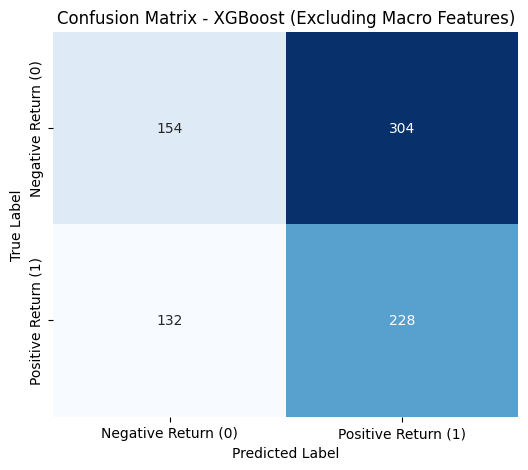


Investment Strategy Metrics (Excluding Macro) for Test Period:
RoI: -0.657239
Volatility: 0.229711
Sharpe Ratio: -1.435958
Sortino Ratio: -1.917265
Calmar Ratio: -0.448400

D-Ratio and related metrics (Excluding Macro) for Test Period:
D-Ratio for Full Period: 0.090891
D-Ratio for First Period: 0.129386
D-Ratio for Second Period: 0.065372

MSE (Combined Features): 0.250352
RMSE (Combined Features): 0.500352
MAE (Combined Features): 0.500214
MAPE (Combined Features): 49.753107%


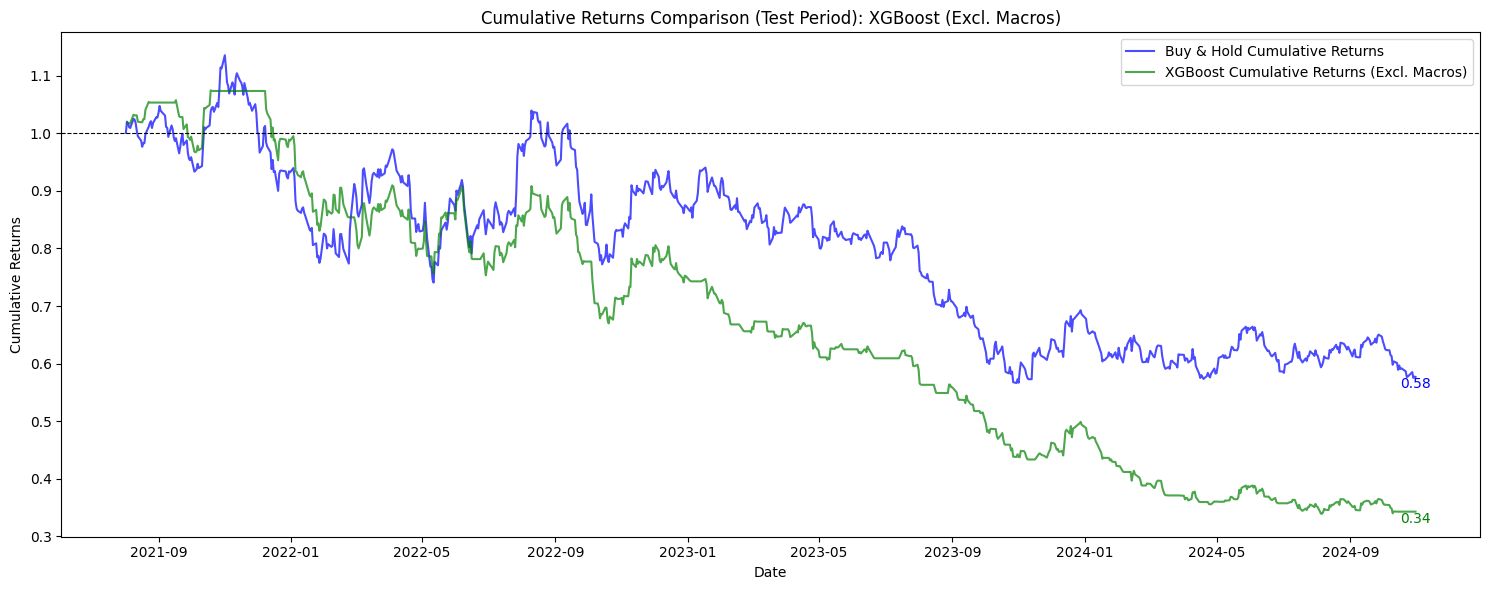

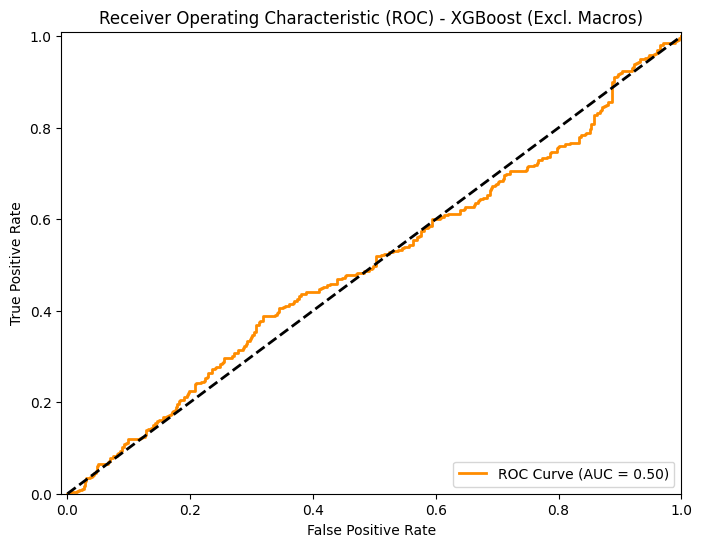

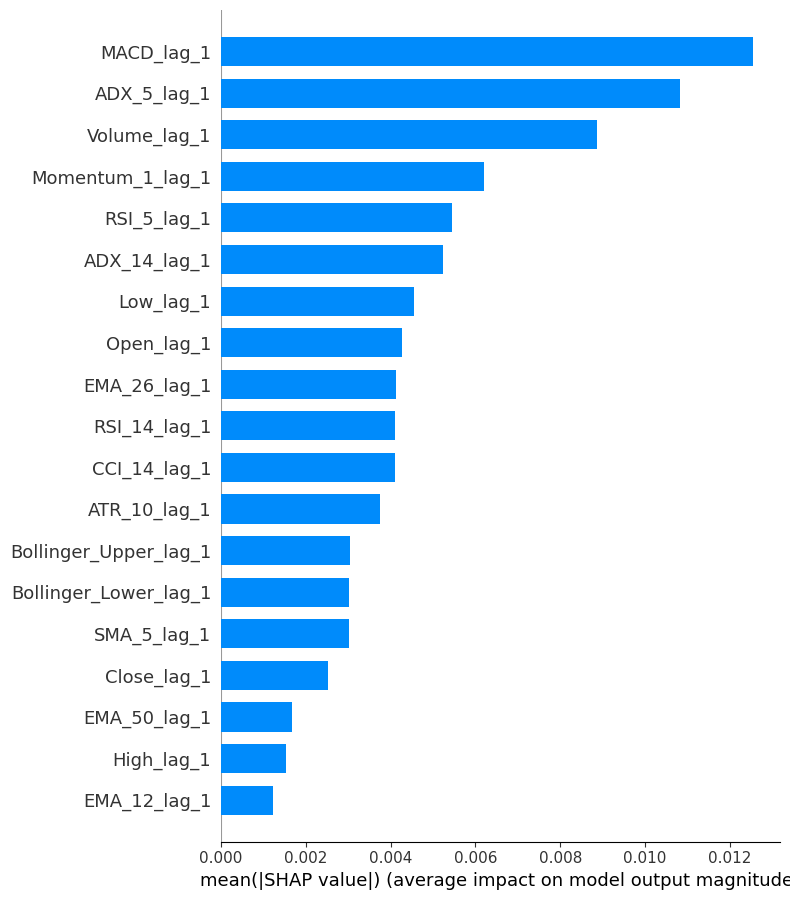

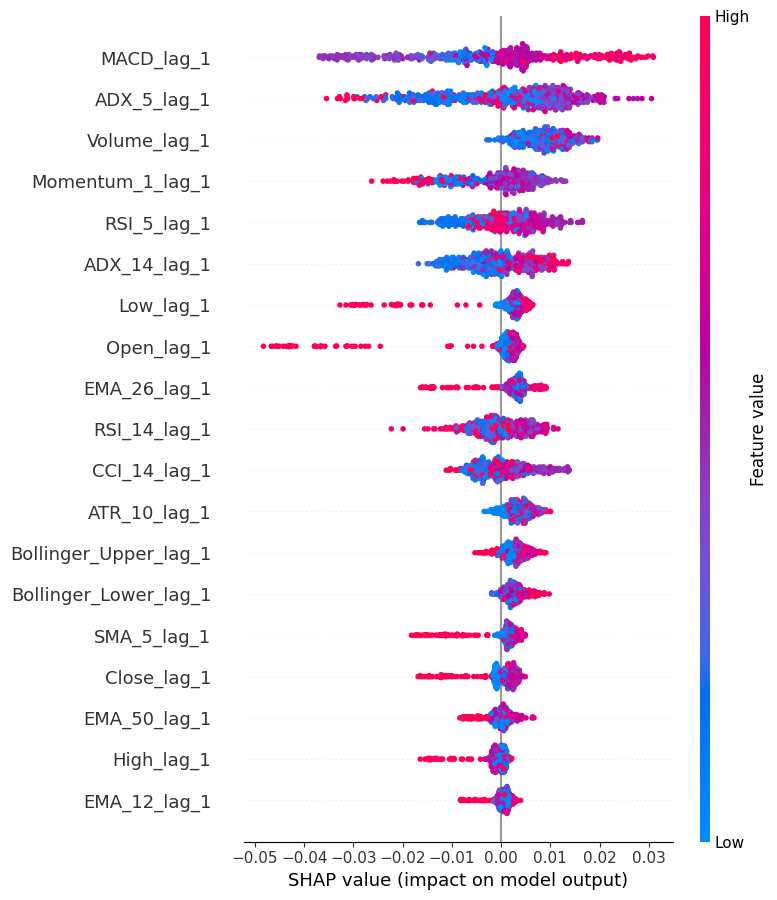


SHAP Summary Values (Bar Chart Data) - Excluding Macro Features:
                  Feature  Mean Absolute SHAP Value
9              MACD_lag_1                  0.012553
14            ADX_5_lag_1                  0.010830
4            Volume_lag_1                  0.008875
18       Momentum_1_lag_1                  0.006193
16            RSI_5_lag_1                  0.005452
15           ADX_14_lag_1                  0.005243
2               Low_lag_1                  0.004542
0              Open_lag_1                  0.004257
7            EMA_26_lag_1                  0.004136
17           RSI_14_lag_1                  0.004112
12           CCI_14_lag_1                  0.004107
13           ATR_10_lag_1                  0.003755
10  Bollinger_Upper_lag_1                  0.003032
11  Bollinger_Lower_lag_1                  0.003027
5             SMA_5_lag_1                  0.003018
3             Close_lag_1                  0.002515
8            EMA_50_lag_1                  0.00167

In [ ]:
# ============================================
# 6.2: XGBoost Model Without Macroeconomic Indicators
# ============================================

# Define feature columns excluding macroeconomic indicators
features_excluding_macro = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5', 'EMA_12', 'EMA_26', 'EMA_50', 'MACD',
    'Bollinger_Upper', 'Bollinger_Lower', 'CCI_14',
    'ATR_10', 'ADX_5', 'ADX_14', 'RSI_5', 'RSI_14', 'Momentum_1'
]

# Create lagged features excluding macroeconomic indicators
lagged_features_excluding_macro = [feature + '_lag_1' for feature in features_excluding_macro]

# Ensure `test_set_excl_macro` is defined
test_set_excl_macro = test_set.copy()

# Define the features and target for classification using existing sets
X_train_excl_macro = train_set[lagged_features_excluding_macro]
y_train_excl_macro = train_set['Target']

X_validation_excl_macro = validation_set[lagged_features_excluding_macro]
y_validation_excl_macro = validation_set['Target']

X_test_excl_macro = test_set_excl_macro[lagged_features_excluding_macro]
y_test_excl_macro = test_set_excl_macro['Target']

# Combine training and validation sets for final training
X_train_full_excl_macro = pd.concat([X_train_excl_macro, X_validation_excl_macro])
y_train_full_excl_macro = pd.concat([y_train_excl_macro, y_validation_excl_macro])

# Train the model with the best parameters
xgb_best_excl_macro = XGBClassifier(
    objective='binary:logistic',
    seed=SEED,
    eval_metric='logloss',
    **best_params
)

xgb_best_excl_macro.fit(X_train_full_excl_macro, y_train_full_excl_macro)

# Make predictions with the best model
y_pred_proba_excl_macro = xgb_best_excl_macro.predict_proba(X_test_excl_macro)[:, 1]

# Set a probability threshold for classification
threshold = 0.5
y_pred_class_excl_macro = (y_pred_proba_excl_macro >= threshold).astype(int)

# Positions based on predicted class
positions_excl_macro = pd.Series(y_pred_class_excl_macro, index=X_test_excl_macro.index)

# Calculate strategy returns by multiplying actual returns with positions
strategy_returns_excl_macro = test_set_excl_macro['ICLN_Return'] * positions_excl_macro

# Apply transaction costs when positions change (buying or selling)
transaction_cost_rate = 0.001

# Calculate changes in positions (buying or selling)
position_changes_excl_macro = positions_excl_macro.diff().abs()
# Handle the first day's position change
position_changes_excl_macro.iloc[0] = positions_excl_macro.iloc[0]

# Calculate transaction costs
transaction_costs_excl_macro = transaction_cost_rate * position_changes_excl_macro

# Subtract transaction costs from strategy returns
net_strategy_returns_excl_macro = strategy_returns_excl_macro - transaction_costs_excl_macro

# Classification Metrics
accuracy_excl_macro = accuracy_score(y_test_excl_macro, y_pred_class_excl_macro)
print(f"\nAccuracy (Excluding Macro): {accuracy_excl_macro:.4f}")

print("\nClassification Report (Excluding Macro):")
print(classification_report(y_test_excl_macro, y_pred_class_excl_macro))

# Confusion Matrix
cm_excl_macro = confusion_matrix(y_test_excl_macro, y_pred_class_excl_macro)
print("\nConfusion Matrix (Excluding Macro):")
print(cm_excl_macro)

# ============================================
# Confusion Matrix Visualization (Excluding Macro Features)
# ============================================

# Define labels
labels_excl_macro = ['Negative Return (0)', 'Positive Return (1)']

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_excl_macro, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels_excl_macro, yticklabels=labels_excl_macro)
plt.title('Confusion Matrix - XGBoost (Excluding Macro Features)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ============================================
# MSE, RMSE, MAE, MAPE Calculations (Excluding Macro)
# ============================================

# Calculate MSE
mse_excl_macro = mean_squared_error(y_test_excl_macro, y_pred_proba_excl_macro)
rmse_excl_macro = np.sqrt(mse_excl_macro)

# Calculate MAE
mae_excl_macro = mean_absolute_error(y_test_excl_macro, y_pred_proba_excl_macro)

# Filter out invalid indices for MAPE calculation
epsilon = 1e-8  # To avoid division by zero or near-zero denominators
valid_indices_excl_macro = y_test_excl_macro.abs() > epsilon

# Calculate MAPE
mape_excl_macro = (
    np.mean(np.abs((y_test_excl_macro[valid_indices_excl_macro] - y_pred_proba_excl_macro[valid_indices_excl_macro]) / y_test_excl_macro[valid_indices_excl_macro])) * 100
    if valid_indices_excl_macro.any()
    else np.nan
)

# ============================================
# Investment Performance Metrics (Excluding Macro)
# ============================================

# Annual Return (RoI)
roi_excl_macro = np.exp(np.sum(net_strategy_returns_excl_macro)) - 1

# Annualized Volatility
volatility_excl_macro = np.std(net_strategy_returns_excl_macro) * np.sqrt(252)

# Annualized Mean Return
mean_return_excl_macro = np.mean(net_strategy_returns_excl_macro) * 252

# Sharpe Ratio
sharpe_ratio_excl_macro = mean_return_excl_macro / volatility_excl_macro

# Sortino Ratio
downside_returns_excl_macro = net_strategy_returns_excl_macro[net_strategy_returns_excl_macro < 0]
downside_volatility_excl_macro = np.std(downside_returns_excl_macro) * np.sqrt(252)
sortino_ratio_excl_macro = mean_return_excl_macro / downside_volatility_excl_macro if downside_volatility_excl_macro > 0 else np.nan

# Calmar Ratio
cumulative_returns_excl_macro = np.exp(net_strategy_returns_excl_macro.cumsum())
max_drawdown_excl_macro = (cumulative_returns_excl_macro.cummax() - cumulative_returns_excl_macro).max()
calmar_ratio_excl_macro = mean_return_excl_macro / max_drawdown_excl_macro if max_drawdown_excl_macro > 0 else np.nan

# Display Metrics
print("\nInvestment Strategy Metrics (Excluding Macro) for Test Period:")
print(f"RoI: {roi_excl_macro:.6f}")
print(f"Volatility: {volatility_excl_macro:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio_excl_macro:.6f}")
print(f"Sortino Ratio: {sortino_ratio_excl_macro:.6f}")
print(f"Calmar Ratio: {calmar_ratio_excl_macro:.6f}")

# ============================================
# D-Ratio and Cumulative Returns Comparison
# ============================================

# Define the Buy-and-Hold and Strategy Returns for D-Ratio
returns_bh = test_set_excl_macro['ICLN_Return']
returns_pred = net_strategy_returns_excl_macro

# Calculate D-Ratio
d_ratios_excl_macro = get_d_ratio(returns_bh, returns_pred)

print("\nD-Ratio and related metrics (Excluding Macro) for Test Period:")
print(f"D-Ratio for Full Period: {d_ratios_excl_macro[0, 0]:.6f}")
print(f"D-Ratio for First Period: {d_ratios_excl_macro[0, 1]:.6f}")
print(f"D-Ratio for Second Period: {d_ratios_excl_macro[0, 2]:.6f}")

print(f"\nMSE (Combined Features): {mse_excl_macro:.6f}")
print(f"RMSE (Combined Features): {rmse_excl_macro:.6f}")
print(f"MAE (Combined Features): {mae_excl_macro:.6f}")
print(f"MAPE (Combined Features): {mape_excl_macro:.6f}%")

# ============================================
# Cumulative Returns Comparison
# ============================================

# Cumulative Returns for the XGBoost Strategy (Excluding Macro Features)
cumulative_returns_strategy_excl_macro = np.exp(net_strategy_returns_excl_macro.cumsum())

# Plot cumulative returns for Buy & Hold and Strategy (Excluding Macro)
plt.figure(figsize=(15, 6))
plt.plot(cumulative_returns_bh.index, cumulative_returns_bh, label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7)
plt.plot(cumulative_returns_strategy_excl_macro.index, cumulative_returns_strategy_excl_macro, label='XGBoost Cumulative Returns (Excl. Macros)', color='green', alpha=0.7)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8)

# Annotate the last value for Buy & Hold
last_value_bh = cumulative_returns_bh.iloc[-1]
last_date_bh = cumulative_returns_bh.index[-1]
plt.text(last_date_bh, last_value_bh, f'{last_value_bh:.2f}',
         color='blue', fontsize=10,
         verticalalignment='bottom' if last_value_bh >= 1 else 'top',
         horizontalalignment='center')

# Annotate the last value for Strategy (Excluding Macro)
last_value_excl_macro = cumulative_returns_strategy_excl_macro.iloc[-1]
last_date_excl_macro = cumulative_returns_strategy_excl_macro.index[-1]
plt.text(last_date_excl_macro, last_value_excl_macro, f'{last_value_excl_macro:.2f}',
         color='green', fontsize=10,
         verticalalignment='bottom' if last_value_excl_macro >= 1 else 'top',
         horizontalalignment='center')

# Add titles and labels
plt.title('Cumulative Returns Comparison (Test Period): XGBoost (Excl. Macros)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# ROC Curve
# ============================================

# Compute ROC curve and ROC area
fpr_excl_macro, tpr_excl_macro, _ = roc_curve(y_test_excl_macro, y_pred_proba_excl_macro)
roc_auc_excl_macro = auc(fpr_excl_macro, tpr_excl_macro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_excl_macro, tpr_excl_macro, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_excl_macro:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost (Excl. Macros)')
plt.legend(loc='lower right')
plt.show()

# ============================================
# SHAP Analysis (Excluding Macro Features)
# ============================================

# Initialize the SHAP explainer
shap.initjs()

# Use TreeExplainer for XGBoost
explainer_excl_macro = shap.TreeExplainer(xgb_best_excl_macro)

# Sample the test set for SHAP
sample_size = 500
if len(X_test_excl_macro) > sample_size:
    X_test_sample_excl_macro = X_test_excl_macro.sample(sample_size, random_state=SEED)
else:
    X_test_sample_excl_macro = X_test_excl_macro

# Calculate SHAP values
shap_values_excl_macro = explainer_excl_macro.shap_values(X_test_sample_excl_macro)

# SHAP summary plot (bar chart)
shap.summary_plot(shap_values_excl_macro, X_test_sample_excl_macro, plot_type="bar", max_display=20)

# SHAP summary plot (beeswarm)
shap.summary_plot(shap_values_excl_macro, X_test_sample_excl_macro, max_display=20)

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values_excl_macro = np.abs(shap_values_excl_macro).mean(axis=0)

# Create a DataFrame for SHAP summary
shap_summary_df_excl_macro = pd.DataFrame({
    'Feature': X_test_sample_excl_macro.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values_excl_macro
}).sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Display the SHAP summary DataFrame
print("\nSHAP Summary Values (Bar Chart Data) - Excluding Macro Features:")
print(shap_summary_df_excl_macro)

# Extract the top 15 features based on SHAP values
top_15_features_excl_macro = shap_summary_df_excl_macro['Feature'].head(15).tolist()

# Print the top 15 features
print("\nTop 15 Features Based on SHAP Values (Excluding Macro Features):")
print(top_15_features_excl_macro)



Combined Features (Lagged Non-Macro + Top 10 Macro):
['Open_lag_1', 'High_lag_1', 'Low_lag_1', 'Close_lag_1', 'Volume_lag_1', 'SMA_5_lag_1', 'EMA_12_lag_1', 'EMA_26_lag_1', 'EMA_50_lag_1', 'MACD_lag_1', 'Bollinger_Upper_lag_1', 'Bollinger_Lower_lag_1', 'CCI_14_lag_1', 'ATR_10_lag_1', 'ADX_5_lag_1', 'ADX_14_lag_1', 'RSI_5_lag_1', 'RSI_14_lag_1', 'Momentum_1_lag_1', 'S&P500_lag_1w_lag_1', 'VIX_lag_1', 'VIX_lag_1w_lag_1', 'Interest_Rates_lag_1', 'Interest_Rates_lag_1m_lag_1', 'Natural_Gas_Prices_lag_1m_lag_1', 'Interest_Rates_lag_1w_lag_1', 'Oil_Prices_lag_1', 'Natural_Gas_Prices_lag_1', 'Copper_Futures_lag_1m_lag_1']

Accuracy (Combined Features): 0.5428

Classification Report (Combined Features):
              precision    recall  f1-score   support

           0       0.56      0.82      0.67       458
           1       0.45      0.19      0.27       360

    accuracy                           0.54       818
   macro avg       0.51      0.50      0.47       818
weighted avg       0.5

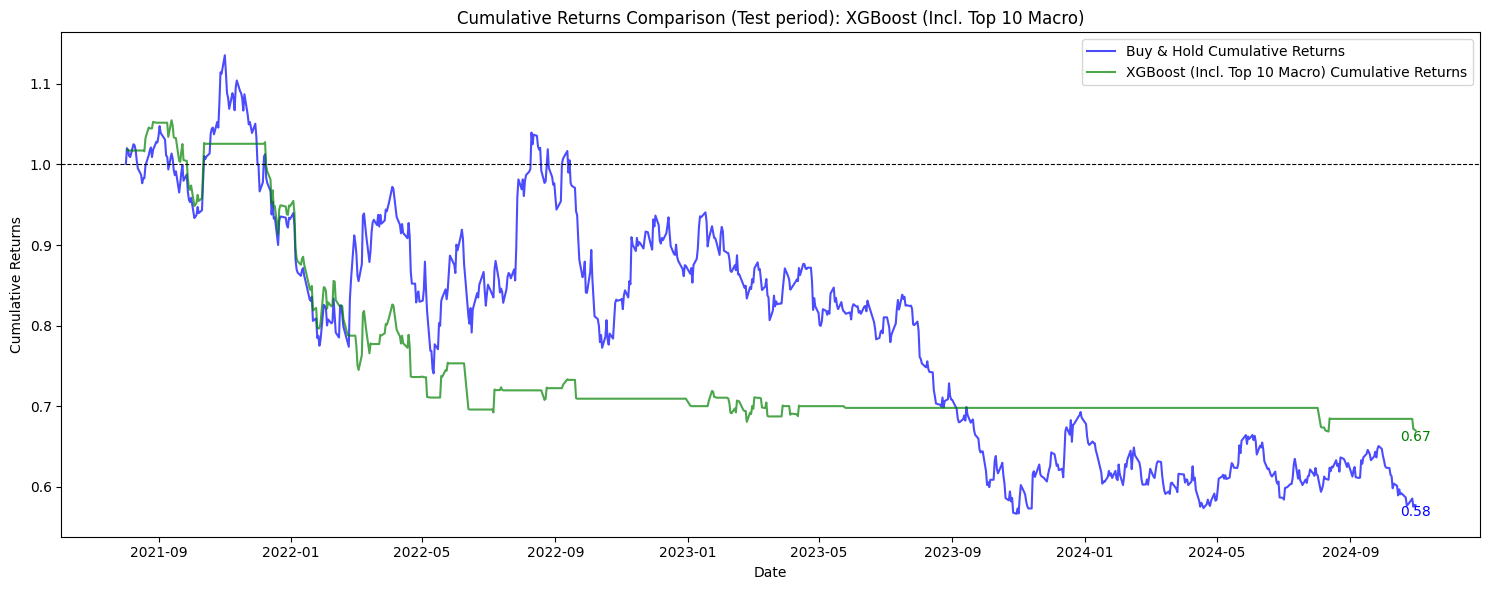

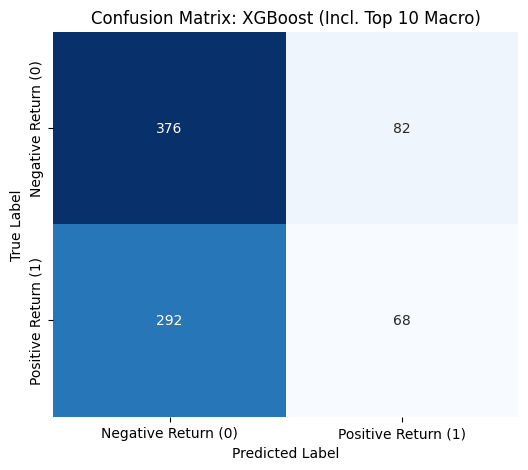

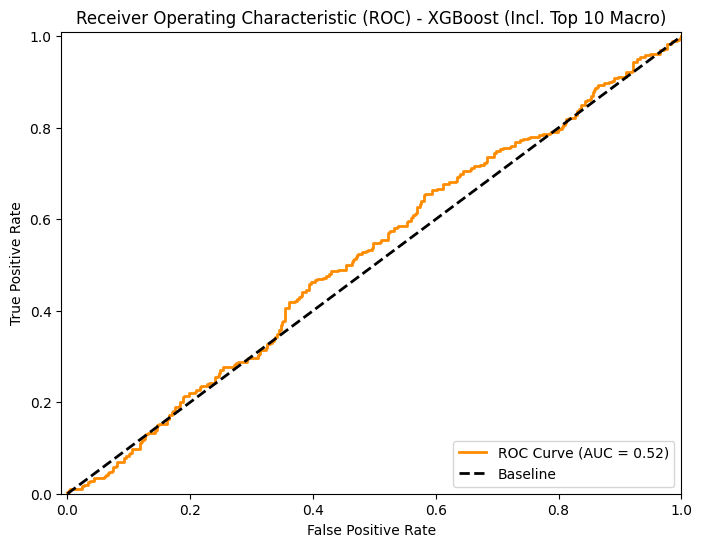

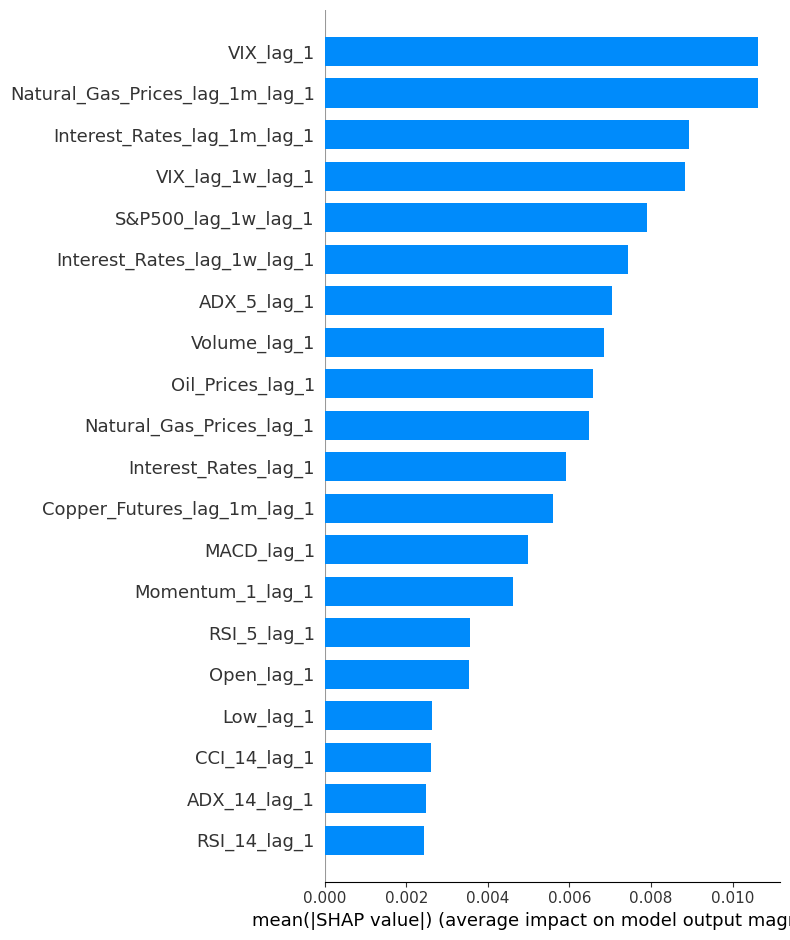

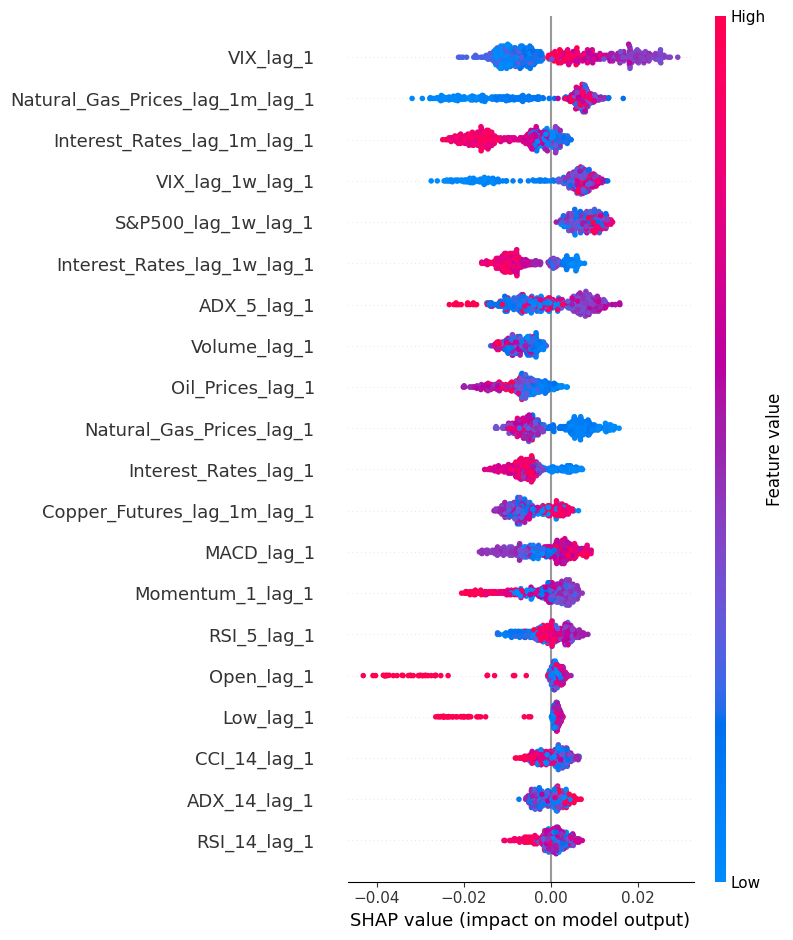


SHAP Summary Values (Bar Chart Data) - Combined Features:
                            Feature  Mean Absolute SHAP Value
20                        VIX_lag_1                  0.010629
24  Natural_Gas_Prices_lag_1m_lag_1                  0.010624
23      Interest_Rates_lag_1m_lag_1                  0.008942
21                 VIX_lag_1w_lag_1                  0.008830
19              S&P500_lag_1w_lag_1                  0.007898
25      Interest_Rates_lag_1w_lag_1                  0.007443
14                      ADX_5_lag_1                  0.007054
4                      Volume_lag_1                  0.006835
26                 Oil_Prices_lag_1                  0.006567
27         Natural_Gas_Prices_lag_1                  0.006480
22             Interest_Rates_lag_1                  0.005925
28      Copper_Futures_lag_1m_lag_1                  0.005596
9                        MACD_lag_1                  0.004978
18                 Momentum_1_lag_1                  0.004619
16         

In [ ]:
# ============================================
# 6.3: XGBoost Model With Top 10 Macroeconomic Indicators + Lagged Non-Macro Features
# ============================================

# Combine lagged non-macro features and top 10 macroeconomic features
combined_features = lagged_features_excluding_macro + xgb_top_10_macrofeatures

print("\nCombined Features (Lagged Non-Macro + Top 10 Macro):")
print(combined_features)

# Subset existing datasets with the combined feature set
X_train_combined = X_train_full[combined_features]
X_validation_combined = X_validation[combined_features]
X_test_combined = X_test[combined_features]

# Train the model with the best parameters
xgb_best_combined = XGBClassifier(
    objective='binary:logistic',
    seed=SEED,
    eval_metric='logloss',
    **best_params
)

xgb_best_combined.fit(X_train_combined, y_train_full)

# Make predictions with the best model
y_pred_proba_combined = xgb_best_combined.predict_proba(X_test_combined)[:, 1]

# Set a probability threshold for classification
threshold = 0.5
y_pred_class_combined = (y_pred_proba_combined >= threshold).astype(int)

# Positions based on predicted class
positions_combined = pd.Series(y_pred_class_combined, index=X_test_combined.index)

# Calculate strategy returns by multiplying actual returns with positions
strategy_returns_combined = test_set['ICLN_Return'] * positions_combined

# Apply transaction costs when positions change (buying or selling)
transaction_cost_rate = 0.001

# Calculate changes in positions (buying or selling)
position_changes_combined = positions_combined.diff().abs()
# Handle the first day's position change
position_changes_combined.iloc[0] = positions_combined.iloc[0]

# Calculate transaction costs
transaction_costs_combined = transaction_cost_rate * position_changes_combined

# Subtract transaction costs from strategy returns
net_strategy_returns_combined = strategy_returns_combined - transaction_costs_combined

# Classification Metrics
accuracy_combined = accuracy_score(y_test, y_pred_class_combined)
print(f"\nAccuracy (Combined Features): {accuracy_combined:.4f}")

print("\nClassification Report (Combined Features):")
print(classification_report(y_test, y_pred_class_combined))

# Confusion Matrix
cm_combined = confusion_matrix(y_test, y_pred_class_combined)

# ============================================
# Investment Performance Metrics (Combined Features)
# ============================================

# Annual Return (RoI)
roi_combined = np.exp(np.sum(net_strategy_returns_combined)) - 1

# Annualized Volatility
volatility_combined = np.std(net_strategy_returns_combined) * np.sqrt(252)

# Annualized Mean Return
mean_return_combined = np.mean(net_strategy_returns_combined) * 252

# Sharpe Ratio
sharpe_ratio_combined = mean_return_combined / volatility_combined

# Sortino Ratio
downside_returns_combined = net_strategy_returns_combined[net_strategy_returns_combined < 0]
downside_volatility_combined = np.std(downside_returns_combined) * np.sqrt(252)
sortino_ratio_combined = mean_return_combined / downside_volatility_combined if downside_volatility_combined > 0 else np.nan

# Calmar Ratio
cumulative_returns_combined = np.exp(net_strategy_returns_combined.cumsum())
max_drawdown_combined = (cumulative_returns_combined.cummax() - cumulative_returns_combined).max()
calmar_ratio_combined = mean_return_combined / max_drawdown_combined if max_drawdown_combined > 0 else np.nan

# D-Ratio
d_ratios_combined = get_d_ratio(test_set['ICLN_Return'], net_strategy_returns_combined)

print("\nInvestment Strategy Metrics (Combined Features) for Test Period:")
print(f"RoI: {roi_combined:.6f}")
print(f"Volatility: {volatility_combined:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio_combined:.6f}")
print(f"Sortino Ratio: {sortino_ratio_combined:.6f}")
print(f"Calmar Ratio: {calmar_ratio_combined:.6f}")

print("\nD-Ratio and related metrics (Combined Features) for Test Period:")
print(f"D-Ratio for Full Period: {d_ratios_combined[0, 0]:.6f}")
print(f"D-Ratio for First Period: {d_ratios_combined[0, 1]:.6f}")
print(f"D-Ratio for Second Period: {d_ratios_combined[0, 2]:.6f}")

# ============================================
# MSE, RMSE, MAE, MAPE Calculations (Combined Features)
# ============================================

# Calculate MSE
mse_combined = mean_squared_error(y_test, y_pred_proba_combined)
rmse_combined = np.sqrt(mse_combined)

# Calculate MAE
mae_combined = mean_absolute_error(y_test, y_pred_proba_combined)

# Filter out invalid indices for MAPE calculation
valid_indices_combined = y_test.abs() > epsilon

# Calculate MAPE
mape_combined = (
    np.mean(np.abs((y_test[valid_indices_combined] - y_pred_proba_combined[valid_indices_combined]) / y_test[valid_indices_combined])) * 100
    if valid_indices_combined.any()
    else np.nan
)

print(f"\nMSE (Combined Features): {mse_combined:.6f}")
print(f"RMSE (Combined Features): {rmse_combined:.6f}")
print(f"MAE (Combined Features): {mae_combined:.6f}")
print(f"MAPE (Combined Features): {mape_combined:.6f}%")

# ============================================
# Plotting Cumulative Returns Comparison
# ============================================

# Cumulative Returns for Buy & Hold using log returns
cumulative_returns_strategy_combined = np.exp(net_strategy_returns_combined.cumsum())

# Plot cumulative returns for Buy & Hold and Combined Features Strategy
plt.figure(figsize=(15, 6))
plt.plot(cumulative_returns_bh.index, cumulative_returns_bh,
         label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7)
plt.plot(cumulative_returns_strategy_combined.index, cumulative_returns_strategy_combined,
         label='XGBoost (Incl. Top 10 Macro) Cumulative Returns', color='green', alpha=0.7)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8)

# Annotate the last value for Buy & Hold
last_value_bh = cumulative_returns_bh.iloc[-1]
last_date_bh = cumulative_returns_bh.index[-1]
plt.text(last_date_bh, last_value_bh, f'{last_value_bh:.2f}',
         color='blue', fontsize=10,
         verticalalignment='bottom' if last_value_bh >= 1 else 'top',
         horizontalalignment='center')

# Annotate the last value for Combined Features Strategy
last_value_combined = cumulative_returns_strategy_combined.iloc[-1]
last_date_combined = cumulative_returns_strategy_combined.index[-1]
plt.text(last_date_combined, last_value_combined, f'{last_value_combined:.2f}',
         color='green', fontsize=10,
         verticalalignment='bottom' if last_value_combined >= 1 else 'top',
         horizontalalignment='center')

# Add titles and labels
plt.title('Cumulative Returns Comparison (Test period): XGBoost (Incl. Top 10 Macro)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# Confusion Matrix Heatmap
# ============================================

plt.figure(figsize=(6, 5))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative Return (0)', 'Positive Return (1)'],
            yticklabels=['Negative Return (0)', 'Positive Return (1)'])
plt.title('Confusion Matrix: XGBoost (Incl. Top 10 Macro)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ============================================
# ROC Curve
# ============================================

# Compute ROC curve and ROC area
fpr_combined, tpr_combined, _ = roc_curve(y_test, y_pred_proba_combined)
roc_auc_combined = auc(fpr_combined, tpr_combined)

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_combined, tpr_combined, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_combined:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost (Incl. Top 10 Macro)')
plt.legend(loc='lower right')
plt.show()

# ============================================
# SHAP Analysis (Combined Features)
# ============================================

# Initialize the SHAP explainer for the combined feature set
explainer_combined = shap.TreeExplainer(xgb_best_combined)

# Sample the test set for SHAP
sample_size = 500
if len(X_test_combined) > sample_size:
    X_test_sample_combined = X_test_combined.sample(sample_size, random_state=SEED)
else:
    X_test_sample_combined = X_test_combined

# Calculate SHAP values
shap_values_combined = explainer_combined.shap_values(X_test_sample_combined)

# SHAP summary plot (bar chart)
shap.summary_plot(shap_values_combined, X_test_sample_combined, plot_type="bar", max_display=20)

# SHAP summary plot (beeswarm)
shap.summary_plot(shap_values_combined, X_test_sample_combined, max_display=20)

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values_combined = np.abs(shap_values_combined).mean(axis=0)

# Create a DataFrame for SHAP summary
shap_summary_df_combined = pd.DataFrame({
    'Feature': X_test_sample_combined.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values_combined
}).sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Display the SHAP summary DataFrame
print("\nSHAP Summary Values (Bar Chart Data) - Combined Features:")
print(shap_summary_df_combined)




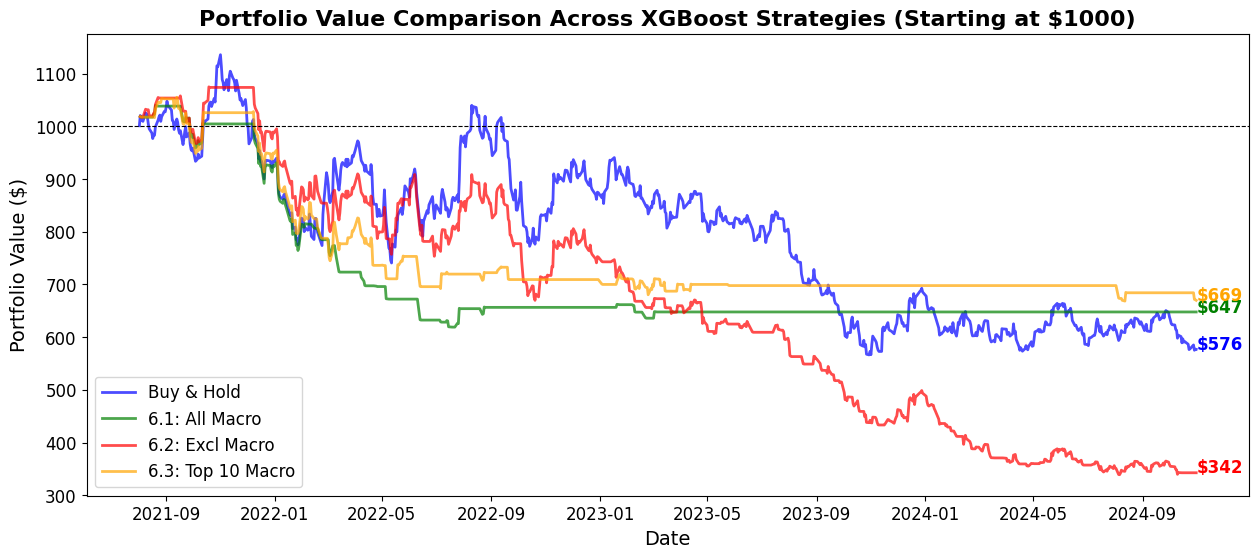


Summary of Final Portfolio Values and Metrics:
            Strategy  Final Portfolio Value    ROI (%)  Volatility (%)  \
0         Buy & Hold                    576 -42.316156       28.107425   
1     6.1: All Macro                    647 -35.224977       10.090690   
2    6.2: Excl Macro                    342 -65.723866       22.971103   
3  6.3: Top 15 Macro                    669 -33.022802       13.179852   

   Sharpe Ratio  Sortino Ratio  Calmar Ratio  D-Ratio (Full Period)       MSE  \
0     -0.602297      -1.028590     -0.297338               1.000000       NaN   
1     -1.325764      -0.644233     -0.318362               0.746080  0.248382   
2     -1.435958      -1.917265     -0.448400               0.090891  0.250352   
3     -0.936880      -0.640403     -0.319429               0.910114  0.248688   

       RMSE       MAE   MAPE (%)  Accuracy (%)  
0       NaN       NaN        NaN           NaN  
1  0.498379  0.498146  51.174004     53.789731  
2  0.500352  0.500214  49.75

In [ ]:
# ============================================
# 6.4 Summary for XGBoost Strategies
# ============================================

# Initial investment
initial_investment = 1000

# Cumulative Returns for Buy & Hold using log returns
portfolio_value_bh = initial_investment * cumulative_returns_bh

# Cumulative Returns for Strategy 6.1 (All Macroeconomic Indicators)
cumulative_returns_strategy_6_1 = cumulative_returns_strategy_xgb
portfolio_value_strategy_6_1 = initial_investment * cumulative_returns_strategy_6_1

# Cumulative Returns for Strategy 6.2 (Excluding Macroeconomic Indicators)
cumulative_returns_strategy_6_2 = cumulative_returns_strategy_excl_macro
portfolio_value_strategy_6_2 = initial_investment * cumulative_returns_strategy_6_2

# Cumulative Returns for Strategy 6.3 (Top 10 Macroeconomic Indicators)
cumulative_returns_strategy_6_3 = cumulative_returns_strategy_combined
portfolio_value_strategy_6_3 = initial_investment * cumulative_returns_strategy_6_3

# Plot portfolio values comparison
plt.figure(figsize=(15, 6))
plt.plot(portfolio_value_bh.index, portfolio_value_bh, label='Buy & Hold', color='blue', alpha=0.7, linewidth=2)
plt.plot(portfolio_value_strategy_6_1.index, portfolio_value_strategy_6_1, label='6.1: All Macro', color='green', alpha=0.7, linewidth=2)
plt.plot(portfolio_value_strategy_6_2.index, portfolio_value_strategy_6_2, label='6.2: Excl Macro', color='red', alpha=0.7, linewidth=2)
plt.plot(portfolio_value_strategy_6_3.index, portfolio_value_strategy_6_3, label='6.3: Top 10 Macro', color='orange', alpha=0.7, linewidth=2)

# Adding text labels for the last value of each line
plt.text(portfolio_value_bh.index[-1], portfolio_value_bh.iloc[-1], f'${int(portfolio_value_bh.iloc[-1])}',
         color='blue', fontsize=12, weight='bold', ha='left')
plt.text(portfolio_value_strategy_6_1.index[-1], portfolio_value_strategy_6_1.iloc[-1], f'${int(portfolio_value_strategy_6_1.iloc[-1])}',
         color='green', fontsize=12, weight='bold', ha='left')
plt.text(portfolio_value_strategy_6_2.index[-1], portfolio_value_strategy_6_2.iloc[-1], f'${int(portfolio_value_strategy_6_2.iloc[-1])}',
         color='red', fontsize=12, weight='bold', ha='left')
plt.text(portfolio_value_strategy_6_3.index[-1], portfolio_value_strategy_6_3.iloc[-1], f'${int(portfolio_value_strategy_6_3.iloc[-1])}',
         color='orange', fontsize=12, weight='bold', ha='left')

# Baseline reference at $1000
plt.axhline(initial_investment, color='black', linestyle='--', linewidth=0.8)
plt.title('Portfolio Value Comparison Across XGBoost Strategies (Starting at $1000)', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(loc='lower left', fontsize=12, bbox_to_anchor=(0, 0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Summary of Final Portfolio Values and Metrics
metrics_comparison = {
    "Strategy": ["Buy & Hold", "6.1: All Macro", "6.2: Excl Macro", "6.3: Top 15 Macro"],
    "Final Portfolio Value": [
        int(portfolio_value_bh.iloc[-1]),
        int(portfolio_value_strategy_6_1.iloc[-1]),
        int(portfolio_value_strategy_6_2.iloc[-1]),
        int(portfolio_value_strategy_6_3.iloc[-1])
    ],
    "ROI (%)": [
        metrics_bh['RoI'] * 100,
        roi * 100,
        roi_excl_macro * 100,
        roi_combined * 100
    ],
    "Volatility (%)": [
        metrics_bh['Volatility'] * 100,
        volatility * 100,
        volatility_excl_macro * 100,
        volatility_combined * 100
    ],
    "Sharpe Ratio": [
        metrics_bh['Sharpe_Ratio'],
        sharpe_ratio,
        sharpe_ratio_excl_macro,
        sharpe_ratio_combined
    ],
    "Sortino Ratio": [
        metrics_bh['Sortino_Ratio'],
        sortino_ratio,
        sortino_ratio_excl_macro,
        sortino_ratio_combined
    ],
    "Calmar Ratio": [
        metrics_bh['Calmar_Ratio'],
        calmar_ratio,
        calmar_ratio_excl_macro,
        calmar_ratio_combined
    ],
    "D-Ratio (Full Period)": [
        d_ratios[0, 0],
        d_ratios_xgb[0, 0],
        d_ratios_excl_macro[0, 0],
        d_ratios_combined[0, 0]
    ],
    "MSE": [
        None,  # MSE not applicable for Buy & Hold
        mse,
        mse_excl_macro,
        mse_combined
    ],
    "RMSE": [
        None,  # RMSE not applicable for Buy & Hold
        rmse,
        rmse_excl_macro,
        rmse_combined
    ],
    "MAE": [
        None,  # MAE not applicable for Buy & Hold
        mae,
        mae_excl_macro,
        mae_combined
    ],
    "MAPE (%)": [
        None,  # MAPE not applicable for Buy & Hold
        mape,
        mape_excl_macro,
        mape_combined
    ],
    "Accuracy (%)": [
        None,  # Accuracy not applicable for Buy & Hold
        accuracy * 100,
        accuracy_excl_macro * 100,
        accuracy_combined * 100
    ]
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_comparison)

# Display the DataFrame
print("\nSummary of Final Portfolio Values and Metrics:")
print(metrics_df)
metrics_df

# Align the indices of all portfolio values with Buy & Hold
portfolio_value_strategy_6_1 = portfolio_value_strategy_6_1.reindex(portfolio_value_bh.index, method='ffill')
portfolio_value_strategy_6_2 = portfolio_value_strategy_6_2.reindex(portfolio_value_bh.index, method='ffill')
portfolio_value_strategy_6_3 = portfolio_value_strategy_6_3.reindex(portfolio_value_bh.index, method='ffill')

# Calculate whether each strategy outperformed the Buy & Hold strategy at each time step
outperform_6_1 = portfolio_value_strategy_6_1 > portfolio_value_bh
outperform_6_2 = portfolio_value_strategy_6_2 > portfolio_value_bh
outperform_6_3 = portfolio_value_strategy_6_3 > portfolio_value_bh

# Calculate the percentage of time each strategy outperformed Buy & Hold
percent_outperform_6_1 = (outperform_6_1.sum() / len(outperform_6_1)) * 100
percent_outperform_6_2 = (outperform_6_2.sum() / len(outperform_6_2)) * 100
percent_outperform_6_3 = (outperform_6_3.sum() / len(outperform_6_3)) * 100

# Display the results
print(f"Percentage of time Strategy 6.1 outperformed Buy & Hold: {percent_outperform_6_1:.2f}%")
print(f"Percentage of time Strategy 6.2 outperformed Buy & Hold: {percent_outperform_6_2:.2f}%")
print(f"Percentage of time Strategy 6.3 outperformed Buy & Hold: {percent_outperform_6_3:.2f}%")


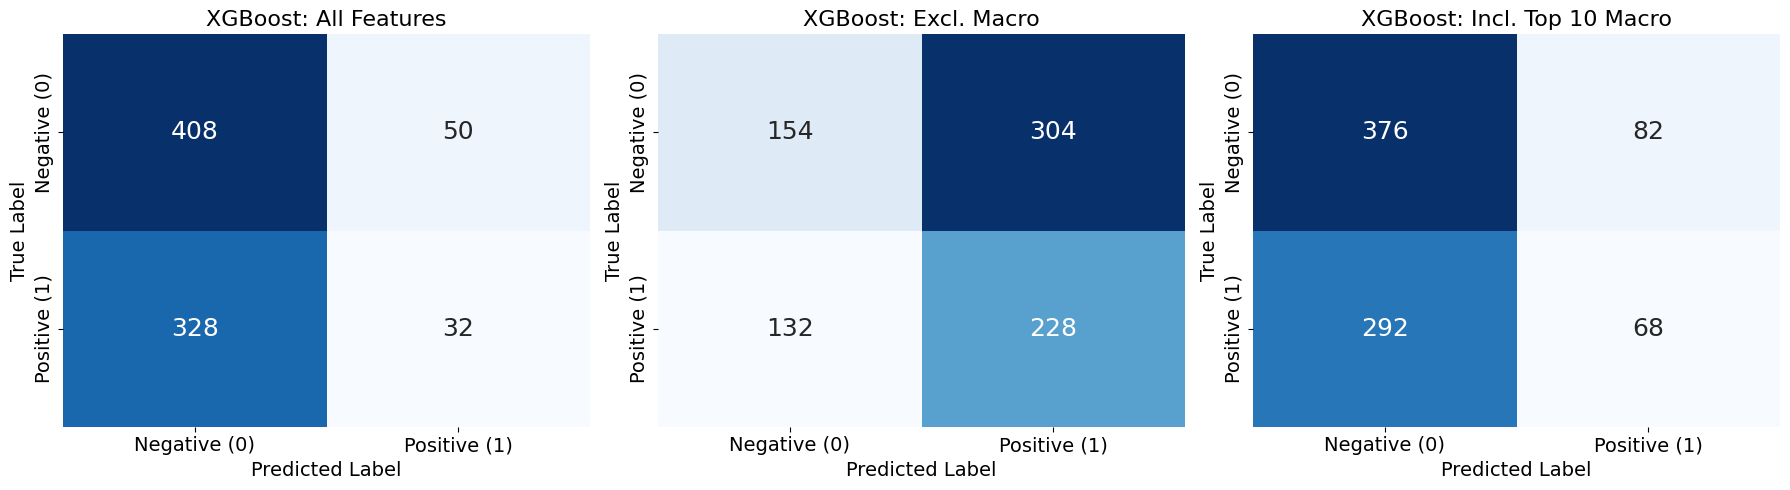

Metrics Baseline (B&H) XGBoost (All)  \
0        Return on Investment         -42.3%        -35.2%   
1                  Volatility          28.1%          0.10   
2                Sharpe Ratio      -0.602297     -1.325764   
3               Sortino Ratio       -1.02859     -0.644233   
4                Calmar Ratio      -0.297338     -0.318362   
5     D-Ratio for Full Period            1.0       0.74608   
6    D-Ratio for First Period            1.0      0.056624   
7   D-Ratio for Second Period            1.0           N.A   
8                         MSE            N.A         24.8%   
9                        RMSE            N.A         49.8%   
10                        MAE            N.A         49.8%   
11                       MAPE            N.A         51.2%   
12                   Accuracy            N.A         53.8%   

   XGBoost (Excl. Macros) XGBoost (Incl. Top 10 Macros)  
0                  -65.7%                        -33.0%  
1                    0.23                          0.13  
2               -1.435958                      -0.93688  
3               -1.917265                     -0.640403  
4                 -0.4484                     -0.319429  
5                0.090891                      0.910114  
6                0.129386                      0.278483  
7                0.065372                      1.130053  
8                   25.0%                         24.9%  
9                   50.0%                         49.9%  
10                  50.0%                         49.8%  
11                  49.8%                         51.0%  
12                  46.7%                         54.3%

<Figure size 640x480 with 0 Axes>

In [ ]:

# ============================================
# 6.4 Summary for XGBoost Strategies
# ============================================

confusion_matrices = [
    (cm_6_1, 'XGBoost: All Features'),
    (cm_excl_macro, 'XGBoost: Excl. Macro'),
    (cm_combined, 'XGBoost: Incl. Top 10 Macro')
]

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (cm, title) in zip(axes, confusion_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative (0)', 'Positive (1)'],
                yticklabels=['Negative (0)', 'Positive (1)'],
                ax=ax,
                annot_kws={"size": 18})

    # Set title with specific font size
    ax.set_title(title, fontsize=16)

    # Set x and y labels with specific font size
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)

    # Set tick labels font size
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

# Save the figure with high resolution
plt.savefig('combined_confusion_matrices.png', dpi=300)

# Create a dictionary for the summary table
summary_table = {
    "Metrics": [
        "Return on Investment",
        "Volatility",
        "Sharpe Ratio",
        "Sortino Ratio",
        "Calmar Ratio",
        "D-Ratio for Full Period",
        "D-Ratio for First Period",
        "D-Ratio for Second Period",
        "MSE",
        "RMSE",
        "MAE",
        "MAPE",
        "Accuracy"
    ],
    "Baseline (B&H)": [
        f"{metrics_bh['RoI'] * 100:.1f}%",
        f"{metrics_bh['Volatility'] * 100:.1f}%",
        metrics_bh['Sharpe_Ratio'],
        metrics_bh['Sortino_Ratio'],
        metrics_bh['Calmar_Ratio'],
        d_ratios[0, 0],
        d_ratios[0, 1],
        d_ratios[0, 2],
        "N.A",
        "N.A",
        "N.A",
        "N.A",
        "N.A"
    ],
    "XGBoost (All)": [
        f"{roi * 100:.1f}%",
        f"{volatility:.2f}",
        sharpe_ratio,
        sortino_ratio,
        calmar_ratio,
        d_ratios_xgb[0, 0],
        d_ratios_xgb[0, 1],
        "N.A" if pd.isna(d_ratios_xgb[0, 2]) else d_ratios_xgb[0, 2],
        f"{mse * 100:.1f}%",
        f"{rmse * 100:.1f}%",
        f"{mae * 100:.1f}%",
        f"{mape:.1f}%",
        f"{accuracy * 100:.1f}%"
    ],
    "XGBoost (Excl. Macros)": [
        f"{roi_excl_macro * 100:.1f}%",
        f"{volatility_excl_macro:.2f}",
        sharpe_ratio_excl_macro,
        sortino_ratio_excl_macro,
        calmar_ratio_excl_macro,
        d_ratios_excl_macro[0, 0],
        d_ratios_excl_macro[0, 1],
        "N.A" if pd.isna(d_ratios_excl_macro[0, 2]) else d_ratios_excl_macro[0, 2],
        f"{mse_excl_macro * 100:.1f}%",
        f"{rmse_excl_macro * 100:.1f}%",
        f"{mae_excl_macro * 100:.1f}%",
        f"{mape_excl_macro:.1f}%",
        f"{accuracy_excl_macro * 100:.1f}%"
    ],
    "XGBoost (Incl. Top 10 Macros)": [
        f"{roi_combined * 100:.1f}%",
        f"{volatility_combined:.2f}",
        sharpe_ratio_combined,
        sortino_ratio_combined,
        calmar_ratio_combined,
        d_ratios_combined[0, 0],
        d_ratios_combined[0, 1],
        "N.A" if pd.isna(d_ratios_combined[0, 2]) else d_ratios_combined[0, 2],
        f"{mse_combined * 100:.1f}%",
        f"{rmse_combined * 100:.1f}%",
        f"{mae_combined * 100:.1f}%",
        f"{mape_combined:.1f}%",
        f"{accuracy_combined * 100:.1f}%"
    ],
}

# Convert the dictionary into a DataFrame
summary_df = pd.DataFrame(summary_table)
summary_df




Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Number of positive: 1630, number of negative: 1647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 3277, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497406 -> initscore=-0.010375
[LightGBM] [Info] Start training from score -0.010375

Best Parameters from RandomizedSearchCV (LightGBM):
{'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 20, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 0.8}
[LightGBM] [Info] Number of positive: 1630, number of negative: 1647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_col_wise=true`

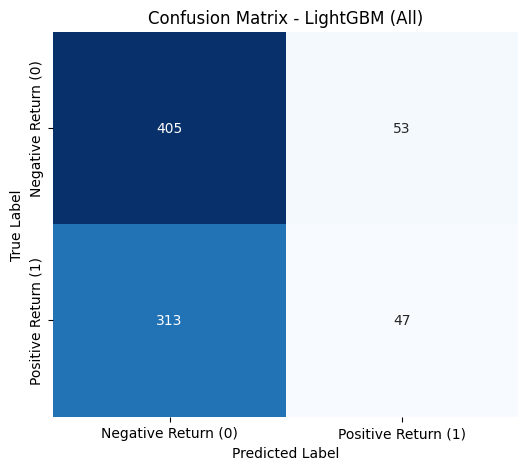

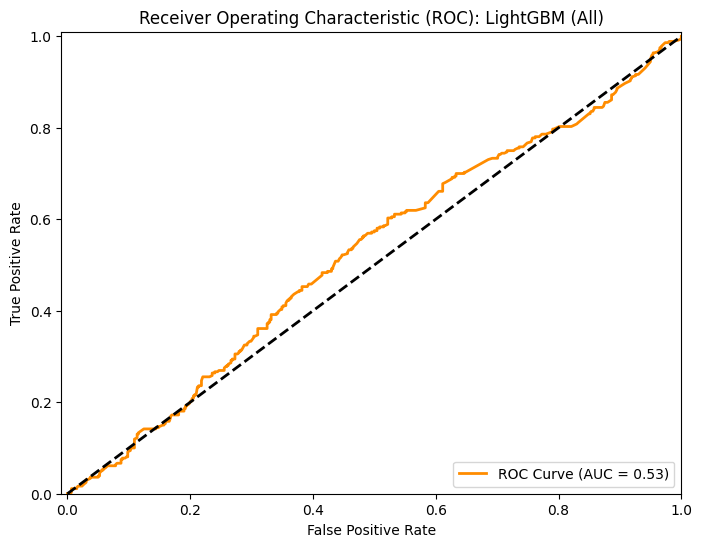


Investment Strategy Metrics for Test Period:
RoI: -0.359976
Volatility: 0.100438
Sharpe Ratio: -1.368757
Sortino Ratio: -0.732890
Calmar Ratio: -0.339301

D-Ratio and related metrics for Test Period:
D-Ratio for Full Period: 0.746080
D-Ratio for First Period: 0.056624
D-Ratio for Second Period: nan
MSE: 0.248692
RMSE: 0.498379
MAE: 0.498541
MAPE: 50.808082%


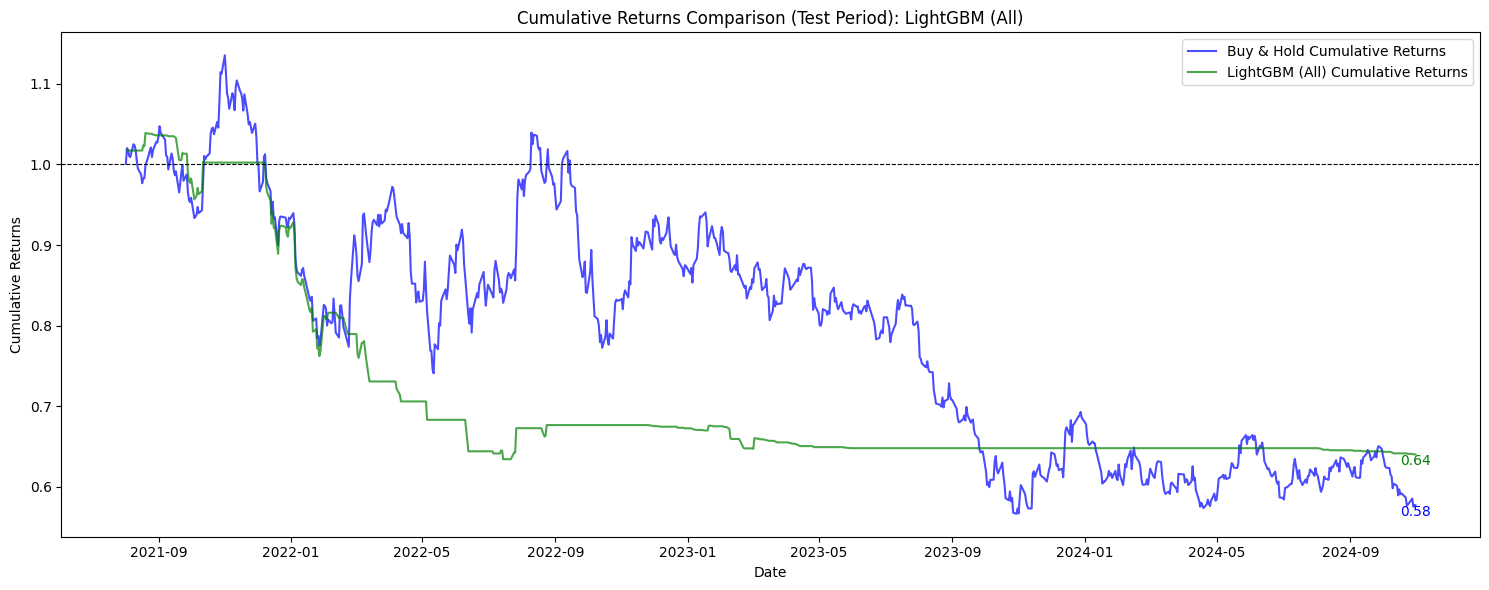

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')



LightGBM (All) SHAP Plot - Bar Chart


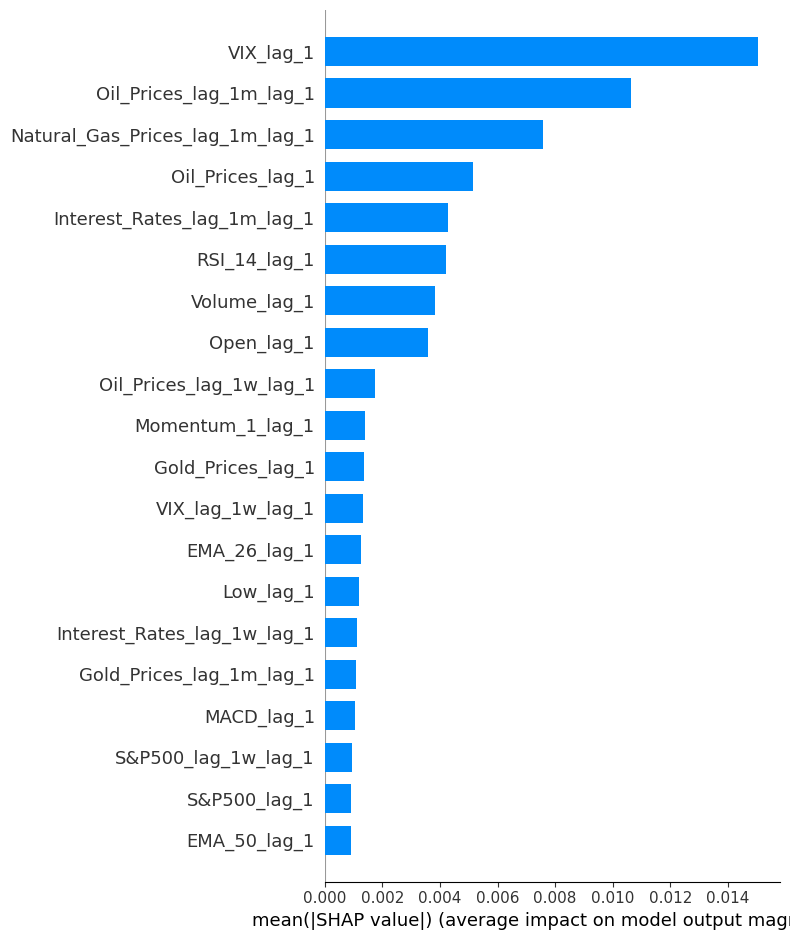


LightGBM (All) SHAP Plot - Beeswarm


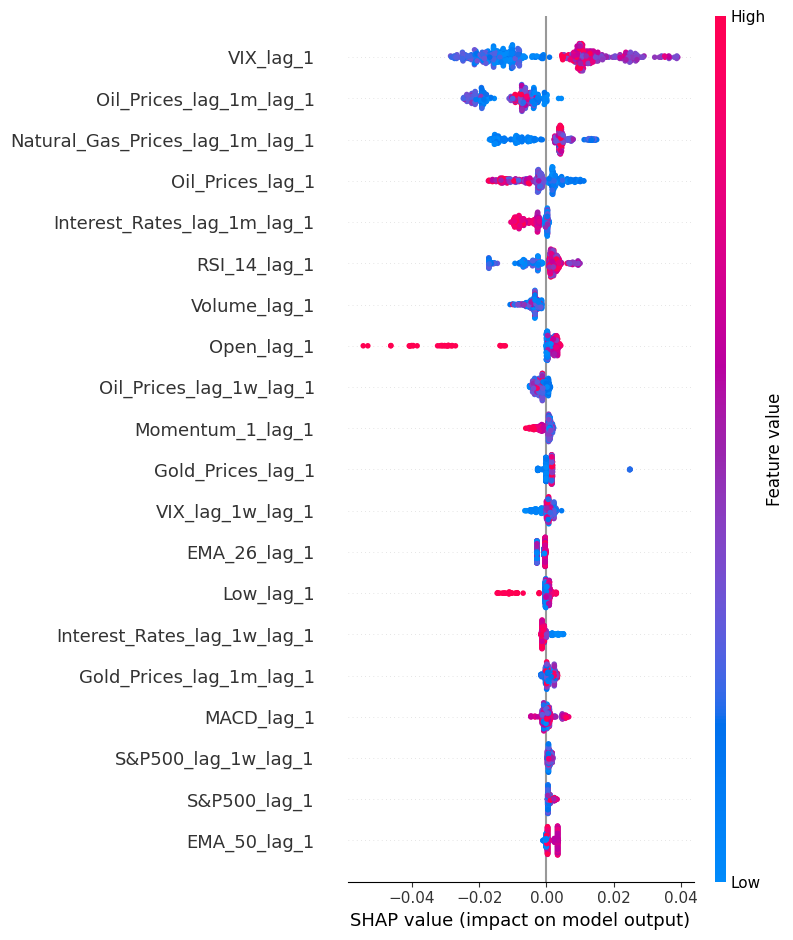


LightGBM (All) SHAP Summary Values (Bar Chart Data):
                            Feature  Mean Absolute SHAP Value
19                        VIX_lag_1                  0.015049
35          Oil_Prices_lag_1m_lag_1                  0.010640
39  Natural_Gas_Prices_lag_1m_lag_1                  0.007575
23                 Oil_Prices_lag_1                  0.005134
33      Interest_Rates_lag_1m_lag_1                  0.004299
17                     RSI_14_lag_1                  0.004228
4                      Volume_lag_1                  0.003833
0                        Open_lag_1                  0.003600
34          Oil_Prices_lag_1w_lag_1                  0.001749
18                 Momentum_1_lag_1                  0.001399
21                Gold_Prices_lag_1                  0.001364
26                 VIX_lag_1w_lag_1                  0.001341
7                      EMA_26_lag_1                  0.001261
2                         Low_lag_1                  0.001186
32      Interest

In [ ]:
# ============================================
# 7.1: LightGBM Model with Hyperparameter Tuning
# ============================================

# Define the features and target for classification
X_train = train_set[lagged_features]
y_train = train_set['Target']

X_validation = validation_set[lagged_features]
y_validation = validation_set['Target']

X_test = test_set[lagged_features]
y_test = test_set['Target']

# Combine training and validation sets for final training
X_train_full = pd.concat([X_train, X_validation])
y_train_full = pd.concat([y_train, y_validation])

# Define the parameter grid for RandomizedSearchCV
param_dist_lgb = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'num_leaves': [20, 30, 50, 70],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# Instantiate LGBMClassifier
lgb_model = LGBMClassifier(objective='binary', random_state=SEED)

# Define TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Use RandomizedSearchCV with TimeSeriesSplit
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=100,
    scoring='roc_auc',
    cv=tscv,
    verbose=1,
    random_state=SEED,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search_lgb.fit(X_train_full, y_train_full)

# Get the best parameters
best_params_lgb = random_search_lgb.best_params_
print("\nBest Parameters from RandomizedSearchCV (LightGBM):")
print(best_params_lgb)

# Retrain LightGBM model with best parameters
lgb_best = LGBMClassifier(objective='binary', random_state=SEED, **best_params_lgb)

# Fit the model with early stopping using callbacks
lgb_best.fit(
    X_train_full, y_train_full,
    eval_set=[(X_validation, y_validation)],
    eval_metric='binary_logloss',
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)

# Make predictions with the best model
threshold = 0.5
y_pred_proba = lgb_best.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred_proba >= threshold).astype(int)

# Positions based on predicted class
positions_7_1 = pd.Series(y_pred_class, index=X_test.index)

# Investment Performance Metrics
strategy_returns_7_1 = test_set['ICLN_Return'] * positions
transaction_cost_rate_7_1 = 0.001
position_changes_7_1 = positions_7_1.diff().abs()
position_changes_7_1.iloc[0] = positions_7_1.iloc[0]
transaction_costs_7_1 = transaction_cost_rate_7_1 * position_changes_7_1
net_strategy_returns_7_1 = strategy_returns_7_1 - transaction_costs_7_1

# Classification Metrics
accuracy_7_1 = accuracy_score(y_test, y_pred_class)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

# Confusion Matrix
cm_lgb_7_1 = confusion_matrix(y_test, y_pred_class)
print("\nConfusion Matrix:")
print(cm_lgb_7_1)

# Plot Confusion Matrix for Model 7.1
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgb_7_1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative Return (0)', 'Positive Return (1)'],
            yticklabels=['Negative Return (0)', 'Positive Return (1)'])
plt.title('Confusion Matrix - LightGBM (All)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve for Model 7.1
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_7_1 = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_7_1:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC): LightGBM (All)')
plt.legend(loc='lower right')
plt.show()

# Investment Performance Metrics for Model 7.1
roi_7_1 = np.exp(np.sum(net_strategy_returns_7_1)) - 1
volatility_7_1 = np.std(net_strategy_returns_7_1) * np.sqrt(252)
mean_return_7_1 = np.mean(net_strategy_returns_7_1) * 252
sharpe_ratio_7_1 = mean_return_7_1 / volatility_7_1

downside_returns_7_1 = net_strategy_returns_7_1[net_strategy_returns_7_1 < 0]
downside_volatility_7_1 = np.std(downside_returns_7_1) * np.sqrt(252)
sortino_ratio_7_1 = mean_return_7_1 / downside_volatility_7_1 if downside_volatility > 0 else np.nan

cumulative_returns_7_1 = np.exp(net_strategy_returns_7_1.cumsum())
max_drawdown_7_1 = (cumulative_returns_7_1.cummax() - cumulative_returns_7_1).max()
calmar_ratio_7_1 = mean_return_7_1 / max_drawdown_7_1 if max_drawdown_7_1 > 0 else np.nan

# D-Ratio Calculation for Model 7.1
d_ratios_lgb_7_1 = get_d_ratio(returns_bh, net_strategy_returns)

# MSE, RMSE, MAE, MAPE Calculations for Model 7.1
mse_7_1 = mean_squared_error(y_test, y_pred_proba)
rmse_7_1 = np.sqrt(mse)
mae_7_1 = mean_absolute_error(y_test, y_pred_proba)

valid_indices = y_test.abs() > epsilon
mape_7_1 = (
    np.mean(np.abs((y_test[valid_indices] - y_pred_proba[valid_indices]) / y_test[valid_indices])) * 100
    if valid_indices.any()
    else np.nan
)

print("\nInvestment Strategy Metrics for Test Period:")
print(f"RoI: {roi_7_1:.6f}")
print(f"Volatility: {volatility_7_1:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio_7_1:.6f}")
print(f"Sortino Ratio: {sortino_ratio_7_1:.6f}")
print(f"Calmar Ratio: {calmar_ratio_7_1:.6f}")

print("\nD-Ratio and related metrics for Test Period:")
print(f"D-Ratio for Full Period: {d_ratios_lgb_7_1[0, 0]:.6f}")
print(f"D-Ratio for First Period: {d_ratios_lgb_7_1[0, 1]:.6f}")
print(f"D-Ratio for Second Period: {d_ratios_lgb_7_1[0, 2]:.6f}")

print(f"MSE: {mse_7_1:.6f}")
print(f"RMSE: {rmse_7_1:.6f}")
print(f"MAE: {mae_7_1:.6f}")
print(f"MAPE: {mape_7_1:.6f}%")

# Plot Cumulative Returns for Model 7.1
cumulative_returns_strategy_7_1 = np.exp(net_strategy_returns_7_1.cumsum())

# Plot cumulative returns for Buy & Hold and LightGBM Strategy
plt.figure(figsize=(15, 6))
plt.plot(cumulative_returns_bh.index, cumulative_returns_bh,
         label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7)
plt.plot(cumulative_returns_strategy_7_1.index, cumulative_returns_strategy_7_1,
         label='LightGBM (All) Cumulative Returns', color='green', alpha=0.7)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8)

# Annotate the last value for Buy & Hold
last_value_bh = cumulative_returns_bh.iloc[-1]
last_date_bh = cumulative_returns_bh.index[-1]
plt.text(last_date_bh, last_value_bh, f'{last_value_bh:.2f}',
         color='blue', fontsize=10,
         verticalalignment='bottom' if last_value_bh >= 1 else 'top',
         horizontalalignment='center')

# Annotate the last value for LightGBM Strategy
last_value_lgbm = cumulative_returns_strategy_7_1.iloc[-1]
last_date_lgbm = cumulative_returns_strategy_7_1.index[-1]
plt.text(last_date_lgbm, last_value_lgbm, f'{last_value_lgbm:.2f}',
         color='green', fontsize=10,
         verticalalignment='bottom' if last_value_lgbm >= 1 else 'top',
         horizontalalignment='center')

# Add titles and labels
plt.title('Cumulative Returns Comparison (Test Period): LightGBM (All)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.tight_layout()
plt.show()

# Initialize the JS visualization code
shap.initjs()

# Use TreeExplainer for LightGBM
explainer = shap.TreeExplainer(lgb_best)

# Calculate SHAP values
sample_size = 500
if len(X_test) > sample_size:
    X_test_sample = X_test.sample(sample_size, random_state=SEED)
else:
    X_test_sample = X_test

shap_values = explainer.shap_values(X_test_sample)

# SHAP summary plot (bar)
print("\nLightGBM (All) SHAP Plot - Bar Chart")
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", max_display=20)

# SHAP summary plot (beeswarm)
print("\nLightGBM (All) SHAP Plot - Beeswarm")
shap.summary_plot(shap_values, X_test_sample, max_display=20)

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easy viewing and sorting
shap_summary_df = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values
}).sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Display the SHAP summary DataFrame
print("\nLightGBM (All) SHAP Summary Values (Bar Chart Data):")
print(shap_summary_df)

# Extract the top 15 features based on SHAP values
top_15_features = shap_summary_df['Feature'].head(15).tolist()

print("\nTop 15 features selected based on SHAP values:")
print(top_15_features)

# Filter the SHAP summary DataFrame to include all macroeconomic variables with _lag_1, _lag_1w, and _lag_1m
macroeconomic_features = [
    # VIX
    'VIX_lag_1', 'VIX_lag_1w_lag_1', 'VIX_lag_1m_lag_1',
    # S&P500
    'S&P500_lag_1', 'S&P500_lag_1w_lag_1', 'S&P500_lag_1m_lag_1',
    # Gold Prices
    'Gold_Prices_lag_1', 'Gold_Prices_lag_1w_lag_1', 'Gold_Prices_lag_1m_lag_1',
    # Interest Rates
    'Interest_Rates_lag_1', 'Interest_Rates_lag_1w_lag_1', 'Interest_Rates_lag_1m_lag_1',
    # Oil Prices
    'Oil_Prices_lag_1', 'Oil_Prices_lag_1w_lag_1', 'Oil_Prices_lag_1m_lag_1',
    # Copper Futures
    'Copper_Futures_lag_1', 'Copper_Futures_lag_1w_lag_1', 'Copper_Futures_lag_1m_lag_1',
    # Natural Gas Prices
    'Natural_Gas_Prices_lag_1', 'Natural_Gas_Prices_lag_1w_lag_1', 'Natural_Gas_Prices_lag_1m_lag_1'
]
# Filter SHAP summary DataFrame for macroeconomic variables
shap_summary_macro_df = shap_summary_df[
    shap_summary_df['Feature'].isin(macroeconomic_features)
]

# Sort and get the top 10 macroeconomic variables
lgb_top_10_macrofeatures = shap_summary_macro_df.head(10)['Feature'].tolist()

# Print the top 10 macroeconomic features
print("\nTop 10 macroeconomic features selected based on SHAP values:")
print(lgb_top_10_macrofeatures)

# Subset the datasets to include only the top 10 macroeconomic features
X_train_macro_top_10 = X_train_full[lgb_top_10_macrofeatures]
X_validation_macro_top_10 = X_validation[lgb_top_10_macrofeatures]
X_test_macro_top_10 = X_test[lgb_top_10_macrofeatures]

overlap_features = list(set(xgb_top_10_macrofeatures).intersection(lgb_top_10_macrofeatures))
print("Overlap Features:", overlap_features)



[LightGBM] [Info] Number of positive: 1630, number of negative: 1647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 3277, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497406 -> initscore=-0.010375
[LightGBM] [Info] Start training from score -0.010375

Accuracy (Model 7.2 - Excluding Macro): 0.4988

Classification Report (Model 7.2 - Excluding Macro):
              precision    recall  f1-score   support

           0       0.55      0.54      0.55       458
           1       0.43      0.44      0.44       360

    accuracy                           0.50       818
   macro avg       0.49      0.49      0.49       818
weighted avg       0.50      0.50      0.50       818


Confusion Matrix (Model 7.2 - Excluding Macro):
[[249 209]
 [201 159]]


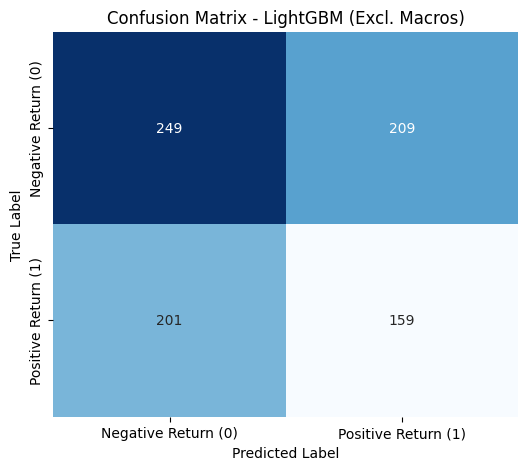

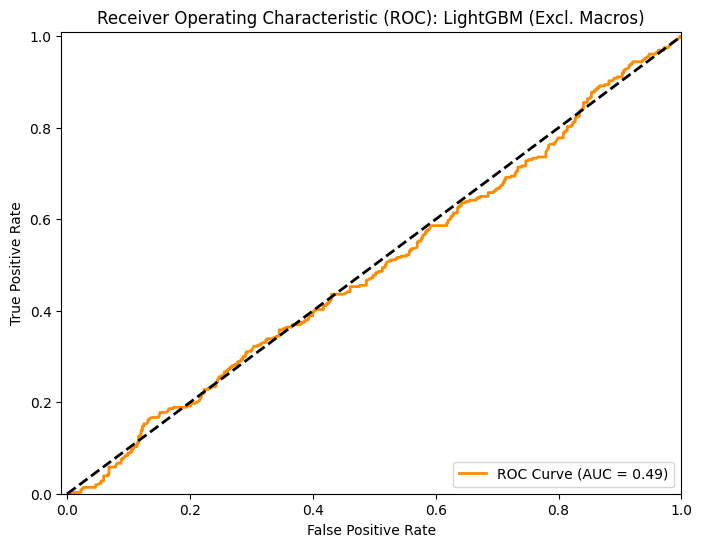


Investment Strategy Metrics for Test Period (Model 7.2 - Excluding Macro):
RoI: -0.525140
Volatility: 0.191049
Sharpe Ratio: -1.200896
Sortino Ratio: -1.330407
Calmar Ratio: -0.413455

D-Ratio and related metrics for Test Period (Model 7.2 - Excluding Macro):
D-Ratio for Full Period: 0.625393
D-Ratio for First Period: 1.022632
D-Ratio for Second Period: 0.407920
MSE (Model 7.2 - Excluding Macro): 0.249842
RMSE (Model 7.2 - Excluding Macro): 0.499842
MAE (Model 7.2 - Excluding Macro): 0.499804
MAPE (Model 7.2 - Excluding Macro): 50.159901%


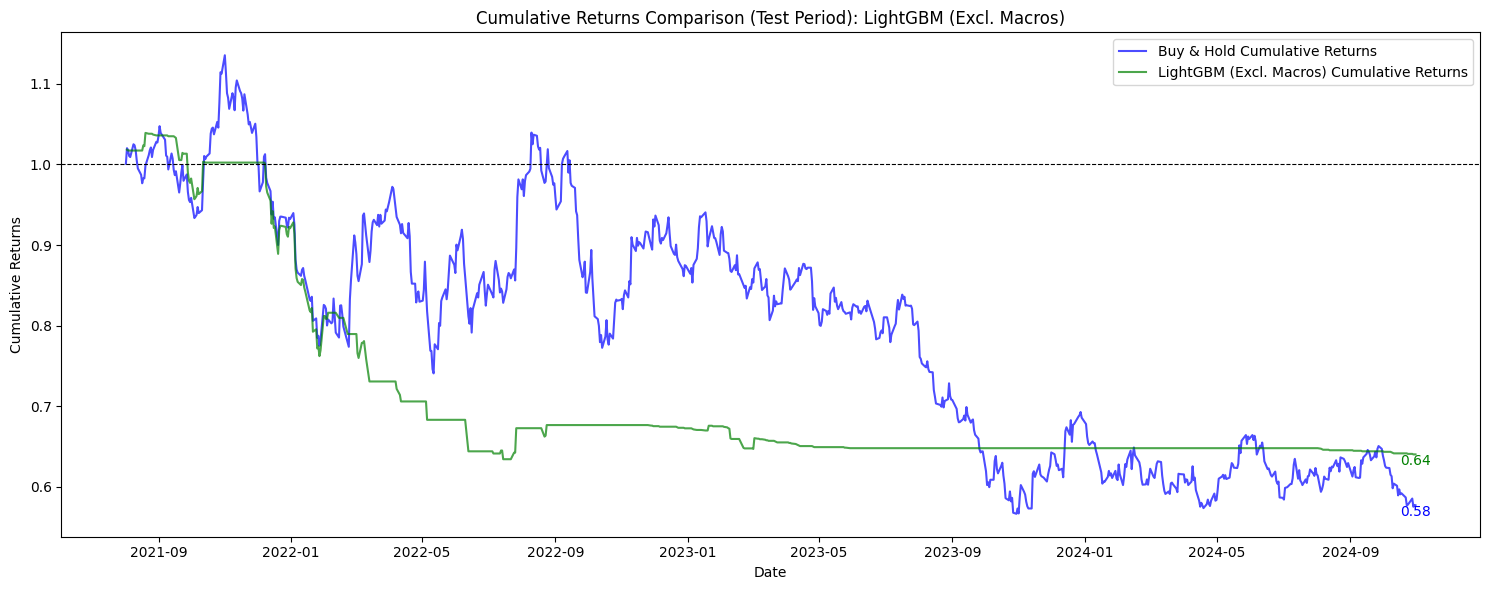

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


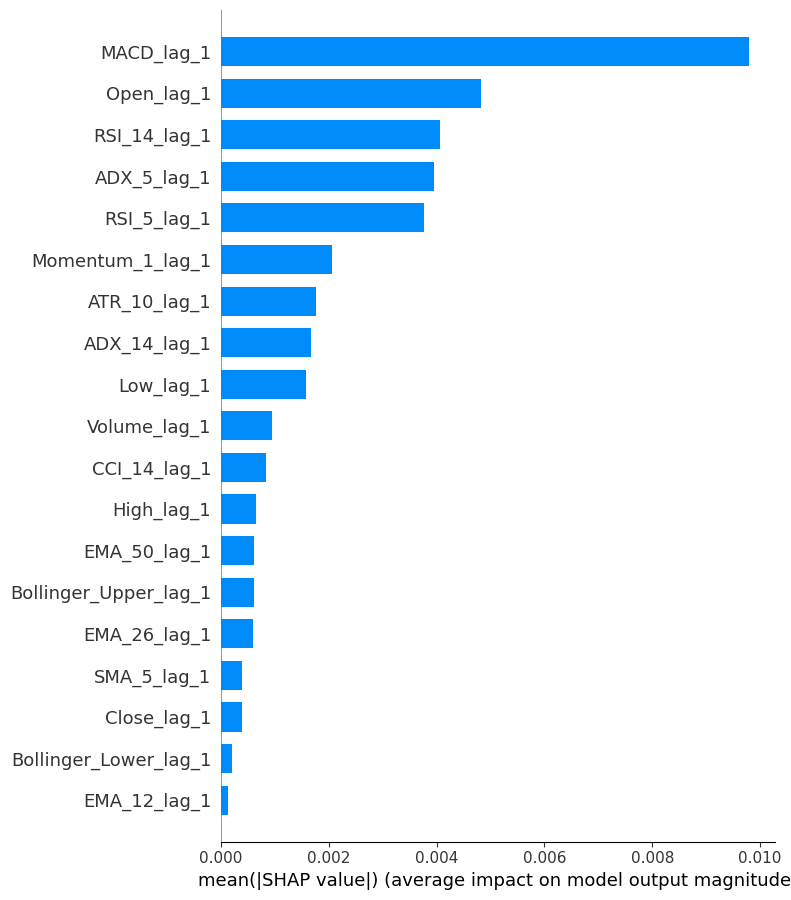

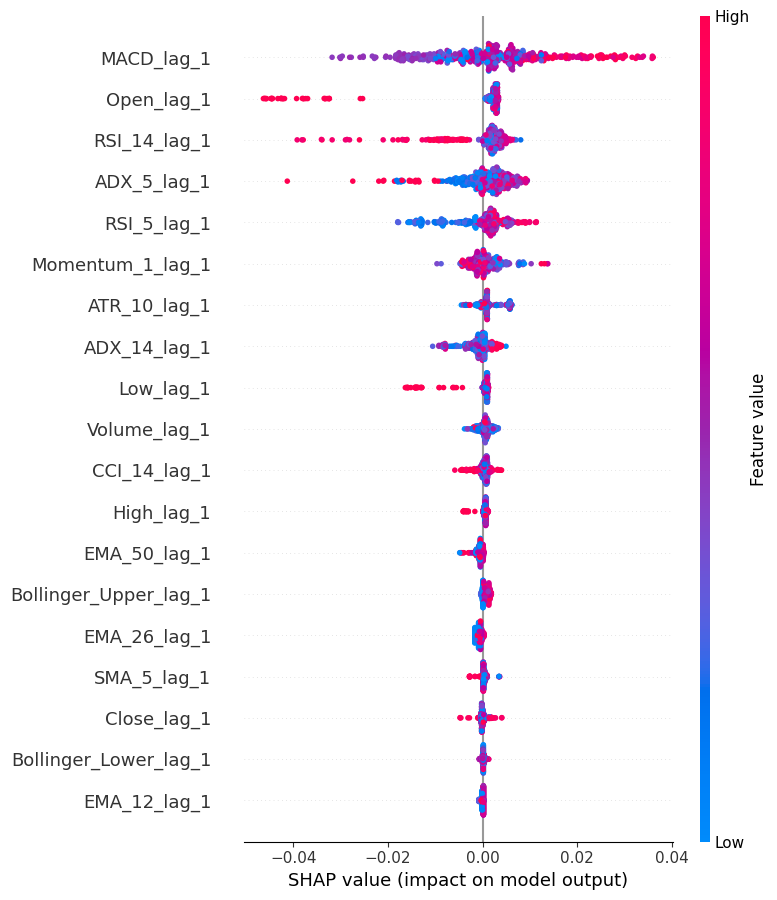


SHAP Summary Values (Bar Chart Data) - Model 7.2 (Excluding Macro Features):
                  Feature  Mean Absolute SHAP Value
9              MACD_lag_1                  0.009793
0              Open_lag_1                  0.004824
17           RSI_14_lag_1                  0.004058
14            ADX_5_lag_1                  0.003949
16            RSI_5_lag_1                  0.003767
18       Momentum_1_lag_1                  0.002063
13           ATR_10_lag_1                  0.001764
15           ADX_14_lag_1                  0.001662
2               Low_lag_1                  0.001584
4            Volume_lag_1                  0.000953
12           CCI_14_lag_1                  0.000833
1              High_lag_1                  0.000656
8            EMA_50_lag_1                  0.000622
10  Bollinger_Upper_lag_1                  0.000611
7            EMA_26_lag_1                  0.000593
5             SMA_5_lag_1                  0.000390
3             Close_lag_1             

In [ ]:
# ============================================
# 7.2: LightGBM Model Without Macroeconomic Indicators
# ============================================

# Define feature columns excluding macroeconomic indicators
features_excluding_macro = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5', 'EMA_12', 'EMA_26', 'EMA_50',
    'MACD', 'Bollinger_Upper', 'Bollinger_Lower',
    'CCI_14', 'ATR_10', 'ADX_5', 'ADX_14',
    'RSI_5', 'RSI_14', 'Momentum_1'
]

# Create lagged features excluding macroeconomic indicators
lagged_features_excluding_macro = [feature + '_lag_1' for feature in features_excluding_macro]

# Define the features and target for classification using existing sets
X_train_lgb_7_2 = train_set[lagged_features_excluding_macro]
y_train_lgb_7_2 = train_set['Target']

X_validation_lgb_7_2 = validation_set[lagged_features_excluding_macro]
y_validation_lgb_7_2 = validation_set['Target']

X_test_lgb_7_2 = test_set[lagged_features_excluding_macro]
y_test_lgb_7_2 = test_set['Target']

# Combine training and validation sets for final training
X_train_full_lgb_7_2 = pd.concat([X_train_lgb_7_2, X_validation_lgb_7_2])
y_train_full_lgb_7_2 = pd.concat([y_train_lgb_7_2, y_validation_lgb_7_2])

# Train the model with the best parameters
lgb_model_7_2 = LGBMClassifier(
    objective='binary',
    random_state=SEED,
    **best_params_lgb
)

lgb_model_7_2.fit(X_train_full_lgb_7_2, y_train_full_lgb_7_2)

# Make predictions with the best model
y_pred_proba_lgb_7_2 = lgb_model_7_2.predict_proba(X_test_lgb_7_2)[:, 1]

# Set a probability threshold for classification
y_pred_class_lgb_7_2 = (y_pred_proba_lgb_7_2 >= threshold).astype(int)

# Positions based on predicted class
positions_lgb_7_2 = pd.Series(y_pred_class_lgb_7_2, index=X_test_lgb_7_2.index)

# Calculate strategy returns by multiplying actual returns with positions
strategy_returns_lgb_7_2 = test_set['ICLN_Return'] * positions_lgb_7_2

# Apply transaction costs when positions change (buying or selling)
position_changes_lgb_7_2 = positions_lgb_7_2.diff().abs()
position_changes_lgb_7_2.iloc[0] = positions_lgb_7_2.iloc[0]
transaction_costs_lgb_7_2 = transaction_cost_rate * position_changes_lgb_7_2
net_strategy_returns_lgb_7_2 = strategy_returns_lgb_7_2 - transaction_costs_lgb_7_2

# Classification Metrics for Model 7.2
accuracy_lgb_7_2 = accuracy_score(y_test_lgb_7_2, y_pred_class_lgb_7_2)
print(f"\nAccuracy (Model 7.2 - Excluding Macro): {accuracy_lgb_7_2:.4f}")

print("\nClassification Report (Model 7.2 - Excluding Macro):")
print(classification_report(y_test_lgb_7_2, y_pred_class_lgb_7_2))

# Confusion Matrix
cm_lgb_7_2 = confusion_matrix(y_test_lgb_7_2, y_pred_class_lgb_7_2)
print("\nConfusion Matrix (Model 7.2 - Excluding Macro):")
print(cm_lgb_7_2)

# Plot Confusion Matrix for Model 7.2
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgb_7_2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative Return (0)', 'Positive Return (1)'],
            yticklabels=['Negative Return (0)', 'Positive Return (1)'])
plt.title('Confusion Matrix - LightGBM (Excl. Macros)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve for Model 7.2
fpr_lgb_7_2, tpr_lgb_7_2, _ = roc_curve(y_test_lgb_7_2, y_pred_proba_lgb_7_2)
roc_auc_lgb_7_2 = auc(fpr_lgb_7_2, tpr_lgb_7_2)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb_7_2, tpr_lgb_7_2, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_lgb_7_2:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC): LightGBM (Excl. Macros)')
plt.legend(loc='lower right')
plt.show()

# Investment Performance Metrics for Model 7.2
roi_lgb_7_2 = np.exp(np.sum(net_strategy_returns_lgb_7_2)) - 1
volatility_lgb_7_2 = np.std(net_strategy_returns_lgb_7_2) * np.sqrt(252)
mean_return_lgb_7_2 = np.mean(net_strategy_returns_lgb_7_2) * 252
sharpe_ratio_lgb_7_2 = mean_return_lgb_7_2 / volatility_lgb_7_2

downside_returns_lgb_7_2 = net_strategy_returns_lgb_7_2[net_strategy_returns_lgb_7_2 < 0]
downside_volatility_lgb_7_2 = np.std(downside_returns_lgb_7_2) * np.sqrt(252)
sortino_ratio_lgb_7_2 = mean_return_lgb_7_2 / downside_volatility_lgb_7_2 if downside_volatility_lgb_7_2 > 0 else np.nan

cumulative_returns_lgb_7_2 = np.exp(net_strategy_returns_lgb_7_2.cumsum())
max_drawdown_lgb_7_2 = (cumulative_returns_lgb_7_2.cummax() - cumulative_returns_lgb_7_2).max()
calmar_ratio_lgb_7_2 = mean_return_lgb_7_2 / max_drawdown_lgb_7_2 if max_drawdown_lgb_7_2 > 0 else np.nan

# D-Ratio Calculation for Model 7.2
d_ratios_lgb_7_2 = get_d_ratio(returns_bh, net_strategy_returns_lgb_7_2)

# MSE, RMSE, MAE, MAPE Calculations for Model 7.2
mse_lgb_7_2 = mean_squared_error(y_test_lgb_7_2, y_pred_proba_lgb_7_2)
rmse_lgb_7_2 = np.sqrt(mse_lgb_7_2)
mae_lgb_7_2 = mean_absolute_error(y_test_lgb_7_2, y_pred_proba_lgb_7_2)

valid_indices_lgb_7_2 = y_test_lgb_7_2.abs() > epsilon
mape_lgb_7_2 = (
    np.mean(np.abs((y_test_lgb_7_2[valid_indices_lgb_7_2] - y_pred_proba_lgb_7_2[valid_indices_lgb_7_2]) / y_test_lgb_7_2[valid_indices_lgb_7_2])) * 100
    if valid_indices_lgb_7_2.any()
    else np.nan
)

print("\nInvestment Strategy Metrics for Test Period (Model 7.2 - Excluding Macro):")
print(f"RoI: {roi_lgb_7_2:.6f}")
print(f"Volatility: {volatility_lgb_7_2:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio_lgb_7_2:.6f}")
print(f"Sortino Ratio: {sortino_ratio_lgb_7_2:.6f}")
print(f"Calmar Ratio: {calmar_ratio_lgb_7_2:.6f}")

print("\nD-Ratio and related metrics for Test Period (Model 7.2 - Excluding Macro):")
print(f"D-Ratio for Full Period: {d_ratios_lgb_7_2[0, 0]:.6f}")
print(f"D-Ratio for First Period: {d_ratios_lgb_7_2[0, 1]:.6f}")
print(f"D-Ratio for Second Period: {d_ratios_lgb_7_2[0, 2]:.6f}")

print(f"MSE (Model 7.2 - Excluding Macro): {mse_lgb_7_2:.6f}")
print(f"RMSE (Model 7.2 - Excluding Macro): {rmse_lgb_7_2:.6f}")
print(f"MAE (Model 7.2 - Excluding Macro): {mae_lgb_7_2:.6f}")
print(f"MAPE (Model 7.2 - Excluding Macro): {mape_lgb_7_2:.6f}%")

# Plot cumulative returns for Buy & Hold and LightGBM Strategy
plt.figure(figsize=(15, 6))
plt.plot(cumulative_returns_bh.index, cumulative_returns_bh,
         label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7)
plt.plot(cumulative_returns_strategy_7_1.index, cumulative_returns_strategy_7_1,
         label='LightGBM (Excl. Macros) Cumulative Returns', color='green', alpha=0.7)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8)

# Annotate the last value for Buy & Hold
last_value_bh = cumulative_returns_bh.iloc[-1]
last_date_bh = cumulative_returns_bh.index[-1]
plt.text(last_date_bh, last_value_bh, f'{last_value_bh:.2f}',
         color='blue', fontsize=10,
         verticalalignment='bottom' if last_value_bh >= 1 else 'top',
         horizontalalignment='center')

# Annotate the last value for LightGBM Strategy
last_value_lgbm = cumulative_returns_strategy_7_1.iloc[-1]
last_date_lgbm = cumulative_returns_strategy_7_1.index[-1]
plt.text(last_date_lgbm, last_value_lgbm, f'{last_value_lgbm:.2f}',
         color='green', fontsize=10,
         verticalalignment='bottom' if last_value_lgbm >= 1 else 'top',
         horizontalalignment='center')

# Add titles and labels
plt.title('Cumulative Returns Comparison (Test Period): LightGBM (Excl. Macros)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.tight_layout()
plt.show()

# SHAP Analysis for Model 7.2
shap.initjs()
explainer_lgb_7_2 = shap.TreeExplainer(lgb_model_7_2)

if len(X_test_lgb_7_2) > sample_size:
    X_test_sample_lgb_7_2 = X_test_lgb_7_2.sample(sample_size, random_state=SEED)
else:
    X_test_sample_lgb_7_2 = X_test_lgb_7_2

shap_values_lgb_7_2 = explainer_lgb_7_2.shap_values(X_test_sample_lgb_7_2)

# SHAP summary plot (bar)
shap.summary_plot(shap_values_lgb_7_2, X_test_sample_lgb_7_2, plot_type="bar", max_display=20)

# SHAP summary plot (beeswarm)
shap.summary_plot(shap_values_lgb_7_2, X_test_sample_lgb_7_2, max_display=20)

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values_lgb_7_2 = np.abs(shap_values_lgb_7_2).mean(axis=0)

# Create a DataFrame for SHAP summary
shap_summary_df_lgb_7_2 = pd.DataFrame({
    'Feature': X_test_sample_lgb_7_2.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values_lgb_7_2
}).sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Display the SHAP summary DataFrame
print("\nSHAP Summary Values (Bar Chart Data) - Model 7.2 (Excluding Macro Features):")
print(shap_summary_df_lgb_7_2)

# Extract the top 15 features based on SHAP values
top_15_features_lgb_7_2 = shap_summary_df_lgb_7_2['Feature'].head(15).tolist()

print("\nTop 15 Features Based on SHAP Values (Model 7.2 - Excluding Macro Features):")
print(top_15_features_lgb_7_2)


Combined Features (Lagged Non-Macro + Top 10 Macro):
['Open_lag_1', 'High_lag_1', 'Low_lag_1', 'Close_lag_1', 'Volume_lag_1', 'SMA_5_lag_1', 'EMA_12_lag_1', 'EMA_26_lag_1', 'EMA_50_lag_1', 'MACD_lag_1', 'Bollinger_Upper_lag_1', 'Bollinger_Lower_lag_1', 'CCI_14_lag_1', 'ATR_10_lag_1', 'ADX_5_lag_1', 'ADX_14_lag_1', 'RSI_5_lag_1', 'RSI_14_lag_1', 'Momentum_1_lag_1', 'VIX_lag_1', 'Oil_Prices_lag_1m_lag_1', 'Natural_Gas_Prices_lag_1m_lag_1', 'Oil_Prices_lag_1', 'Interest_Rates_lag_1m_lag_1', 'Oil_Prices_lag_1w_lag_1', 'Gold_Prices_lag_1', 'VIX_lag_1w_lag_1', 'Interest_Rates_lag_1w_lag_1', 'Gold_Prices_lag_1m_lag_1']
[LightGBM] [Info] Number of positive: 1630, number of negative: 1647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 3277, number of used features: 29
[LightGBM] [Info] [bin

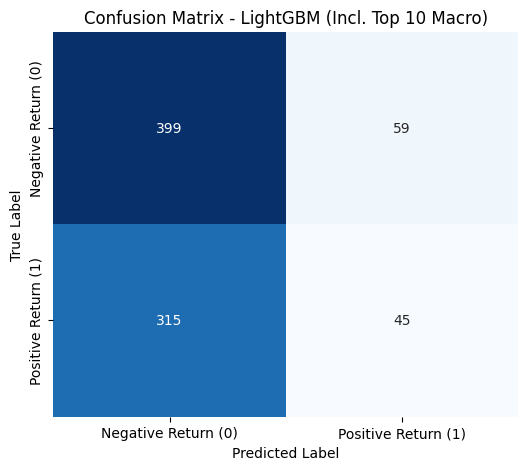

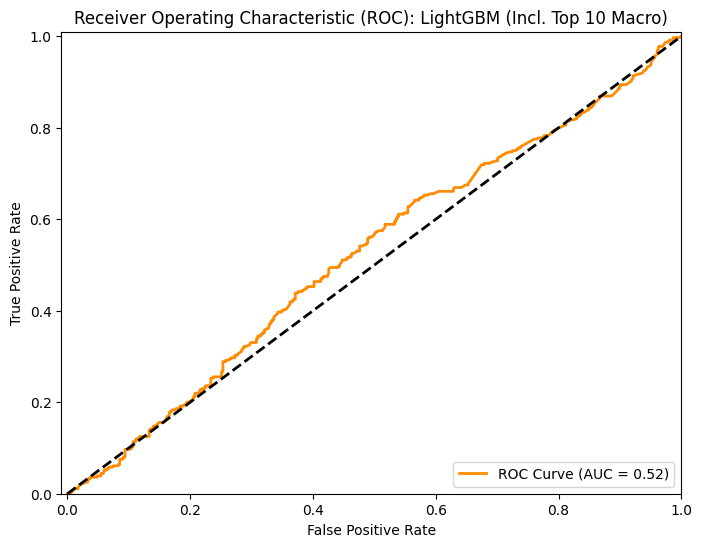


Investment Strategy Metrics for Test Period (Model 7.3 - Combined Features):
RoI: -0.218682
Volatility: 0.088382
Sharpe Ratio: -0.860170
Sortino Ratio: -0.489403
Calmar Ratio: -0.278383

D-Ratio and related metrics for Test Period (Model 7.3 - Combined Features):
D-Ratio for Full Period: 1.531798
D-Ratio for First Period: 1.594125
D-Ratio for Second Period: 1.179085
MSE (Model 7.3 - Combined Features): 0.248739
RMSE (Model 7.3 - Combined Features): 0.498737
MAE (Model 7.3 - Combined Features): 0.498594
MAPE (Model 7.3 - Combined Features): 50.837429%


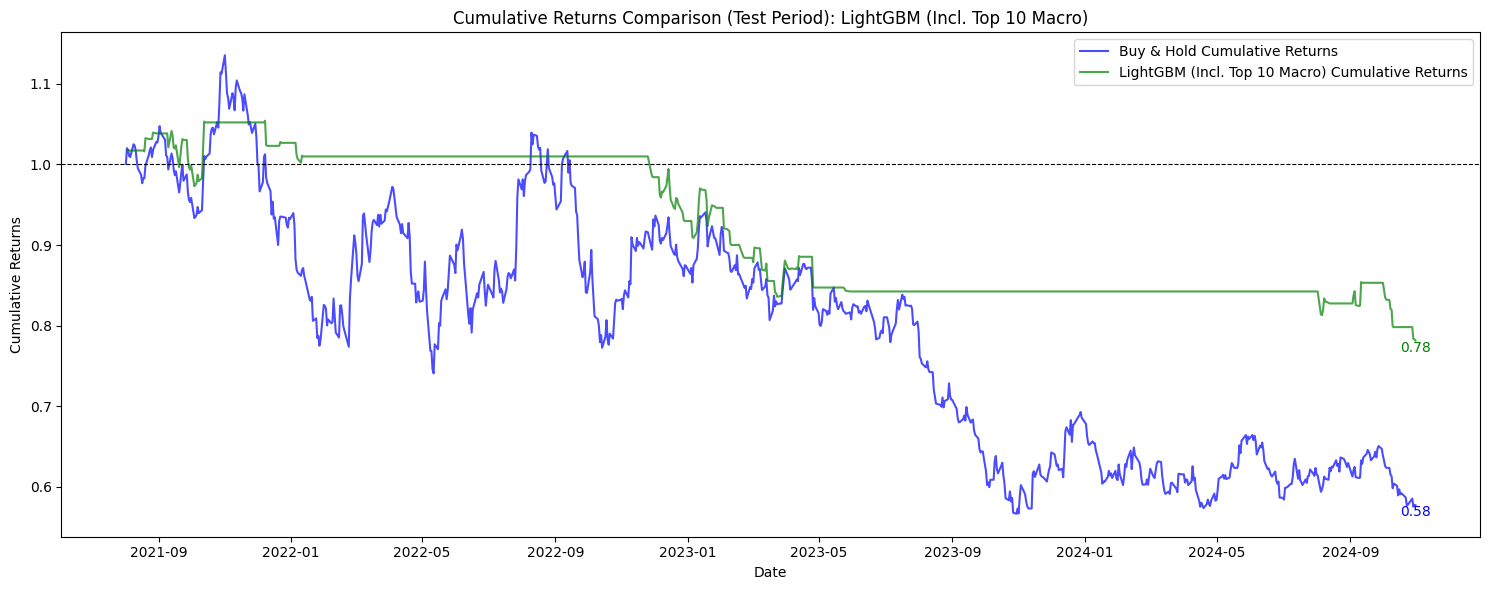

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


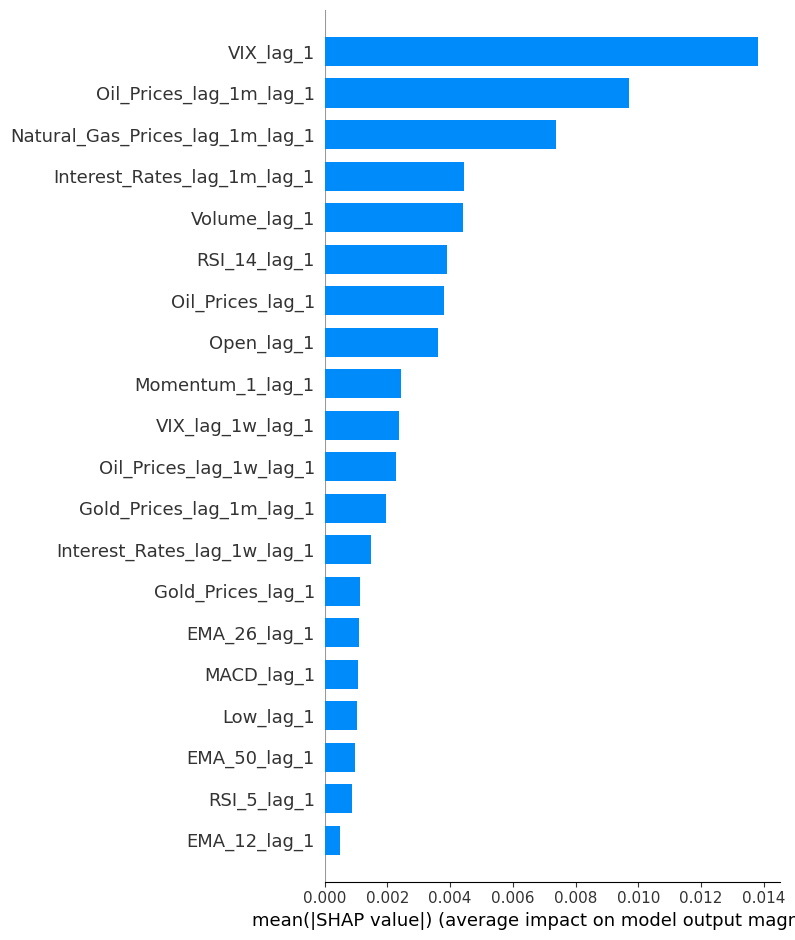

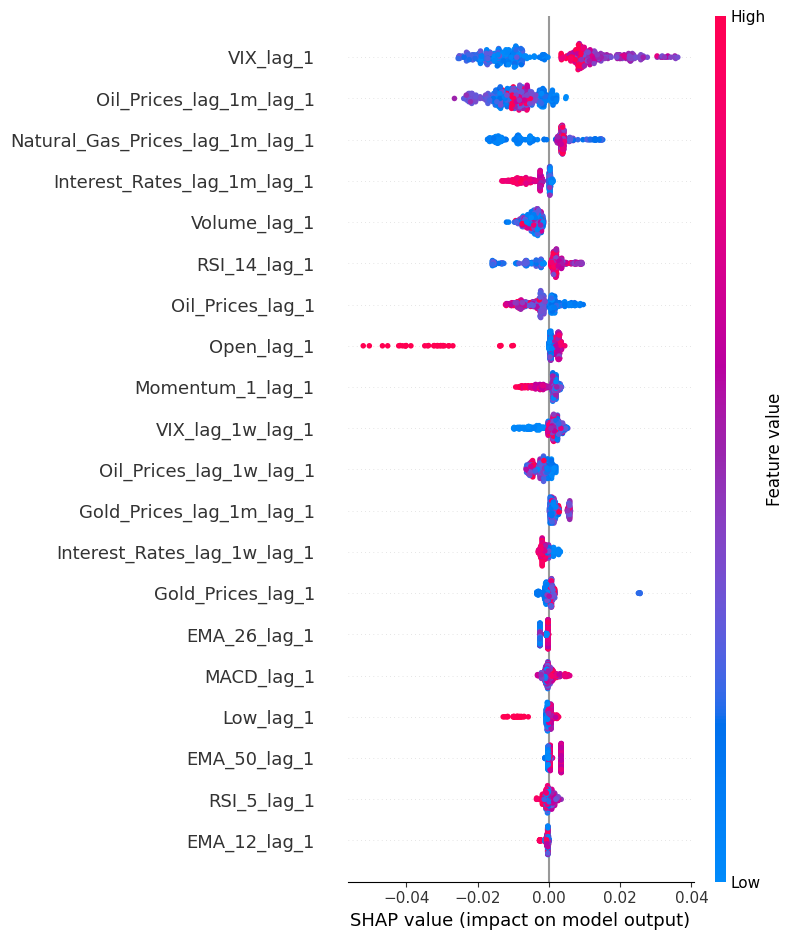


SHAP Summary Values (Bar Chart Data) - Model 7.3 (Combined Features):
                            Feature  Mean Absolute SHAP Value
19                        VIX_lag_1                  0.013825
20          Oil_Prices_lag_1m_lag_1                  0.009706
21  Natural_Gas_Prices_lag_1m_lag_1                  0.007378
23      Interest_Rates_lag_1m_lag_1                  0.004445
4                      Volume_lag_1                  0.004407
17                     RSI_14_lag_1                  0.003902
22                 Oil_Prices_lag_1                  0.003799
0                        Open_lag_1                  0.003612
18                 Momentum_1_lag_1                  0.002426
26                 VIX_lag_1w_lag_1                  0.002376
24          Oil_Prices_lag_1w_lag_1                  0.002289
28         Gold_Prices_lag_1m_lag_1                  0.001964
27      Interest_Rates_lag_1w_lag_1                  0.001469
25                Gold_Prices_lag_1                  0.001117

In [ ]:
# ============================================
# 7.3: LightGBM Model With Top 10 Macroeconomic Indicators + Lagged Non-Macro Features
# ============================================

# Combine lagged non-macro features and top 105 macroeconomic features
combined_features_lgb_7_3 = lagged_features_excluding_macro + lgb_top_10_macrofeatures


print("\nCombined Features (Lagged Non-Macro + Top 10 Macro):")
print(combined_features_lgb_7_3)

# Subset existing datasets with the combined feature set
X_train_combined_lgb_7_3 = X_train_full[combined_features_lgb_7_3]
X_validation_combined_lgb_7_3 = X_validation[combined_features_lgb_7_3]
X_test_combined_lgb_7_3 = X_test[combined_features_lgb_7_3]

# Train the model with the best parameters
lgb_model_7_3 = LGBMClassifier(
    objective='binary',
    random_state=SEED,
    **best_params_lgb
)

lgb_model_7_3.fit(X_train_combined_lgb_7_3, y_train_full)

# Make predictions with the best model
y_pred_proba_lgb_7_3 = lgb_model_7_3.predict_proba(X_test_combined_lgb_7_3)[:, 1]

# Set a probability threshold for classification
y_pred_class_lgb_7_3 = (y_pred_proba_lgb_7_3 >= threshold).astype(int)

# Positions based on predicted class
positions_lgb_7_3 = pd.Series(y_pred_class_lgb_7_3, index=X_test_combined_lgb_7_3.index)

# Calculate strategy returns by multiplying actual returns with positions
strategy_returns_lgb_7_3 = test_set['ICLN_Return'] * positions_lgb_7_3

# Apply transaction costs when positions change (buying or selling)
position_changes_lgb_7_3 = positions_lgb_7_3.diff().abs()
position_changes_lgb_7_3.iloc[0] = positions_lgb_7_3.iloc[0]
transaction_costs_lgb_7_3 = transaction_cost_rate * position_changes_lgb_7_3
net_strategy_returns_lgb_7_3 = strategy_returns_lgb_7_3 - transaction_costs_lgb_7_3

# Classification Metrics for Model 7.3
accuracy_lgb_7_3 = accuracy_score(y_test, y_pred_class_lgb_7_3)
print(f"\nAccuracy (Model 7.3 - Combined Features): {accuracy_lgb_7_3:.4f}")

print("\nClassification Report (Model 7.3 - Combined Features):")
print(classification_report(y_test, y_pred_class_lgb_7_3))

# Confusion Matrix
cm_lgb_7_3 = confusion_matrix(y_test, y_pred_class_lgb_7_3)
print("\nConfusion Matrix (Model 7.3 - Combined Features):")
print(cm_lgb_7_3)

# Plot Confusion Matrix for Model 7.3
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgb_7_3, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative Return (0)', 'Positive Return (1)'],
            yticklabels=['Negative Return (0)', 'Positive Return (1)'])
plt.title('Confusion Matrix - LightGBM (Incl. Top 10 Macro)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve for Model 7.3
fpr_lgb_7_3, tpr_lgb_7_3, _ = roc_curve(y_test, y_pred_proba_lgb_7_3)
roc_auc_lgb_7_3 = auc(fpr_lgb_7_3, tpr_lgb_7_3)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb_7_3, tpr_lgb_7_3, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_lgb_7_3:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC): LightGBM (Incl. Top 10 Macro)')
plt.legend(loc='lower right')
plt.show()

# Investment Performance Metrics for Model 7.3
roi_lgb_7_3 = np.exp(np.sum(net_strategy_returns_lgb_7_3)) - 1
volatility_lgb_7_3 = np.std(net_strategy_returns_lgb_7_3) * np.sqrt(252)
mean_return_lgb_7_3 = np.mean(net_strategy_returns_lgb_7_3) * 252
sharpe_ratio_lgb_7_3 = mean_return_lgb_7_3 / volatility_lgb_7_3

downside_returns_lgb_7_3 = net_strategy_returns_lgb_7_3[net_strategy_returns_lgb_7_3 < 0]
downside_volatility_lgb_7_3 = np.std(downside_returns_lgb_7_3) * np.sqrt(252)
sortino_ratio_lgb_7_3 = mean_return_lgb_7_3 / downside_volatility_lgb_7_3 if downside_volatility_lgb_7_3 > 0 else np.nan

cumulative_returns_lgb_7_3 = np.exp(net_strategy_returns_lgb_7_3.cumsum())
max_drawdown_lgb_7_3 = (cumulative_returns_lgb_7_3.cummax() - cumulative_returns_lgb_7_3).max()
calmar_ratio_lgb_7_3 = mean_return_lgb_7_3 / max_drawdown_lgb_7_3 if max_drawdown_lgb_7_3 > 0 else np.nan

# D-Ratio Calculation for Model 7.3
d_ratios_lgb_7_3 = get_d_ratio(returns_bh, net_strategy_returns_lgb_7_3)

# MSE, RMSE, MAE, MAPE Calculations for Model 7.3
mse_lgb_7_3 = mean_squared_error(y_test, y_pred_proba_lgb_7_3)
rmse_lgb_7_3 = np.sqrt(mse_lgb_7_3)
mae_lgb_7_3 = mean_absolute_error(y_test, y_pred_proba_lgb_7_3)

valid_indices_lgb_7_3 = y_test.abs() > epsilon
mape_lgb_7_3 = (
    np.mean(np.abs((y_test[valid_indices_lgb_7_3] - y_pred_proba_lgb_7_3[valid_indices_lgb_7_3]) / y_test[valid_indices_lgb_7_3])) * 100
    if valid_indices_lgb_7_3.any()
    else np.nan
)

print("\nInvestment Strategy Metrics for Test Period (Model 7.3 - Combined Features):")
print(f"RoI: {roi_lgb_7_3:.6f}")
print(f"Volatility: {volatility_lgb_7_3:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio_lgb_7_3:.6f}")
print(f"Sortino Ratio: {sortino_ratio_lgb_7_3:.6f}")
print(f"Calmar Ratio: {calmar_ratio_lgb_7_3:.6f}")

print("\nD-Ratio and related metrics for Test Period (Model 7.3 - Combined Features):")
print(f"D-Ratio for Full Period: {d_ratios_lgb_7_3[0, 0]:.6f}")
print(f"D-Ratio for First Period: {d_ratios_lgb_7_3[0, 1]:.6f}")
print(f"D-Ratio for Second Period: {d_ratios_lgb_7_3[0, 2]:.6f}")

print(f"MSE (Model 7.3 - Combined Features): {mse_lgb_7_3:.6f}")
print(f"RMSE (Model 7.3 - Combined Features): {rmse_lgb_7_3:.6f}")
print(f"MAE (Model 7.3 - Combined Features): {mae_lgb_7_3:.6f}")
print(f"MAPE (Model 7.3 - Combined Features): {mape_lgb_7_3:.6f}%")

# Plot Cumulative Returns for Model 7.3
plt.figure(figsize=(15, 6))

# Plot Buy & Hold Cumulative Returns
plt.plot(cumulative_returns_bh.index, cumulative_returns_bh,
         label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7)

# Plot LightGBM Cumulative Returns (Combined Features)
plt.plot(cumulative_returns_lgb_7_3.index, cumulative_returns_lgb_7_3,
         label='LightGBM (Incl. Top 10 Macro) Cumulative Returns', color='green', alpha=0.7)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8)

# Annotate the last value for Buy & Hold
last_value_bh = cumulative_returns_bh.iloc[-1]
last_date_bh = cumulative_returns_bh.index[-1]
plt.text(last_date_bh, last_value_bh, f'{last_value_bh:.2f}',
         color='blue', fontsize=10,
         verticalalignment='bottom' if last_value_bh >= 1 else 'top',
         horizontalalignment='center')

# Annotate the last value for LightGBM (Combined Features) Strategy
last_value_lgbm = cumulative_returns_lgb_7_3.iloc[-1]
last_date_lgbm = cumulative_returns_lgb_7_3.index[-1]
plt.text(last_date_lgbm, last_value_lgbm, f'{last_value_lgbm:.2f}',
         color='green', fontsize=10,
         verticalalignment='bottom' if last_value_lgbm >= 1 else 'top',
         horizontalalignment='center')

# Add titles and labels
plt.title('Cumulative Returns Comparison (Test Period): LightGBM (Incl. Top 10 Macro)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.tight_layout()
plt.show()


# SHAP Analysis for Model 7.3
shap.initjs()
explainer_lgb_7_3 = shap.TreeExplainer(lgb_model_7_3)

if len(X_test_combined_lgb_7_3) > sample_size:
    X_test_sample_lgb_7_3 = X_test_combined_lgb_7_3.sample(sample_size, random_state=SEED)
else:
    X_test_sample_lgb_7_3 = X_test_combined_lgb_7_3

shap_values_lgb_7_3 = explainer_lgb_7_3.shap_values(X_test_sample_lgb_7_3)

# SHAP summary plot (bar)
shap.summary_plot(shap_values_lgb_7_3, X_test_sample_lgb_7_3, plot_type="bar", max_display=20)

# SHAP summary plot (beeswarm)
shap.summary_plot(shap_values_lgb_7_3, X_test_sample_lgb_7_3, max_display=20)

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values_lgb_7_3 = np.abs(shap_values_lgb_7_3).mean(axis=0)

# Create a DataFrame for SHAP summary
shap_summary_df_lgb_7_3 = pd.DataFrame({
    'Feature': X_test_sample_lgb_7_3.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values_lgb_7_3
}).sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Display the SHAP summary DataFrame
print("\nSHAP Summary Values (Bar Chart Data) - Model 7.3 (Combined Features):")
print(shap_summary_df_lgb_7_3)


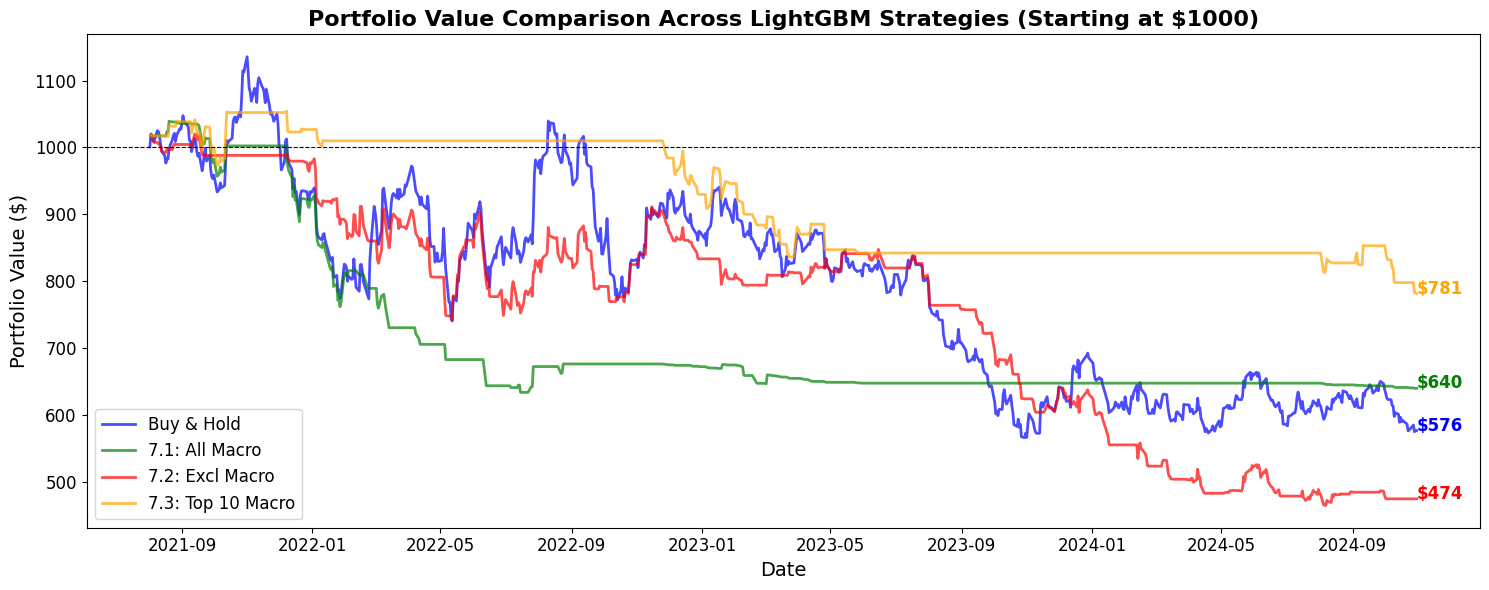


Summary of Final Portfolio Values and Metrics for LightGBM Strategies:
            Strategy  Final Portfolio Value    ROI (%)  Volatility (%)  \
0         Buy & Hold                    576 -42.316156       28.107425   
1     7.1: All Macro                    640 -35.997632       10.043824   
2    7.2: Excl Macro                    474 -52.514028       19.104873   
3  7.3: Top 10 Macro                    781 -21.868230        8.838151   

   Sharpe Ratio  Sortino Ratio  Calmar Ratio  D-Ratio (Full Period)       MSE  \
0     -0.602297      -1.028590     -0.297338               1.000000       NaN   
1     -1.368757      -0.732890     -0.339301               0.746080  0.248692   
2     -1.200896      -1.330407     -0.413455               0.625393  0.249842   
3     -0.860170      -0.489403     -0.278383               1.531798  0.248739   

       RMSE       MAE   MAPE (%)  Accuracy (%)  
0       NaN       NaN        NaN           NaN  
1  0.498379  0.498541  50.808082     55.256724  
2  0

In [ ]:
# ============================================
# 7.4 Summary for LightGBM Strategies
# ============================================

# Initial investment
initial_investment = 1000

# Cumulative Returns for Strategy 7.1 (All Macroeconomic Indicators)
cumulative_returns_strategy_7_1 = cumulative_returns_7_1
portfolio_value_strategy_7_1 = initial_investment * cumulative_returns_strategy_7_1

# Cumulative Returns for Strategy 7.2 (Excluding Macroeconomic Indicators)
cumulative_returns_strategy_7_2 = cumulative_returns_lgb_7_2
portfolio_value_strategy_7_2 = initial_investment * cumulative_returns_strategy_7_2

# Cumulative Returns for Strategy 7.3 (Top 10 Macroeconomic Indicators + Lagged Non-Macro)
cumulative_returns_strategy_7_3 = cumulative_returns_lgb_7_3
portfolio_value_strategy_7_3 = initial_investment * cumulative_returns_strategy_7_3

# Plot portfolio values comparison
plt.figure(figsize=(15, 6))
plt.plot(portfolio_value_bh.index, portfolio_value_bh, label='Buy & Hold', color='blue', alpha=0.7, linewidth=2)
plt.plot(portfolio_value_strategy_7_1.index, portfolio_value_strategy_7_1, label='7.1: All Macro', color='green', alpha=0.7, linewidth=2)
plt.plot(portfolio_value_strategy_7_2.index, portfolio_value_strategy_7_2, label='7.2: Excl Macro', color='red', alpha=0.7, linewidth=2)
plt.plot(portfolio_value_strategy_7_3.index, portfolio_value_strategy_7_3, label='7.3: Top 10 Macro', color='orange', alpha=0.7, linewidth=2)

# Adding text labels for the last value of each line
plt.text(portfolio_value_bh.index[-1], portfolio_value_bh.iloc[-1], f'${int(portfolio_value_bh.iloc[-1])}',
         color='blue', fontsize=12, weight='bold', ha='left')
plt.text(portfolio_value_strategy_7_1.index[-1], portfolio_value_strategy_7_1.iloc[-1], f'${int(portfolio_value_strategy_7_1.iloc[-1])}',
         color='green', fontsize=12, weight='bold', ha='left')
plt.text(portfolio_value_strategy_7_2.index[-1], portfolio_value_strategy_7_2.iloc[-1], f'${int(portfolio_value_strategy_7_2.iloc[-1])}',
         color='red', fontsize=12, weight='bold', ha='left')
plt.text(portfolio_value_strategy_7_3.index[-1], portfolio_value_strategy_7_3.iloc[-1], f'${int(portfolio_value_strategy_7_3.iloc[-1])}',
         color='orange', fontsize=12, weight='bold', ha='left')

# Baseline reference at $1000
plt.axhline(initial_investment, color='black', linestyle='--', linewidth=0.8)

plt.title('Portfolio Value Comparison Across LightGBM Strategies (Starting at $1000)', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(loc='lower left', fontsize=12, bbox_to_anchor=(0, 0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Summary of Final Portfolio Values and Metrics
metrics_comparison_lgb = {
    "Strategy": ["Buy & Hold", "7.1: All Macro", "7.2: Excl Macro", "7.3: Top 10 Macro"],
    "Final Portfolio Value": [
        int(portfolio_value_bh.iloc[-1]),
        int(portfolio_value_strategy_7_1.iloc[-1]),
        int(portfolio_value_strategy_7_2.iloc[-1]),
        int(portfolio_value_strategy_7_3.iloc[-1])
    ],
    "ROI (%)": [
        metrics_bh['RoI'] * 100,
        roi_7_1 * 100,
        roi_lgb_7_2 * 100,
        roi_lgb_7_3 * 100
    ],
    "Volatility (%)": [
        metrics_bh['Volatility'] * 100,
        volatility_7_1 * 100,
        volatility_lgb_7_2 * 100,
        volatility_lgb_7_3 * 100
    ],
    "Sharpe Ratio": [
        metrics_bh['Sharpe_Ratio'],
        sharpe_ratio_7_1,
        sharpe_ratio_lgb_7_2,
        sharpe_ratio_lgb_7_3
    ],
    "Sortino Ratio": [
        metrics_bh['Sortino_Ratio'],
        sortino_ratio_7_1,
        sortino_ratio_lgb_7_2,
        sortino_ratio_lgb_7_3
    ],
    "Calmar Ratio": [
        metrics_bh['Calmar_Ratio'],
        calmar_ratio_7_1,
        calmar_ratio_lgb_7_2,
        calmar_ratio_lgb_7_3
    ],
    "D-Ratio (Full Period)": [
        d_ratios[0, 0],
        d_ratios_lgb_7_1[0, 0],
        d_ratios_lgb_7_2[0, 0],
        d_ratios_lgb_7_3[0, 0]
    ],
    "MSE": [
        None,  # Not applicable for Buy & Hold
        mse_7_1,
        mse_lgb_7_2,
        mse_lgb_7_3
    ],
    "RMSE": [
        None,  # Not applicable for Buy & Hold
        rmse_7_1,
        rmse_lgb_7_2,
        rmse_lgb_7_3
    ],
    "MAE": [
        None,  # Not applicable for Buy & Hold
        mae_7_1,
        mae_lgb_7_2,
        mae_lgb_7_3
    ],
    "MAPE (%)": [
        None,  # Not applicable for Buy & Hold
        mape_7_1,
        mape_lgb_7_2,
        mape_lgb_7_3
    ],
    "Accuracy (%)": [
        None,  # Not applicable for Buy & Hold
        accuracy_7_1 * 100,
        accuracy_lgb_7_2 * 100,
        accuracy_lgb_7_3 * 100
    ]
}

# Convert to DataFrame
metrics_df_lgb = pd.DataFrame(metrics_comparison_lgb)

# Display the DataFrame
print("\nSummary of Final Portfolio Values and Metrics for LightGBM Strategies:")
print(metrics_df_lgb)
metrics_df_lgb

# List of strategy portfolio values for LightGBM strategies
strategy_values_lgb = [
    portfolio_value_strategy_7_1,
    portfolio_value_strategy_7_2,
    portfolio_value_strategy_7_3
]

# Corresponding strategy labels
strategy_labels_lgb = [
    "7.1: All Macro",
    "7.2: Excl Macro",
    "7.3: Top 10 Macro"
]

def calculate_outperformance_percentage(strategy_values, baseline_values, strategy_labels):
    """
    Calculate the percentage of time each strategy outperformed a baseline.

    Parameters:
        strategy_values (list of pd.Series): A list of portfolio value series for each strategy.
        baseline_values (pd.Series): The baseline portfolio value series (e.g., Buy & Hold).
        strategy_labels (list of str): Labels for the strategies for display purposes.

    Returns:
        dict: A dictionary with strategy labels as keys and outperformance percentages as values.
    """
    outperformance_results = {}

    for strategy_value, label in zip(strategy_values, strategy_labels):
        # Ensure indices are aligned
        aligned_strategy, aligned_baseline = strategy_value.align(baseline_values, join='inner')

        # Calculate whether the strategy outperformed the baseline at each time step
        outperform = aligned_strategy > aligned_baseline

        # Calculate the percentage of time outperformance occurred
        percent_outperform = (outperform.sum() / len(outperform)) * 100

        # Store results
        outperformance_results[label] = percent_outperform

    return outperformance_results

# Calculate the outperformance percentages for LightGBM strategies
outperformance_percentages_lgb = calculate_outperformance_percentage(strategy_values_lgb, portfolio_value_bh, strategy_labels_lgb)

# Display the results
for label, percentage in outperformance_percentages_lgb.items():
    print(f"Percentage of time {label} outperformed Buy & Hold: {percentage:.2f}%")


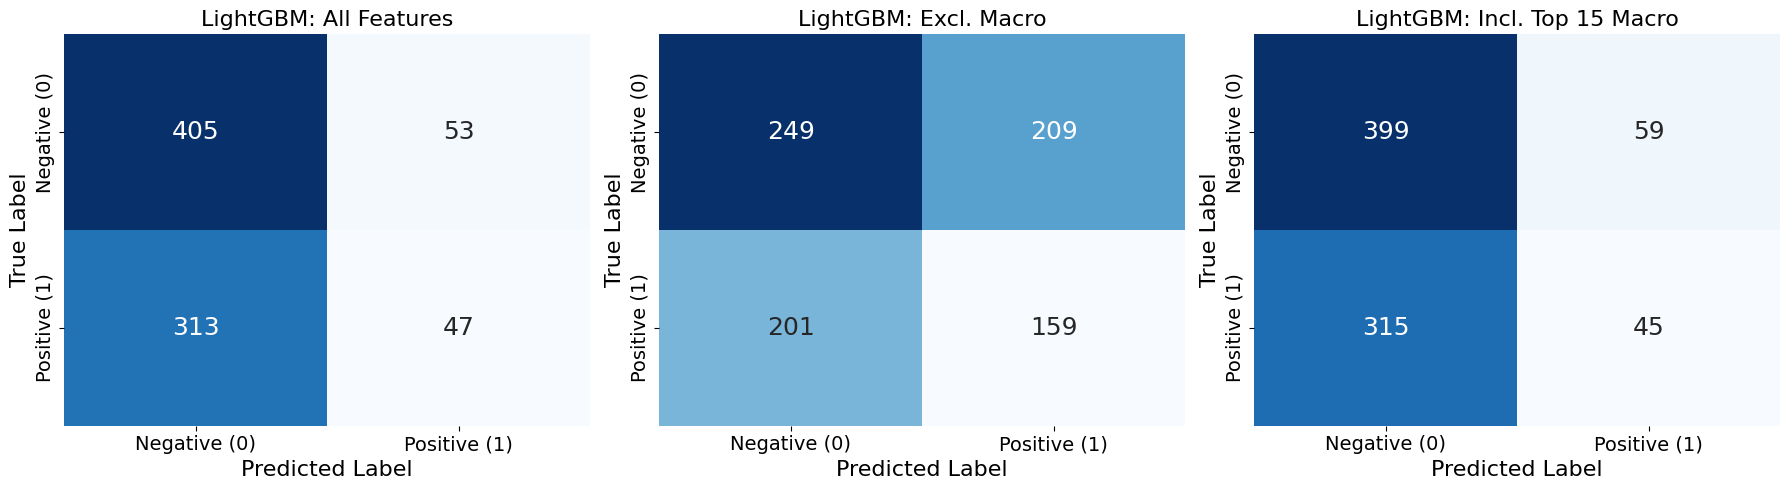

Metrics Baseline (B&H) LightGBM (All Macro)  \
0        Return on Investment         -42.3%               -36.0%   
1                  Volatility          28.1%                 0.10   
2                Sharpe Ratio      -0.602297            -1.368757   
3               Sortino Ratio       -1.02859             -0.73289   
4                Calmar Ratio      -0.297338            -0.339301   
5     D-Ratio for Full Period            1.0              0.74608   
6    D-Ratio for First Period            1.0             0.056624   
7   D-Ratio for Second Period            1.0                  N.A   
8                         MSE            N.A                24.9%   
9                        RMSE            N.A                49.8%   
10                        MAE            N.A                49.9%   
11                       MAPE            N.A                50.8%   
12                   Accuracy            N.A                55.3%   

   LightGBM (Excl. Macro) LightGBM (Top 10 Macro)  
0                  -52.5%                  -21.9%  
1                    0.19                    0.09  
2               -1.200896                -0.86017  
3               -1.330407               -0.489403  
4               -0.413455               -0.278383  
5                0.625393                1.531798  
6                1.022632                1.594125  
7                 0.40792                1.179085  
8                   25.0%                   24.9%  
9                   50.0%                   49.9%  
10                  50.0%                   49.9%  
11                  50.2%                   50.8%  
12                  49.9%                   54.3%

<Figure size 640x480 with 0 Axes>

In [ ]:

# ============================================
# 7.4 Summary for LightGBM Strategies (Confusion Matrix)
# ============================================


# List of confusion matrices and titles
confusion_matrices = [
    (cm_lgb_7_1, 'LightGBM: All Features'),
    (cm_lgb_7_2, 'LightGBM: Excl. Macro'),
    (cm_lgb_7_3, 'LightGBM: Incl. Top 15 Macro')
]

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (cm, title) in zip(axes, confusion_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative (0)', 'Positive (1)'],
                yticklabels=['Negative (0)', 'Positive (1)'],
                ax=ax,
                annot_kws={"size": 18})  # Set annotation font size

    # Set title with specific font size
    ax.set_title(title, fontsize=16)

    # Set x and y labels with specific font size
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)

    # Set tick labels font size
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()
plt.savefig('combined_confusion_matrices.png', dpi=300)

# Create a dictionary for the LightGBM strategy summary table
summary_table_lgb = {
    "Metrics": [
        "Return on Investment",
        "Volatility",
        "Sharpe Ratio",
        "Sortino Ratio",
        "Calmar Ratio",
        "D-Ratio for Full Period",
        "D-Ratio for First Period",
        "D-Ratio for Second Period",
        "MSE",
        "RMSE",
        "MAE",
        "MAPE",
        "Accuracy"
    ],
    "Baseline (B&H)": [
        f"{metrics_bh['RoI'] * 100:.1f}%",
        f"{metrics_bh['Volatility'] * 100:.1f}%",
        metrics_bh['Sharpe_Ratio'],
        metrics_bh['Sortino_Ratio'],
        metrics_bh['Calmar_Ratio'],
        d_ratios[0, 0],
        d_ratios[0, 1],
        d_ratios[0, 2],
        "N.A",
        "N.A",
        "N.A",
        "N.A",
        "N.A"
    ],
    "LightGBM (All Macro)": [
        f"{roi_7_1 * 100:.1f}%",
        f"{volatility_7_1:.2f}",
        sharpe_ratio_7_1,
        sortino_ratio_7_1,
        calmar_ratio_7_1,
        d_ratios_lgb_7_1[0, 0],
        d_ratios_lgb_7_1[0, 1],
        "N.A" if pd.isna(d_ratios_lgb_7_1[0, 2]) else d_ratios_lgb_7_1[0, 2],
        f"{mse_7_1 * 100:.1f}%",
        f"{rmse_7_1 * 100:.1f}%",
        f"{mae_7_1 * 100:.1f}%",
        f"{mape_7_1:.1f}%",
        f"{accuracy_7_1 * 100:.1f}%"
    ],
    "LightGBM (Excl. Macro)": [
        f"{roi_lgb_7_2 * 100:.1f}%",
        f"{volatility_lgb_7_2:.2f}",
        sharpe_ratio_lgb_7_2,
        sortino_ratio_lgb_7_2,
        calmar_ratio_lgb_7_2,
        d_ratios_lgb_7_2[0, 0],
        d_ratios_lgb_7_2[0, 1],
        "N.A" if pd.isna(d_ratios_lgb_7_2[0, 2]) else d_ratios_lgb_7_2[0, 2],
        f"{mse_lgb_7_2 * 100:.1f}%",
        f"{rmse_lgb_7_2 * 100:.1f}%",
        f"{mae_lgb_7_2 * 100:.1f}%",
        f"{mape_lgb_7_2:.1f}%",
        f"{accuracy_lgb_7_2 * 100:.1f}%"
    ],
    "LightGBM (Top 10 Macro)": [
        f"{roi_lgb_7_3 * 100:.1f}%",
        f"{volatility_lgb_7_3:.2f}",
        sharpe_ratio_lgb_7_3,
        sortino_ratio_lgb_7_3,
        calmar_ratio_lgb_7_3,
        d_ratios_lgb_7_3[0, 0],
        d_ratios_lgb_7_3[0, 1],
        "N.A" if pd.isna(d_ratios_lgb_7_3[0, 2]) else d_ratios_lgb_7_3[0, 2],
        f"{mse_lgb_7_3 * 100:.1f}%",
        f"{rmse_lgb_7_3 * 100:.1f}%",
        f"{mae_lgb_7_3 * 100:.1f}%",
        f"{mape_lgb_7_3:.1f}%",
        f"{accuracy_lgb_7_3 * 100:.1f}%"
    ],
}

# Convert the dictionary into a DataFrame
summary_df_lgb = pd.DataFrame(summary_table_lgb)
summary_df_lgb



Global random seed set to 42
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Hyperparameters:
Units: 32
Activation: sigmoid
Dropout Rate: 0.4
Optimizer: adam
Batch Size: 32
Epochs: 10

Accuracy (LSTM 8.1): 0.4988

Confusion Matrix - LSTM (All)
[[272 176]
 [227 129]]
AUC (LSTM 8.1): 0.4866

Classification Report (LSTM Model 8.1):
                     precision    recall  f1-score   support

Negative Return (0)       0.55      0.61      0.57       448
Positive Return (1)       0.42      0.36      0.39       356

           accuracy                           0.50       804
          macro avg       0.48      0.48      0.48       804
       weighted avg       0.49      0.50      0.49       804



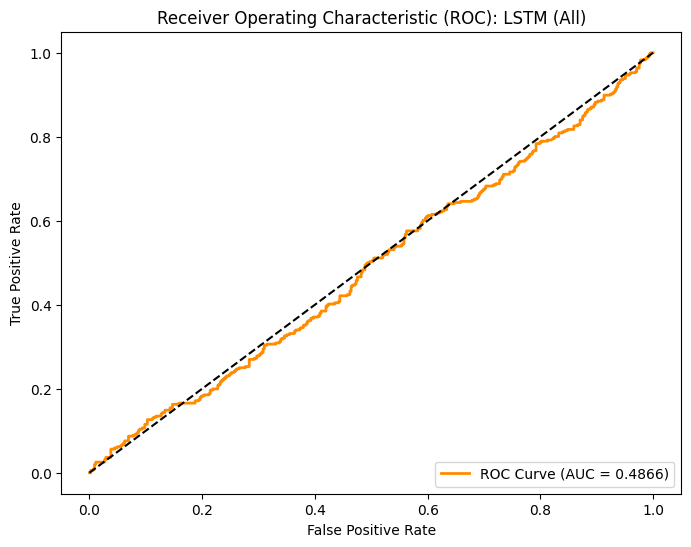


Investment Strategy Metrics for Test Period (LSTM Model 8.1):
RoI: -0.322533
Volatility: 0.177989
Sharpe Ratio: -0.685711
Sortino Ratio: -0.752126
Calmar Ratio: -0.264984

D-Ratio and related metrics for Test Period (LSTM Model 8.1):
D-Ratio for Full Period: 1.266797
D-Ratio for First Period: 1.035640
D-Ratio for Second Period: 1.223201

Error Metrics for Test Period (LSTM Model 8.1):
MSE: 0.250009
RMSE: 0.500009
MAE: 0.499921
MAPE: 50.257404%


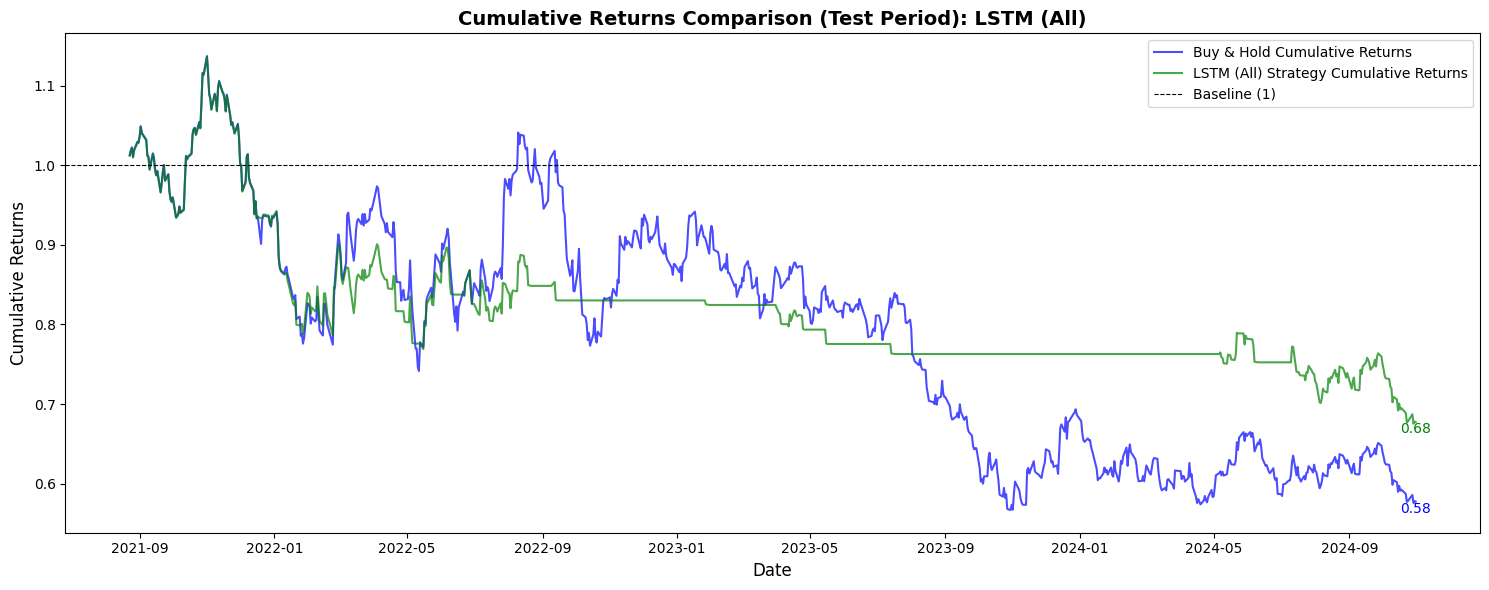

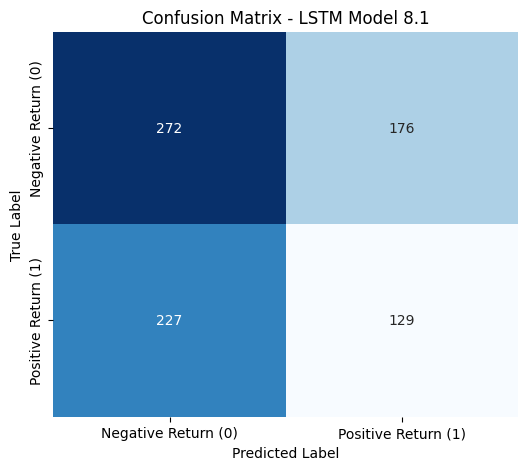

In [ ]:
# ============================================
# 8.1: LSTM with Explicit Lagged Features and TimeSeriesSplit Cross-Validation
# ============================================

# ============================================
# 1. Set Global Random Seed for Reproducibility
# ============================================

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"Global random seed set to {SEED}")

# ============================================
# 2. Data Preparation
# ============================================

# Define the original feature columns from 6.1
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5', 'EMA_12', 'EMA_26', 'EMA_50', 'MACD',
    'Bollinger_Upper', 'Bollinger_Lower', 'CCI_14', 'ATR_10', 'ADX_5', 'ADX_14',
    'RSI_5', 'RSI_14', 'Momentum_1', 'VIX', 'S&P500', 'Gold_Prices',
    'Interest_Rates', 'Oil_Prices', 'Copper_Futures', 'Natural_Gas_Prices',
    'VIX_lag_1w', 'VIX_lag_1m', 'S&P500_lag_1w', 'S&P500_lag_1m',
    'Gold_Prices_lag_1w', 'Gold_Prices_lag_1m', 'Interest_Rates_lag_1w', 'Interest_Rates_lag_1m',
    'Oil_Prices_lag_1w', 'Oil_Prices_lag_1m', 'Copper_Futures_lag_1w', 'Copper_Futures_lag_1m',
    'Natural_Gas_Prices_lag_1w', 'Natural_Gas_Prices_lag_1m'
]

# Create lagged features by shifting each feature by 1 day to avoid data leakage
lagged_features = [f"{feature}_lag_1" for feature in features]
for feature in features:
    data[feature + '_lag_1'] = data[feature].shift(1)

# Drop rows with NaN values introduced by lagging
data.dropna(inplace=True)

# Split the dataset into train, validation, and test sets
train_set = data.iloc[:train_size]
validation_set = data.iloc[train_size:train_size + validation_size]
test_set = data.iloc[train_size + validation_size:]

# Normalize the lagged features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set[lagged_features])
validation_scaled = scaler.transform(validation_set[lagged_features])
test_scaled = scaler.transform(test_set[lagged_features])

# Convert scaled data back to DataFrame for easy manipulation
train_scaled = pd.DataFrame(train_scaled, columns=lagged_features, index=train_set.index)
validation_scaled = pd.DataFrame(validation_scaled, columns=lagged_features, index=validation_set.index)
test_scaled = pd.DataFrame(test_scaled, columns=lagged_features, index=test_set.index)

# Define time step for sequence generation
time_step = 10

# Prepare the target variables
y_train_lstm_8_1 = train_set['Target'].values
y_validation_lstm_8_1 = validation_set['Target'].values
y_test_lstm_8_1 = test_set['Target'].values

# Reshape input to be 3D [samples, timesteps, features]
def create_sequences(data, target, time_step):
    X, y = [], []
    for i in range(len(data) - time_step + 1):
        X.append(data.iloc[i:(i + time_step)].values)
        y.append(target[i + time_step - 1])
    return np.array(X), np.array(y)

# Generate sequences for training, validation, and testing
X_train_lstm_8_1, y_train_lstm_8_1 = create_sequences(train_scaled, y_train_lstm_8_1, time_step)
X_validation_lstm_8_1, y_validation_lstm_8_1 = create_sequences(validation_scaled, y_validation_lstm_8_1, time_step)
X_test_lstm_8_1, y_test_lstm_8_1 = create_sequences(test_scaled, y_test_lstm_8_1, time_step)

# Combine training and validation sets for final training
X_train_full_lstm_8_1 = np.concatenate([X_train_lstm_8_1, X_validation_lstm_8_1], axis=0)
y_train_full_lstm_8_1 = np.concatenate([y_train_lstm_8_1, y_validation_lstm_8_1], axis=0)

# Update input shape
input_shape = (X_train_full_lstm_8_1.shape[1], X_train_full_lstm_8_1.shape[2])

# ============================================
# 3. Define and Tune the LSTM Model using TimeSeriesSplit
# ============================================

# Define the LSTM model for hyperparameter tuning
def create_lstm_model_8_1(units, activation, dropout_rate, optimizer):
    initializer = GlorotUniform(seed=SEED)
    inputs = Input(shape=input_shape)
    x = LSTM(units=units, activation=activation, kernel_initializer=initializer)(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid', kernel_initializer=initializer)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Wrap the model using KerasClassifier
model_lstm_8_1 = KerasClassifier(
    model=create_lstm_model_8_1,
    verbose=0
)

# Define the parameter grid for hyperparameter tuning
param_dist_lstm_8_1 = {
    'model__units': [32, 64, 96, 128],
    'model__activation': ['tanh', 'relu', 'sigmoid'],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Initialize RandomizedSearchCV
random_search_lstm_8_1 = RandomizedSearchCV(
    estimator=model_lstm_8_1,
    param_distributions=param_dist_lstm_8_1,
    n_iter=100,
    scoring='neg_log_loss',
    cv=tscv,
    verbose=1,
    random_state=SEED,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search_result_lstm_8_1 = random_search_lstm_8_1.fit(X_train_full_lstm_8_1, y_train_full_lstm_8_1)

# Retrieve the best hyperparameters
best_params_lstm_8_1 = random_search_result_lstm_8_1.best_params_
print("\nBest Hyperparameters:")
print(f"Units: {best_params_lstm_8_1['model__units']}")
print(f"Activation: {best_params_lstm_8_1['model__activation']}")
print(f"Dropout Rate: {best_params_lstm_8_1['model__dropout_rate']}")
print(f"Optimizer: {best_params_lstm_8_1['model__optimizer']}")
print(f"Batch Size: {best_params_lstm_8_1['batch_size']}")
print(f"Epochs: {best_params_lstm_8_1['epochs']}")

# Best estimator
best_estimator_lstm_8_1 = random_search_result_lstm_8_1.best_estimator_

# ============================================
# 5. Predictions and Metrics
# ============================================

# Make predictions
y_pred_proba_lstm_8_1 = best_estimator_lstm_8_1.predict_proba(X_test_lstm_8_1)

# Since predict_proba returns probabilities for both classes, get the probability of class 1
y_pred_proba_lstm_8_1 = y_pred_proba_lstm_8_1[:, 1]

# Convert probabilities to binary predictions
y_pred_class_lstm_8_1 = (y_pred_proba_lstm_8_1 >= 0.5).astype(int)

# Accuracy
accuracy_lstm_8_1 = accuracy_score(y_test_lstm_8_1, y_pred_class_lstm_8_1)
print(f"\nAccuracy (LSTM 8.1): {accuracy_lstm_8_1:.4f}")

# Confusion Matrix
cm_lstm_8_1 = confusion_matrix(y_test_lstm_8_1, y_pred_class_lstm_8_1)
print("\nConfusion Matrix - LSTM (All)")
print(cm_lstm_8_1)

# AUC and ROC Curve
fpr_lstm_8_1, tpr_lstm_8_1, _ = roc_curve(y_test_lstm_8_1, y_pred_proba_lstm_8_1)
roc_auc_lstm_8_1 = auc(fpr_lstm_8_1, tpr_lstm_8_1)
print(f"AUC (LSTM 8.1): {roc_auc_lstm_8_1:.4f}")

# Generate and print the classification report
report_lstm_8_1 = classification_report(y_test_lstm_8_1, y_pred_class_lstm_8_1, target_names=['Negative Return (0)', 'Positive Return (1)'])
print("\nClassification Report (LSTM Model 8.1):")
print(report_lstm_8_1)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm_8_1, tpr_lstm_8_1, label=f'ROC Curve (AUC = {roc_auc_lstm_8_1:.4f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC): LSTM (All)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# ============================================
# 6. Investment Performance Metrics
# ============================================

# Positions based on predicted class
positions_lstm_8_1 = pd.Series(y_pred_class_lstm_8_1, index=test_set.index[-len(y_pred_class_lstm_8_1):])

# Calculate strategy returns
strategy_returns_lstm_8_1 = test_set['ICLN_Return'][-len(y_pred_class_lstm_8_1):] * positions_lstm_8_1

# Apply transaction costs when positions change
transaction_cost_rate = 0.001
position_changes_lstm_8_1 = positions_lstm_8_1.diff().abs()
position_changes_lstm_8_1.iloc[0] = positions_lstm_8_1.iloc[0]
transaction_costs_lstm_8_1 = transaction_cost_rate * position_changes_lstm_8_1
net_strategy_returns_lstm_8_1 = strategy_returns_lstm_8_1 - transaction_costs_lstm_8_1

# Calculate cumulative returns
cumulative_returns_lstm_8_1 = np.exp(net_strategy_returns_lstm_8_1.cumsum())

# Buy-and-Hold Returns
returns_bh = test_set['ICLN_Return'][-len(y_pred_class_lstm_8_1):]
cumulative_returns_bh = np.exp(returns_bh.cumsum())

# Calculate D-Ratios
def get_d_ratio(bh_returns, strategy_returns, periods=2):
    d_ratios = np.zeros((1, periods + 1))
    # Full period D-Ratio
    d_ratios[0, 0] = (1 + strategy_returns).prod() / (1 + bh_returns).prod()
    # Divide into sub-periods for additional D-Ratios
    split_indices = np.array_split(np.arange(len(bh_returns)), periods)
    for i, indices in enumerate(split_indices):
        d_ratios[0, i + 1] = (1 + strategy_returns.iloc[indices]).prod() / (1 + bh_returns.iloc[indices]).prod()
    return d_ratios

d_ratios_lstm_8_1 = get_d_ratio(returns_bh, net_strategy_returns_lstm_8_1)

# Investment Metrics
roi_lstm_8_1 = np.exp(np.sum(net_strategy_returns_lstm_8_1)) - 1
volatility_lstm_8_1 = np.std(net_strategy_returns_lstm_8_1) * np.sqrt(252)
mean_return_lstm_8_1 = np.mean(net_strategy_returns_lstm_8_1) * 252
sharpe_ratio_lstm_8_1 = mean_return_lstm_8_1 / volatility_lstm_8_1

# Sortino Ratio
downside_returns_lstm_8_1 = net_strategy_returns_lstm_8_1[net_strategy_returns_lstm_8_1 < 0]
downside_volatility_lstm_8_1 = np.std(downside_returns_lstm_8_1) * np.sqrt(252)
sortino_ratio_lstm_8_1 = mean_return_lstm_8_1 / downside_volatility_lstm_8_1 if downside_volatility_lstm_8_1 > 0 else np.nan

# Calmar Ratio
max_drawdown_lstm_8_1 = (cumulative_returns_lstm_8_1.cummax() - cumulative_returns_lstm_8_1).max()
calmar_ratio_lstm_8_1 = mean_return_lstm_8_1 / max_drawdown_lstm_8_1 if max_drawdown_lstm_8_1 > 0 else np.nan

# Print Metrics
print("\nInvestment Strategy Metrics for Test Period (LSTM Model 8.1):")
print(f"RoI: {roi_lstm_8_1:.6f}")
print(f"Volatility: {volatility_lstm_8_1:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio_lstm_8_1:.6f}")
print(f"Sortino Ratio: {sortino_ratio_lstm_8_1:.6f}")
print(f"Calmar Ratio: {calmar_ratio_lstm_8_1:.6f}")

print("\nD-Ratio and related metrics for Test Period (LSTM Model 8.1):")
print(f"D-Ratio for Full Period: {d_ratios_lstm_8_1[0, 0]:.6f}")
print(f"D-Ratio for First Period: {d_ratios_lstm_8_1[0, 1]:.6f}")
print(f"D-Ratio for Second Period: {d_ratios_lstm_8_1[0, 2]:.6f}")

# ============================================
# 9. Error Metrics
# ============================================

mse_lstm_8_1 = mean_squared_error(y_test_lstm_8_1, y_pred_proba_lstm_8_1)
rmse_lstm_8_1 = np.sqrt(mse_lstm_8_1)
mae_lstm_8_1 = mean_absolute_error(y_test_lstm_8_1, y_pred_proba_lstm_8_1)

# MAPE Calculation
epsilon = 1e-6
valid_indices = np.abs(y_test_lstm_8_1) > epsilon
mape_lstm_8_1 = (
    np.mean(np.abs((y_test_lstm_8_1[valid_indices] - y_pred_proba_lstm_8_1[valid_indices]) / y_test_lstm_8_1[valid_indices])) * 100
    if valid_indices.any() else np.nan
)

print("\nError Metrics for Test Period (LSTM Model 8.1):")
print(f"MSE: {mse_lstm_8_1:.6f}")
print(f"RMSE: {rmse_lstm_8_1:.6f}")
print(f"MAE: {mae_lstm_8_1:.6f}")
print(f"MAPE: {mape_lstm_8_1:.6f}%")

# ============================================
# Plot Cumulative Returns
# ============================================

# Plot Cumulative Returns for LSTM 8.1
plt.figure(figsize=(15, 6))

# Plot Buy & Hold Cumulative Returns
plt.plot(cumulative_returns_bh.index, cumulative_returns_bh,
         label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7)

# Plot LSTM Strategy Cumulative Returns (8.1)
plt.plot(cumulative_returns_lstm_8_1.index, cumulative_returns_lstm_8_1,
         label='LSTM (All) Strategy Cumulative Returns', color='green', alpha=0.7)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8, label='Baseline (1)')

# Annotate the last value for Buy & Hold
last_value_bh = cumulative_returns_bh.iloc[-1]
last_date_bh = cumulative_returns_bh.index[-1]
plt.text(last_date_bh, last_value_bh, f'{last_value_bh:.2f}',
         color='blue', fontsize=10,
         verticalalignment='bottom' if last_value_bh >= 1 else 'top',
         horizontalalignment='center')

# Annotate the last value for LSTM Strategy (8.1)
last_value_lstm = cumulative_returns_lstm_8_1.iloc[-1]
last_date_lstm = cumulative_returns_lstm_8_1.index[-1]
plt.text(last_date_lstm, last_value_lstm, f'{last_value_lstm:.2f}',
         color='green', fontsize=10,
         verticalalignment='bottom' if last_value_lstm >= 1 else 'top',
         horizontalalignment='center')

# Customize titles and labels with specified font sizes and weights
plt.title('Cumulative Returns Comparison (Test Period): LSTM (All)', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)

# Customize legend
plt.legend(loc='best', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# ============================================
# Plot Confusion Matrix
# ============================================

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm_8_1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative Return (0)', 'Positive Return (1)'],
            yticklabels=['Negative Return (0)', 'Positive Return (1)'])
plt.title('Confusion Matrix - LSTM Model 8.1')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Global random seed set to 42

Best Hyperparameters Retrieved from 8.1:
Units: 32
Activation: sigmoid
Dropout Rate: 0.5
Optimizer: rmsprop
Batch Size: 64
Epochs: 30
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5129 - loss: 0.7270
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4913 - loss: 0.7157
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4891 - loss: 0.7130
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4958 - loss: 0.7067
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4898 - loss: 0.7080
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4981 - loss: 0.6995
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4987 - loss: 0.6991
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5090 - loss: 0.6971
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5055 - loss: 0.6957
Epoch 10/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5190 - loss: 0.

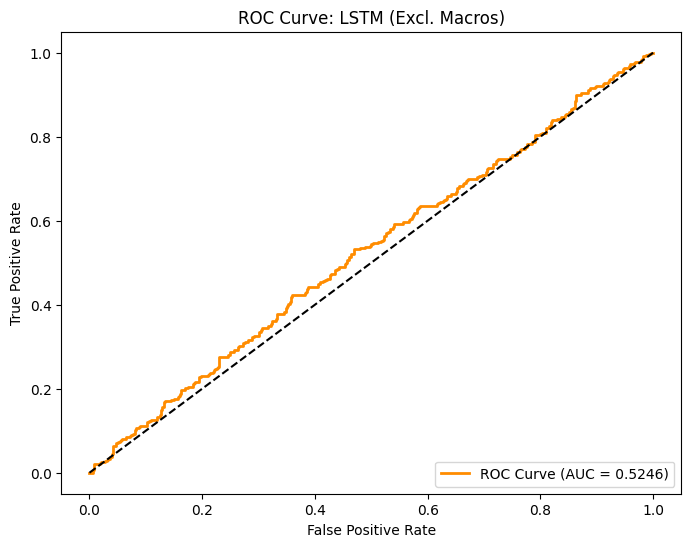


Investment Strategy Metrics for Test Period (LSTM Model 8.2):
RoI: 0.017660
Volatility: 0.194655
Sharpe Ratio: 0.028153
Sortino Ratio: 0.033375
Calmar Ratio: 0.018626

D-Ratio and related metrics for Test Period (LSTM Model 8.2):
D-Ratio for Full Period: 1.854840
D-Ratio for First Period: 1.488508
D-Ratio for Second Period: 1.246107

Error Metrics for Test Period (LSTM Model 8.2):
MSE: 0.249805
RMSE: 0.499805
MAE: 0.499791
MAPE: 50.035016%


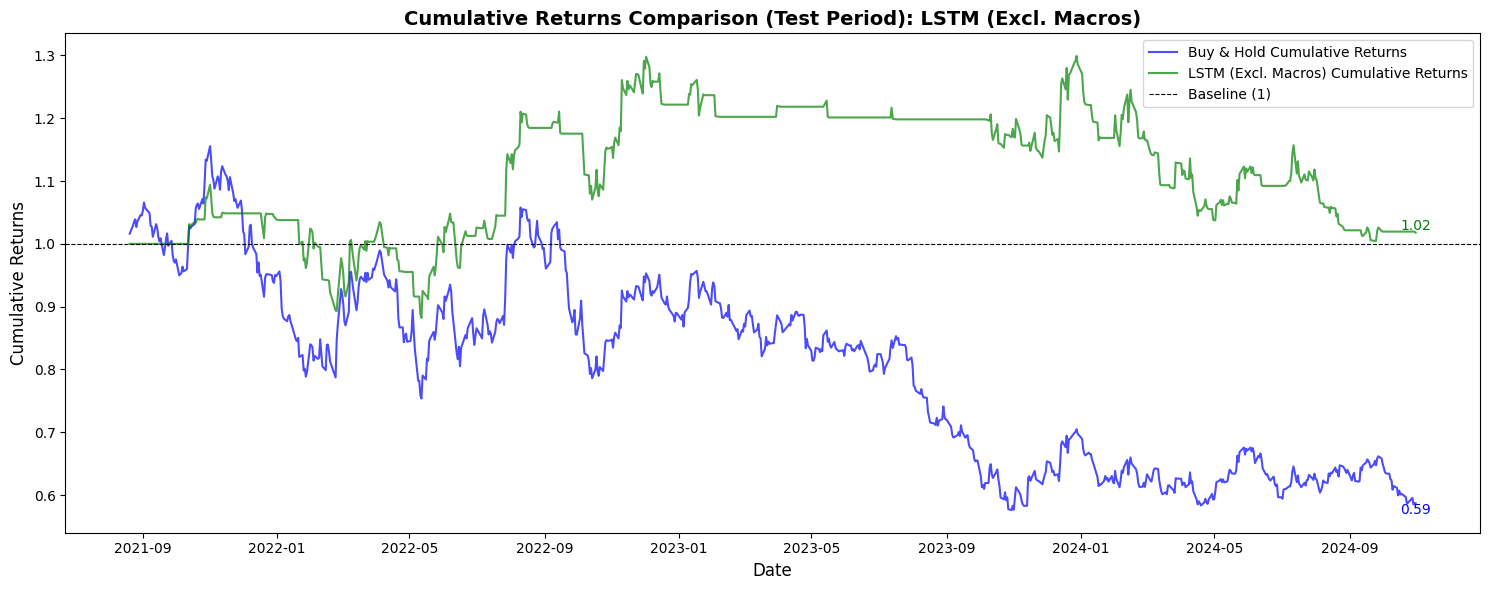

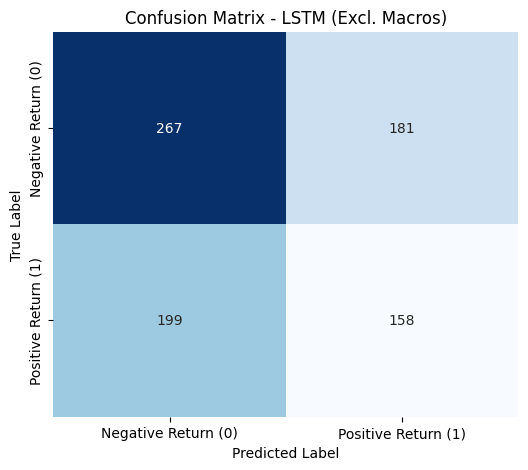

In [ ]:
# ============================================
# 8.2: LSTM Model Without Macroeconomic Indicators
# ============================================

# ============================================
# 1. Set Global Random Seed for Reproducibility
# ============================================

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.config.experimental.enable_op_determinism()

print(f"Global random seed set to {SEED}")

# ============================================
# 2. Define Features Excluding Macroeconomic Indicators
# ============================================

features_excluding_macro = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5', 'EMA_12', 'EMA_26', 'EMA_50',
    'MACD', 'Bollinger_Upper', 'Bollinger_Lower',
    'CCI_14', 'ATR_10', 'ADX_5', 'ADX_14',
    'RSI_5', 'RSI_14', 'Momentum_1'
]

# Create lagged features by shifting each feature by 1 day to avoid data leakage
lagged_features_excluding_macro = [f"{feature}_lag_1" for feature in features_excluding_macro]
for feature in features_excluding_macro:
    data[feature + '_lag_1'] = data[feature].shift(1)

# Drop rows with NaN values introduced by lagging
data.dropna(inplace=True)

# ============================================
# 3. Data Preparation
# ============================================

# Split the dataset into train, validation, and test sets
train_set = data.iloc[:train_size]
validation_set = data.iloc[train_size:train_size + validation_size]
test_set = data.iloc[train_size + validation_size:]

# Normalize the lagged features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set[lagged_features_excluding_macro])
validation_scaled = scaler.transform(validation_set[lagged_features_excluding_macro])
test_scaled = scaler.transform(test_set[lagged_features_excluding_macro])

# Convert scaled data back to DataFrame for easy manipulation
train_scaled = pd.DataFrame(train_scaled, columns=lagged_features_excluding_macro, index=train_set.index)
validation_scaled = pd.DataFrame(validation_scaled, columns=lagged_features_excluding_macro, index=validation_set.index)
test_scaled = pd.DataFrame(test_scaled, columns=lagged_features_excluding_macro, index=test_set.index)

# Define time step for sequence generation
time_step = 10

# Prepare the target variables
y_train_lstm_8_2 = train_set['Target'].values
y_validation_lstm_8_2 = validation_set['Target'].values
y_test_lstm_8_2 = test_set['Target'].values

# Reshape input to be 3D [samples, timesteps, features]
def create_sequences(data, target, time_step):
    X, y = [], []
    for i in range(len(data) - time_step + 1):
        X.append(data.iloc[i:(i + time_step)].values)
        y.append(target[i + time_step - 1])
    return np.array(X), np.array(y)

# Generate sequences for training, validation, and testing
X_train_lstm_8_2, y_train_lstm_8_2 = create_sequences(train_scaled, y_train_lstm_8_2, time_step)
X_validation_lstm_8_2, y_validation_lstm_8_2 = create_sequences(validation_scaled, y_validation_lstm_8_2, time_step)
X_test_lstm_8_2, y_test_lstm_8_2 = create_sequences(test_scaled, y_test_lstm_8_2, time_step)

# Combine training and validation sets for final training
X_train_full_lstm_8_2 = np.concatenate([X_train_lstm_8_2, X_validation_lstm_8_2], axis=0)
y_train_full_lstm_8_2 = np.concatenate([y_train_lstm_8_2, y_validation_lstm_8_2], axis=0)

# Update input shape
input_shape = (X_train_lstm_8_2.shape[1], X_train_lstm_8_2.shape[2])

# ============================================
# 4. Build and Train the LSTM Model Using Best Hyperparameters from 8.1
# ============================================

# Retrieve best hyperparameters from 8.1
best_params_lstm_8_1 = random_search_result_lstm_8_1.best_params_

# Map the hyperparameters to variables for later use
units = best_params_lstm_8_1['model__units']
activation = best_params_lstm_8_1['model__activation']
dropout_rate = best_params_lstm_8_1['model__dropout_rate']
optimizer = best_params_lstm_8_1['model__optimizer']
batch_size = best_params_lstm_8_1['batch_size']
epochs = best_params_lstm_8_1['epochs']

print("\nBest Hyperparameters Retrieved from 8.1:")
print(f"Units: {units}")
print(f"Activation: {activation}")
print(f"Dropout Rate: {dropout_rate}")
print(f"Optimizer: {optimizer}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")

# Define the LSTM model
def create_lstm_model_8_2(units, activation, dropout_rate, optimizer):
    initializer = GlorotUniform(seed=SEED)
    inputs = Input(shape=input_shape)
    x = LSTM(units=units, activation=activation, kernel_initializer=initializer)(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid', kernel_initializer=initializer)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build the model
best_model_lstm_8_2 = create_lstm_model_8_2(units, activation, dropout_rate, optimizer)

# Train the model
history_lstm_8_2 = best_model_lstm_8_2.fit(
    X_train_full_lstm_8_2, y_train_full_lstm_8_2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# ============================================
# 5. Predictions and Metrics
# ============================================

# Make predictions
y_pred_proba_lstm_8_2 = best_model_lstm_8_2.predict(X_test_lstm_8_2).flatten()

# Convert probabilities to binary predictions
y_pred_class_lstm_8_2 = (y_pred_proba_lstm_8_2 >= 0.5).astype(int)

# Calculate accuracy
accuracy_lstm_8_2 = accuracy_score(y_test_lstm_8_2, y_pred_class_lstm_8_2)
print(f"\nAccuracy (LSTM Model 8.2): {accuracy_lstm_8_2:.4f}")

# Confusion Matrix
cm_lstm_8_2 = confusion_matrix(y_test_lstm_8_2, y_pred_class_lstm_8_2)
print("\nConfusion Matrix - LSTM (Excl. Macros):")
print(cm_lstm_8_2)

# AUC and ROC Curve
fpr_lstm_8_2, tpr_lstm_8_2, _ = roc_curve(y_test_lstm_8_2, y_pred_proba_lstm_8_2)
roc_auc_lstm_8_2 = auc(fpr_lstm_8_2, tpr_lstm_8_2)
print(f"AUC (LSTM 8.2): {roc_auc_lstm_8_2:.4f}")

# Generate and print the classification report
report_lstm_8_2 = classification_report(y_test_lstm_8_2, y_pred_class_lstm_8_2, target_names=['Negative Return (0)', 'Positive Return (1)'])
print("\nClassification Report (LSTM Model 8.2):")
print(report_lstm_8_2)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm_8_2, tpr_lstm_8_2, label=f'ROC Curve (AUC = {roc_auc_lstm_8_2:.4f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('ROC Curve: LSTM (Excl. Macros)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# ============================================
# 6. Investment Performance Metrics
# ============================================

# Positions based on predicted class
positions_lstm_8_2 = pd.Series(y_pred_class_lstm_8_2, index=test_set.index[-len(y_pred_class_lstm_8_2):])

# Calculate strategy returns
strategy_returns_lstm_8_2 = test_set['ICLN_Return'][-len(y_pred_class_lstm_8_2):] * positions_lstm_8_2

# Apply transaction costs when positions change
transaction_cost_rate = 0.001
position_changes_lstm_8_2 = positions_lstm_8_2.diff().abs()
position_changes_lstm_8_2.iloc[0] = positions_lstm_8_2.iloc[0]
transaction_costs_lstm_8_2 = transaction_cost_rate * position_changes_lstm_8_2
net_strategy_returns_lstm_8_2 = strategy_returns_lstm_8_2 - transaction_costs_lstm_8_2

# Calculate cumulative returns
cumulative_returns_lstm_8_2 = np.exp(net_strategy_returns_lstm_8_2.cumsum())

# Buy-and-Hold Returns
returns_bh = test_set['ICLN_Return'][-len(y_pred_class_lstm_8_2):]
cumulative_returns_bh = np.exp(returns_bh.cumsum())

# Calculate D-Ratios
def get_d_ratio(bh_returns, strategy_returns, periods=2):
    d_ratios = np.zeros((1, periods + 1))
    # Full period D-Ratio
    d_ratios[0, 0] = (1 + strategy_returns).prod() / (1 + bh_returns).prod()
    # Divide into sub-periods for additional D-Ratios
    split_indices = np.array_split(np.arange(len(bh_returns)), periods)
    for i, indices in enumerate(split_indices):
        d_ratios[0, i + 1] = (1 + strategy_returns.iloc[indices]).prod() / (1 + bh_returns.iloc[indices]).prod()
    return d_ratios

d_ratios_lstm_8_2 = get_d_ratio(returns_bh, net_strategy_returns_lstm_8_2)

# Investment Metrics
roi_lstm_8_2 = np.exp(np.sum(net_strategy_returns_lstm_8_2)) - 1
volatility_lstm_8_2 = np.std(net_strategy_returns_lstm_8_2) * np.sqrt(252)
mean_return_lstm_8_2 = np.mean(net_strategy_returns_lstm_8_2) * 252
sharpe_ratio_lstm_8_2 = mean_return_lstm_8_2 / volatility_lstm_8_2

# Sortino Ratio
downside_returns_lstm_8_2 = net_strategy_returns_lstm_8_2[net_strategy_returns_lstm_8_2 < 0]
downside_volatility_lstm_8_2 = np.std(downside_returns_lstm_8_2) * np.sqrt(252)
sortino_ratio_lstm_8_2 = mean_return_lstm_8_2 / downside_volatility_lstm_8_2 if downside_volatility_lstm_8_2 > 0 else np.nan

# Calmar Ratio
max_drawdown_lstm_8_2 = (cumulative_returns_lstm_8_2.cummax() - cumulative_returns_lstm_8_2).max()
calmar_ratio_lstm_8_2 = mean_return_lstm_8_2 / max_drawdown_lstm_8_2 if max_drawdown_lstm_8_2 > 0 else np.nan

# Print Metrics
print("\nInvestment Strategy Metrics for Test Period (LSTM Model 8.2):")
print(f"RoI: {roi_lstm_8_2:.6f}")
print(f"Volatility: {volatility_lstm_8_2:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio_lstm_8_2:.6f}")
print(f"Sortino Ratio: {sortino_ratio_lstm_8_2:.6f}")
print(f"Calmar Ratio: {calmar_ratio_lstm_8_2:.6f}")

print("\nD-Ratio and related metrics for Test Period (LSTM Model 8.2):")
print(f"D-Ratio for Full Period: {d_ratios_lstm_8_2[0, 0]:.6f}")
print(f"D-Ratio for First Period: {d_ratios_lstm_8_2[0, 1]:.6f}")
print(f"D-Ratio for Second Period: {d_ratios_lstm_8_2[0, 2]:.6f}")

# ============================================
# 7. Error Metrics
# ============================================

mse_lstm_8_2 = mean_squared_error(y_test_lstm_8_2, y_pred_proba_lstm_8_2)
rmse_lstm_8_2 = np.sqrt(mse_lstm_8_2)
mae_lstm_8_2 = mean_absolute_error(y_test_lstm_8_2, y_pred_proba_lstm_8_2)

# MAPE Calculation (valid indices for non-zero values)
epsilon = 1e-6
valid_indices = np.abs(y_test_lstm_8_2) > epsilon
mape_lstm_8_2 = (
    np.mean(np.abs((y_test_lstm_8_2[valid_indices] - y_pred_proba_lstm_8_2[valid_indices]) / y_test_lstm_8_2[valid_indices])) * 100
    if valid_indices.any() else np.nan
)

print("\nError Metrics for Test Period (LSTM Model 8.2):")
print(f"MSE: {mse_lstm_8_2:.6f}")
print(f"RMSE: {rmse_lstm_8_2:.6f}")
print(f"MAE: {mae_lstm_8_2:.6f}")
print(f"MAPE: {mape_lstm_8_2:.6f}%")

# ============================================
# 8. Plot Cumulative Returns
# ============================================

# Plot Cumulative Returns for LSTM Model 8.2 - Excluding Macro Indicators
plt.figure(figsize=(15, 6))

# Plot Buy & Hold Cumulative Returns
plt.plot(
    cumulative_returns_bh.index, cumulative_returns_bh,
    label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7
)

# Plot LSTM Strategy Cumulative Returns (8.2 - Excluding Macro Indicators)
plt.plot(
    cumulative_returns_lstm_8_2.index, cumulative_returns_lstm_8_2,
    label='LSTM (Excl. Macros) Cumulative Returns', color='green', alpha=0.7
)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8, label='Baseline (1)')

# Annotate the last value for Buy & Hold
last_value_bh = cumulative_returns_bh.iloc[-1]
last_date_bh = cumulative_returns_bh.index[-1]
plt.text(
    last_date_bh, last_value_bh, f'{last_value_bh:.2f}',
    color='blue', fontsize=10,
    verticalalignment='bottom' if last_value_bh >= 1 else 'top',
    horizontalalignment='center'
)

# Annotate the last value for LSTM Strategy (8.2)
last_value_lstm = cumulative_returns_lstm_8_2.iloc[-1]
last_date_lstm = cumulative_returns_lstm_8_2.index[-1]
plt.text(
    last_date_lstm, last_value_lstm, f'{last_value_lstm:.2f}',
    color='green', fontsize=10,
    verticalalignment='bottom' if last_value_lstm >= 1 else 'top',
    horizontalalignment='center'
)

# Customize titles and labels with specified font sizes and weights
plt.title(
    'Cumulative Returns Comparison (Test Period): LSTM (Excl. Macros)',
    fontsize=14, weight='bold'
)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)

# Customize legend
plt.legend(loc='best', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


# ============================================
# 9. Plot Confusion Matrix
# ============================================

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_lstm_8_2, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Negative Return (0)', 'Positive Return (1)'],
    yticklabels=['Negative Return (0)', 'Positive Return (1)']
)
plt.title('Confusion Matrix - LSTM (Excl. Macros)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



Combined Features (Lagged Non-Macro + Overlap Features):
['Bollinger_Lower_lag_1', 'Interest_Rates_lag_1m_lag_1', 'Volume_lag_1', 'Momentum_1_lag_1', 'ADX_14_lag_1', 'Interest_Rates_lag_1w_lag_1', 'Open_lag_1', 'ATR_10_lag_1', 'VIX_lag_1', 'Low_lag_1', 'MACD_lag_1', 'Close_lag_1', 'VIX_lag_1w_lag_1', 'EMA_12_lag_1', 'CCI_14_lag_1', 'Natural_Gas_Prices_lag_1m_lag_1', 'Bollinger_Upper_lag_1', 'SMA_5_lag_1', 'RSI_14_lag_1', 'Oil_Prices_lag_1', 'High_lag_1', 'EMA_26_lag_1', 'RSI_5_lag_1', 'EMA_50_lag_1', 'ADX_5_lag_1']
Shape of X_train_seq_8_3: (3268, 10, 25)
Shape of y_train_seq_8_3: (3268,)
Shape of X_test_seq_8_3: (805, 10, 25)
Shape of y_test_seq_8_3: (805,)

Best Hyperparameters Retrieved from 8.1:
Units: 32
Activation: sigmoid
Dropout Rate: 0.5
Optimizer: rmsprop
Batch Size: 64
Epochs: 30
Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5055 - loss: 0.7185
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4886 - loss: 0.7066
Epoch 3/30
52/52 ━━━━━━━━━━

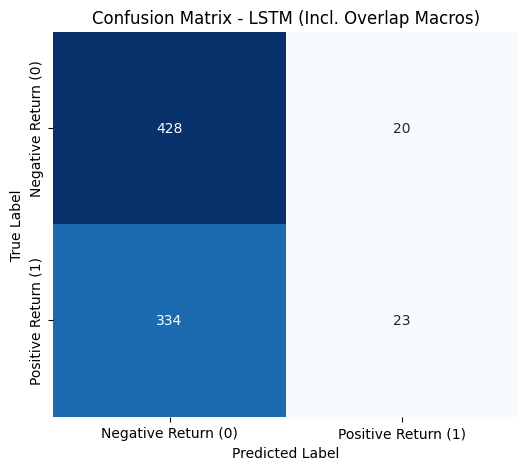


Investment Strategy Metrics for Test Period (Model 8.3):
RoI: 0.212501
Volatility: 0.085274
Sharpe Ratio: 0.707355
Sortino Ratio: 0.394259
Calmar Ratio: 0.833407

D-Ratio and related metrics for Test Period (Model 8.3):
D-Ratio for Full Period: 2.320268
D-Ratio for First Period: 1.521218
D-Ratio for Second Period: 1.525270

Error Metrics for Test Period (Model 8.3):
MSE: 0.249411
RMSE: 0.499411
MAE: 0.499383
MAPE: 50.452639%


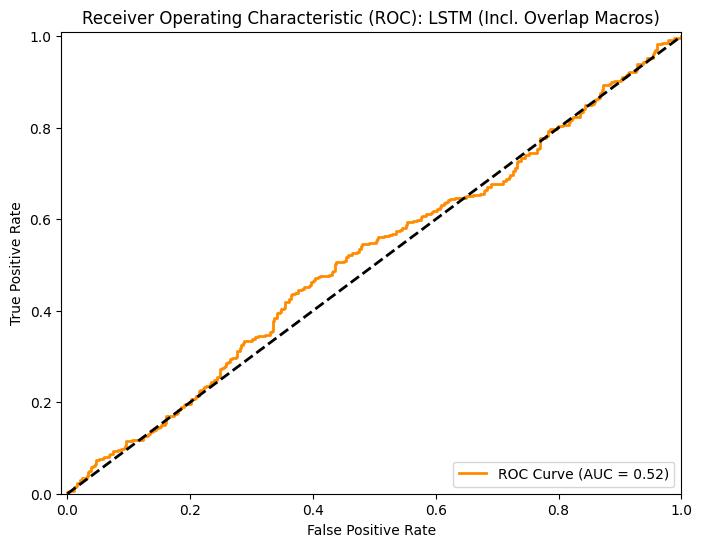

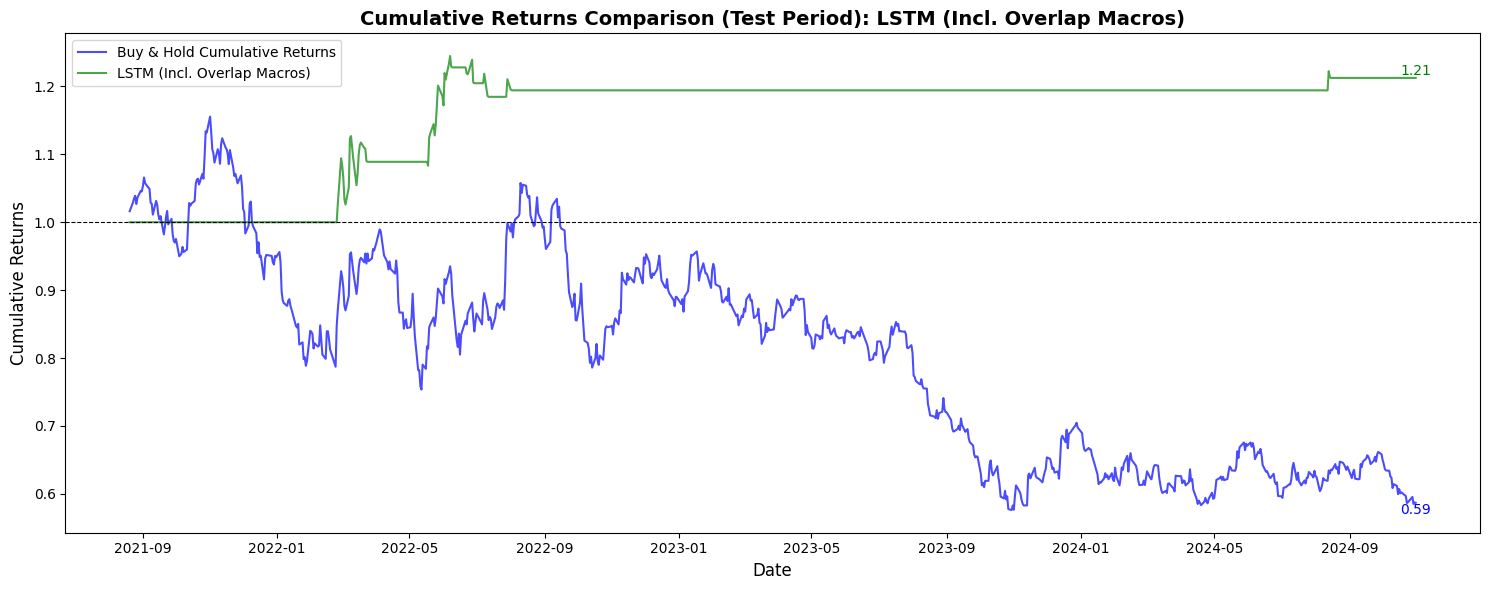

In [ ]:
# ============================================
# 8.3: LSTM Model With Overlap Features
# ============================================

# ============================================
# 1. Define Combined Features: Lagged Non-Macro + Overlap Features
# ============================================

# Assuming 'lagged_features_excluding_macro' is already defined in 8.2
# And 'overlap_features' is defined based on your previous SHAP analysis

# Combine lagged non-macro features with overlap features
# Remove duplicates in case of overlap
combined_features_lstm_8_3 = list(set(lagged_features_excluding_macro + overlap_features))

print("\nCombined Features (Lagged Non-Macro + Overlap Features):")
print(combined_features_lstm_8_3)

# ============================================
# 2. Data Preparation
# ============================================

# Ensure that all features in 'combined_features_lstm_8_3' exist in the data
missing_features = [feature for feature in combined_features_lstm_8_3 if feature not in data.columns]
if missing_features:
    print(f"The following features are missing in the data: {missing_features}")
    # Handle missing features accordingly, perhaps by excluding them or checking for typos
    # For now, we'll remove them from the combined features list
    combined_features_lstm_8_3 = [feature for feature in combined_features_lstm_8_3 if feature in data.columns]

# Handle missing values before splitting the data
# Drop rows with NaN values in the combined features or 'Target'
data_cleaned = data.dropna(subset=combined_features_lstm_8_3 + ['Target']).copy()

# Note: Since we're dropping rows, we need to adjust train_size and validation_size accordingly
# Calculate the adjusted train_size and validation_size based on the cleaned data
total_rows = len(data_cleaned)
train_size_adjusted = int(train_size / len(data) * total_rows)
validation_size_adjusted = int(validation_size / len(data) * total_rows)

# Split the dataset into train, validation, and test sets using the adjusted sizes
train_set = data_cleaned.iloc[:train_size_adjusted]
validation_set = data_cleaned.iloc[train_size_adjusted:train_size_adjusted + validation_size_adjusted]
test_set = data_cleaned.iloc[train_size_adjusted + validation_size_adjusted:]

# Prepare the datasets
X_train_combined = train_set[combined_features_lstm_8_3]
y_train_combined = train_set['Target']

X_validation_combined = validation_set[combined_features_lstm_8_3]
y_validation_combined = validation_set['Target']

X_test_combined = test_set[combined_features_lstm_8_3]
y_test_combined = test_set['Target']

# Combine training and validation sets for final training
X_train_full_combined = pd.concat([X_train_combined, X_validation_combined])
y_train_full_combined = pd.concat([y_train_combined, y_validation_combined])

# Reset indices to ensure proper alignment
X_train_full_combined.reset_index(drop=True, inplace=True)
y_train_full_combined.reset_index(drop=True, inplace=True)
X_test_combined.reset_index(drop=True, inplace=True)
y_test_combined.reset_index(drop=True, inplace=True)

# ============================================
# 3. Normalize the Data
# ============================================

scaler = MinMaxScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full_combined)
X_test_scaled = scaler.transform(X_test_combined)

# ============================================
# 4. Create Sequences for LSTM
# ============================================

time_steps = 10

def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps + 1):
        X.append(data[i:(i + time_steps), :])
        y.append(target.iloc[i + time_steps - 1])
    return np.array(X), np.array(y)

X_train_seq_8_3, y_train_seq_8_3 = create_sequences(
    X_train_full_scaled, y_train_full_combined, time_steps
)
X_test_seq_8_3, y_test_seq_8_3 = create_sequences(X_test_scaled, y_test_combined, time_steps)

# Debug: Check shapes
print(f"Shape of X_train_seq_8_3: {X_train_seq_8_3.shape}")
print(f"Shape of y_train_seq_8_3: {y_train_seq_8_3.shape}")
print(f"Shape of X_test_seq_8_3: {X_test_seq_8_3.shape}")
print(f"Shape of y_test_seq_8_3: {y_test_seq_8_3.shape}")

# Update input shape
input_shape = (X_train_seq_8_3.shape[1], X_train_seq_8_3.shape[2])

# ============================================
# 5. Define and Train the LSTM Model
# ============================================

def create_lstm_model_8_3(units, activation, dropout_rate, optimizer):
    initializer = GlorotUniform(seed=SEED)
    inputs = Input(shape=input_shape)
    x = LSTM(units=units, activation=activation, kernel_initializer=initializer)(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid', kernel_initializer=initializer)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Retrieve best hyperparameters from 8.1
best_params_lstm_8_1 = random_search_result_lstm_8_1.best_params_

# Map the hyperparameters to variables for later use
units = best_params_lstm_8_1['model__units']
activation = best_params_lstm_8_1['model__activation']
dropout_rate = best_params_lstm_8_1['model__dropout_rate']
optimizer = best_params_lstm_8_1['model__optimizer']
batch_size = best_params_lstm_8_1['batch_size']
epochs = best_params_lstm_8_1['epochs']

print("\nBest Hyperparameters Retrieved from 8.1:")
print(f"Units: {units}")
print(f"Activation: {activation}")
print(f"Dropout Rate: {dropout_rate}")
print(f"Optimizer: {optimizer}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")


# Build the model
best_model_lstm_8_3 = create_lstm_model_8_3(units, activation, dropout_rate, optimizer)

# Train the model
history_lstm_8_3 = best_model_lstm_8_3.fit(
    X_train_seq_8_3, y_train_seq_8_3,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# ============================================
# 6. Predictions and Metrics for Model 8.3
# ============================================

# Make predictions
y_pred_proba_lstm_8_3 = best_model_lstm_8_3.predict(X_test_seq_8_3).flatten()
y_pred_class_lstm_8_3 = (y_pred_proba_lstm_8_3 >= 0.5).astype(int)

# Classification Metrics
accuracy_lstm_8_3 = accuracy_score(y_test_seq_8_3, y_pred_class_lstm_8_3)
roc_auc_lstm_8_3 = roc_auc_score(y_test_seq_8_3, y_pred_proba_lstm_8_3)

print(f"\nAccuracy (Model 8.3): {accuracy_lstm_8_3:.4f}")
print(f"ROC AUC (Model 8.3): {roc_auc_lstm_8_3:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_seq_8_3, y_pred_class_lstm_8_3))

# Confusion Matrix
cm_lstm_8_3 = confusion_matrix(y_test_seq_8_3, y_pred_class_lstm_8_3)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_lstm_8_3, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Negative Return (0)', 'Positive Return (1)'],
    yticklabels=['Negative Return (0)', 'Positive Return (1)']
)
plt.title('Confusion Matrix - LSTM (Incl. Overlap Macros)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ============================================
# 7. Investment Performance Metrics for Model 8.3
# ============================================

# Positions based on predicted class
positions_lstm_8_3 = pd.Series(y_pred_class_lstm_8_3, index=test_set.index[-len(y_pred_class_lstm_8_3):])

# Align positions and returns
strategy_returns_lstm_8_3 = test_set['ICLN_Return'][-len(y_pred_class_lstm_8_3):] * positions_lstm_8_3

# Transaction costs for position changes
transaction_cost_rate = 0.001
position_changes_lstm_8_3 = positions_lstm_8_3.diff().abs()
position_changes_lstm_8_3.iloc[0] = positions_lstm_8_3.iloc[0]
transaction_costs_lstm_8_3 = transaction_cost_rate * position_changes_lstm_8_3
net_strategy_returns_lstm_8_3 = strategy_returns_lstm_8_3 - transaction_costs_lstm_8_3

# Calculate cumulative returns
cumulative_returns_lstm_8_3 = np.exp(net_strategy_returns_lstm_8_3.cumsum())

# Buy-and-Hold Returns
returns_bh = test_set['ICLN_Return'][-len(y_pred_class_lstm_8_3):]
cumulative_returns_bh = np.exp(returns_bh.cumsum())

# Calculate Investment Metrics
roi_lstm_8_3 = np.exp(np.sum(net_strategy_returns_lstm_8_3)) - 1
volatility_lstm_8_3 = np.std(net_strategy_returns_lstm_8_3) * np.sqrt(252)
mean_return_lstm_8_3 = np.mean(net_strategy_returns_lstm_8_3) * 252
sharpe_ratio_lstm_8_3 = mean_return_lstm_8_3 / volatility_lstm_8_3

# Sortino Ratio
downside_returns_lstm_8_3 = net_strategy_returns_lstm_8_3[net_strategy_returns_lstm_8_3 < 0]
downside_volatility_lstm_8_3 = np.std(downside_returns_lstm_8_3) * np.sqrt(252)
sortino_ratio_lstm_8_3 = mean_return_lstm_8_3 / downside_volatility_lstm_8_3 if downside_volatility_lstm_8_3 > 0 else np.nan

# Calmar Ratio
max_drawdown_lstm_8_3 = (cumulative_returns_lstm_8_3.cummax() - cumulative_returns_lstm_8_3).max()
calmar_ratio_lstm_8_3 = mean_return_lstm_8_3 / max_drawdown_lstm_8_3 if max_drawdown_lstm_8_3 > 0 else np.nan

# ============================================
# 8. D-Ratio Calculation for Model 8.3
# ============================================

# Define D-Ratio function if not already defined
def get_d_ratio(bh_returns, strategy_returns, periods=2):
    d_ratios = np.zeros((1, periods + 1))
    # Full period D-Ratio
    d_ratios[0, 0] = (1 + strategy_returns).prod() / (1 + bh_returns).prod()
    # Divide into sub-periods for additional D-Ratios
    split_indices = np.array_split(np.arange(len(bh_returns)), periods)
    for i, indices in enumerate(split_indices):
        d_ratios[0, i + 1] = (1 + strategy_returns.iloc[indices]).prod() / (1 + bh_returns.iloc[indices]).prod()
    return d_ratios

# Calculate D-Ratios for Model 8.3
d_ratios_lstm_8_3 = get_d_ratio(returns_bh, net_strategy_returns_lstm_8_3)

# Print Investment Metrics including D-Ratios
print("\nInvestment Strategy Metrics for Test Period (Model 8.3):")
print(f"RoI: {roi_lstm_8_3:.6f}")
print(f"Volatility: {volatility_lstm_8_3:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio_lstm_8_3:.6f}")
print(f"Sortino Ratio: {sortino_ratio_lstm_8_3:.6f}")
print(f"Calmar Ratio: {calmar_ratio_lstm_8_3:.6f}")

print("\nD-Ratio and related metrics for Test Period (Model 8.3):")
print(f"D-Ratio for Full Period: {d_ratios_lstm_8_3[0, 0]:.6f}")
print(f"D-Ratio for First Period: {d_ratios_lstm_8_3[0, 1]:.6f}")
print(f"D-Ratio for Second Period: {d_ratios_lstm_8_3[0, 2]:.6f}")

# ============================================
# 9. Error Metrics for Model 8.3
# ============================================

# Calculate error metrics
mse_lstm_8_3 = mean_squared_error(y_test_seq_8_3, y_pred_proba_lstm_8_3)
rmse_lstm_8_3 = np.sqrt(mse_lstm_8_3)
mae_lstm_8_3 = mean_absolute_error(y_test_seq_8_3, y_pred_proba_lstm_8_3)

# MAPE Calculation
epsilon = 1e-6
valid_indices = np.abs(y_test_seq_8_3) > epsilon
mape_lstm_8_3 = (
    np.mean(
        np.abs((y_test_seq_8_3[valid_indices] - y_pred_proba_lstm_8_3[valid_indices]) / y_test_seq_8_3[valid_indices])
    ) * 100
    if valid_indices.any()
    else np.nan
)

# Print Error Metrics
print("\nError Metrics for Test Period (Model 8.3):")
print(f"MSE: {mse_lstm_8_3:.6f}")
print(f"RMSE: {rmse_lstm_8_3:.6f}")
print(f"MAE: {mae_lstm_8_3:.6f}")
print(f"MAPE: {mape_lstm_8_3:.6f}%")

# ============================================
# 10: ROC Curve - Model 8.3
# ============================================

# Compute ROC curve and ROC area
fpr_lstm_8_3, tpr_lstm_8_3, _ = roc_curve(y_test_seq_8_3, y_pred_proba_lstm_8_3)
roc_auc_lstm_8_3 = auc(fpr_lstm_8_3, tpr_lstm_8_3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm_8_3, tpr_lstm_8_3, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_lstm_8_3:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC): LSTM (Incl. Overlap Macros)')
plt.legend(loc='lower right')
plt.show()


# ============================================
# 11. Cumulative Returns Plot
# ============================================

# Plot Cumulative Returns for Model 8.3
plt.figure(figsize=(15, 6))

# Plot Buy & Hold Cumulative Returns
plt.plot(
    cumulative_returns_bh.index, cumulative_returns_bh,
    label='Buy & Hold Cumulative Returns', color='blue', alpha=0.7
)

# Plot LSTM Strategy Cumulative Returns (Model 8.3)
plt.plot(
    cumulative_returns_lstm_8_3.index, cumulative_returns_lstm_8_3,
    label='LSTM (Incl. Overlap Macros)', color='green', alpha=0.7
)

# Add horizontal line at y=1 for reference
plt.axhline(1, color='black', linestyle='--', linewidth=0.8)

# Annotate the last value for Buy & Hold
last_value_bh = cumulative_returns_bh.iloc[-1]
last_date_bh = cumulative_returns_bh.index[-1]
plt.text(
    last_date_bh, last_value_bh, f'{last_value_bh:.2f}',
    color='blue', fontsize=10,
    verticalalignment='bottom' if last_value_bh >= 1 else 'top',
    horizontalalignment='center'
)

# Annotate the last value for LSTM Strategy (Model 8.3)
last_value_lstm = cumulative_returns_lstm_8_3.iloc[-1]
last_date_lstm = cumulative_returns_lstm_8_3.index[-1]
plt.text(
    last_date_lstm, last_value_lstm, f'{last_value_lstm:.2f}',
    color='green', fontsize=10,
    verticalalignment='bottom' if last_value_lstm >= 1 else 'top',
    horizontalalignment='center'
)

# Customize titles and labels with specified font sizes and weights
plt.title('Cumulative Returns Comparison (Test Period): LSTM (Incl. Overlap Macros)', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)

# Customize legend
plt.legend(loc='best', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


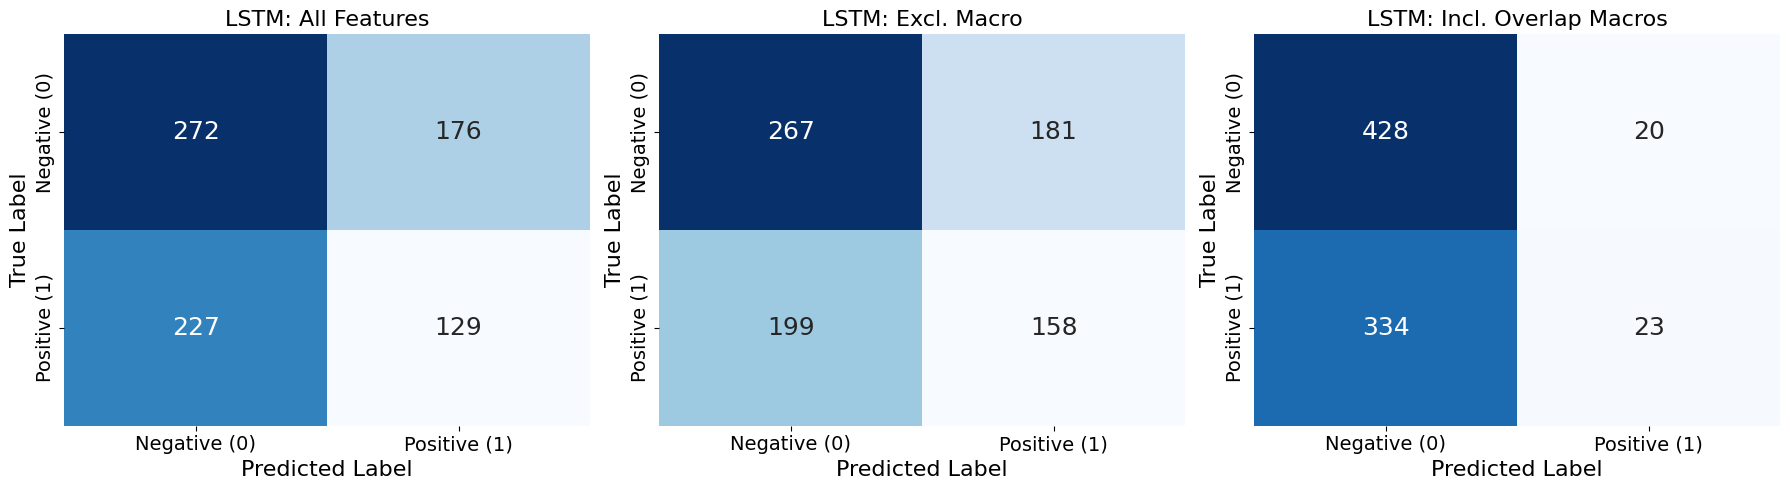

In [ ]:
# ============================================
# 8.4 Combined Confusion Matrices for LSTM Models
# ============================================

# List of confusion matrices and titles
confusion_matrices = [
    (cm_lstm_8_1, 'LSTM: All Features'),
    (cm_lstm_8_2, 'LSTM: Excl. Macro'),
    (cm_lstm_8_3, 'LSTM: Incl. Overlap Macros')
]

# Set up the matplotlib figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (cm, title) in zip(axes, confusion_matrices):
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        xticklabels=['Negative (0)', 'Positive (1)'],
        yticklabels=['Negative (0)', 'Positive (1)'],
        ax=ax,
        annot_kws={"size": 18}
    )

    # Set title with specific font size
    ax.set_title(title, fontsize=16)

    # Set x and y labels with specific font size
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)

    # Set tick labels font size
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('combined_confusion_matrices_lstm_8_1_8_2_8_3.png', dpi=300)
plt.show()


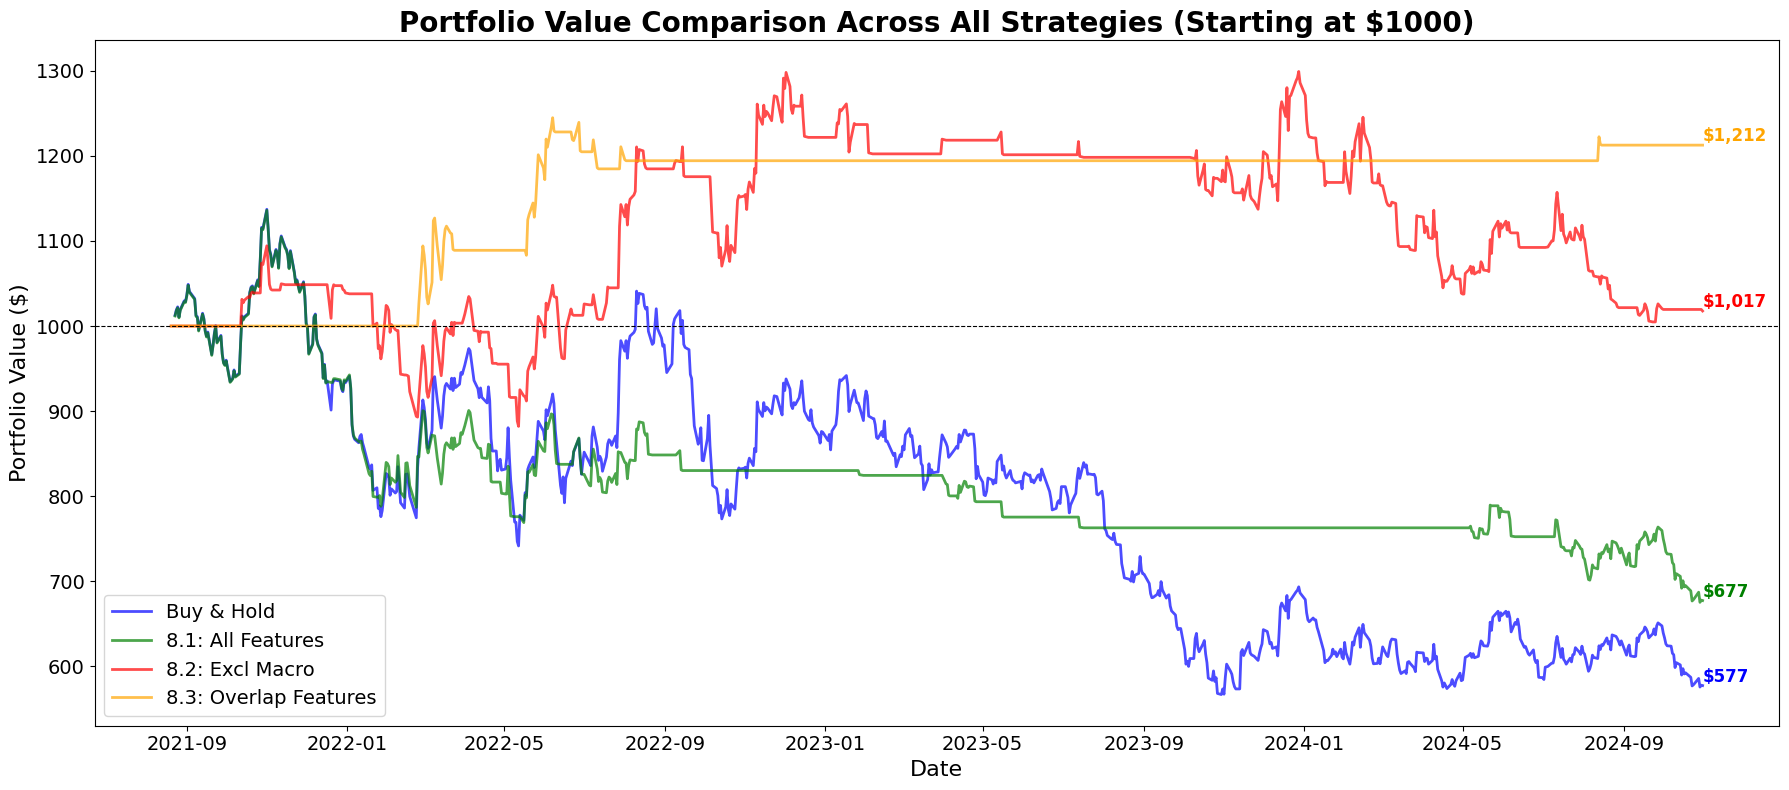


Summary Metrics Comparison for All Strategies:


Percentage of time 8.1: All Features outperformed Buy & Hold: 47.89%
Percentage of time 8.2: Excl Macro outperformed Buy & Hold: 94.65%
Percentage of time 8.3: Overlap Features outperformed Buy & Hold: 93.41%


In [ ]:
# ============================================
# 8.4 Summary for All LSTM Strategies
# ============================================

# Initial investment
initial_investment = 1000

# ============================================
# Calculate Cumulative Returns and Portfolio Values
# ============================================

# 2. Strategy 8.1 (All Features Including Macroeconomic Indicators)
portfolio_value_strategy_8_1 = initial_investment * cumulative_returns_lstm_8_1

# 3. Strategy 8.2 (Excluding Macroeconomic Indicators)
portfolio_value_strategy_8_2 = initial_investment * cumulative_returns_lstm_8_2

# 4. Strategy 8.3 (Lagged Non-Macro + Overlap Features)
portfolio_value_strategy_8_3 = initial_investment * cumulative_returns_lstm_8_3

# ============================================
# 9.4 Plot Portfolio Values Comparison Including New Models
# ============================================

plt.figure(figsize=(18, 8))

# Plot Buy & Hold Cumulative Returns
plt.plot(
    portfolio_value_bh.index, portfolio_value_bh,
    label='Buy & Hold', color='blue', alpha=0.7, linewidth=2
)

# Plot Strategy 8.1
plt.plot(
    portfolio_value_strategy_8_1.index, portfolio_value_strategy_8_1,
    label='8.1: All Features', color='green', alpha=0.7, linewidth=2
)

# Plot Strategy 8.2
plt.plot(
    portfolio_value_strategy_8_2.index, portfolio_value_strategy_8_2,
    label='8.2: Excl Macro', color='red', alpha=0.7, linewidth=2
)

# Plot Strategy 8.3
plt.plot(
    portfolio_value_strategy_8_3.index, portfolio_value_strategy_8_3,
    label='8.3: Overlap Features', color='orange', alpha=0.7, linewidth=2
)

# Adding text labels for the last value of each line with increased fontsize
plt.text(
    portfolio_value_bh.index[-1], portfolio_value_bh.iloc[-1],
    f'${int(portfolio_value_bh.iloc[-1]):,}',
    color='blue', fontsize=12, weight='bold', ha='left', va='bottom'
)
plt.text(
    portfolio_value_strategy_8_1.index[-1], portfolio_value_strategy_8_1.iloc[-1],
    f'${int(portfolio_value_strategy_8_1.iloc[-1]):,}',
    color='green', fontsize=12, weight='bold', ha='left', va='bottom'
)
plt.text(
    portfolio_value_strategy_8_2.index[-1], portfolio_value_strategy_8_2.iloc[-1],
    f'${int(portfolio_value_strategy_8_2.iloc[-1]):,}',
    color='red', fontsize=12, weight='bold', ha='left', va='bottom'
)
plt.text(
    portfolio_value_strategy_8_3.index[-1], portfolio_value_strategy_8_3.iloc[-1],
    f'${int(portfolio_value_strategy_8_3.iloc[-1]):,}',
    color='orange', fontsize=12, weight='bold', ha='left', va='bottom'
)

plt.title(
    'Portfolio Value Comparison Across All Strategies (Starting at $1000)',
    fontsize=20, weight='bold'
)
plt.axhline(initial_investment, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Portfolio Value ($)', fontsize=16)
plt.legend(loc='lower left', fontsize=14, bbox_to_anchor=(0, 0))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('portfolio_value_comparison_all_strategies.png', dpi=300)
plt.show()

# ============================================
# 9.4: Summary Metrics for All Strategies
# ============================================

# Create a dictionary for the summary table
summary_table_all = {
    "Metrics": [
        "Return on Investment",
        "Volatility",
        "Sharpe Ratio",
        "Sortino Ratio",
        "Calmar Ratio",
        "D-Ratio for Full Period",
        "D-Ratio for First Period",
        "D-Ratio for Second Period",
        "MSE",
        "RMSE",
        "MAE",
        "MAPE",
        "Accuracy"
    ],
    "Baseline (B&H)": [
        f"{metrics_bh['RoI'] * 100:.1f}%",
        f"{metrics_bh['Volatility'] * 100:.1f}%",
        f"{metrics_bh['Sharpe_Ratio']:.2f}",
        f"{metrics_bh['Sortino_Ratio']:.2f}",
        f"{metrics_bh['Calmar_Ratio']:.2f}",
        f"{d_ratios[0,0]:.6f}",
        f"{d_ratios[0,1]:.6f}",
        f"{d_ratios[0,2]:.6f}",
        "N.A",
        "N.A",
        "N.A",
        "N.A",
        "N.A"
    ],
    "8.1: All Features": [
        f"{roi_lstm_8_1 * 100:.1f}%",
        f"{volatility_lstm_8_1 * 100:.1f}%",
        f"{sharpe_ratio_lstm_8_1:.2f}",
        f"{sortino_ratio_lstm_8_1:.2f}",
        f"{calmar_ratio_lstm_8_1:.2f}",
        f"{d_ratios_lstm_8_1[0, 0]:.6f}",
        f"{d_ratios_lstm_8_1[0, 1]:.6f}",
        f"{d_ratios_lstm_8_1[0, 2]:.6f}",
        f"{mse_lstm_8_1:.6f}",
        f"{rmse_lstm_8_1:.6f}",
        f"{mae_lstm_8_1:.6f}",
        f"{mape_lstm_8_1:.2f}%",
        f"{accuracy_lstm_8_1 * 100:.2f}%"
    ],
    "8.2: Excl Macro": [
        f"{roi_lstm_8_2 * 100:.1f}%",
        f"{volatility_lstm_8_2 * 100:.1f}%",
        f"{sharpe_ratio_lstm_8_2:.2f}",
        f"{sortino_ratio_lstm_8_2:.2f}",
        f"{calmar_ratio_lstm_8_2:.2f}",
        f"{d_ratios_lstm_8_2[0, 0]:.6f}",
        f"{d_ratios_lstm_8_2[0, 1]:.6f}",
        f"{d_ratios_lstm_8_2[0, 2]:.6f}",
        f"{mse_lstm_8_2:.6f}",
        f"{rmse_lstm_8_2:.6f}",
        f"{mae_lstm_8_2:.6f}",
        f"{mape_lstm_8_2:.2f}%",
        f"{accuracy_lstm_8_2 * 100:.2f}%"
    ],
    "8.3: Overlap Features": [
        f"{roi_lstm_8_3 * 100:.1f}%",
        f"{volatility_lstm_8_3 * 100:.1f}%",
        f"{sharpe_ratio_lstm_8_3:.2f}",
        f"{sortino_ratio_lstm_8_3:.2f}",
        f"{calmar_ratio_lstm_8_3:.2f}",
        f"{d_ratios_lstm_8_3[0, 0]:.6f}",
        f"{d_ratios_lstm_8_3[0, 1]:.6f}",
        f"{d_ratios_lstm_8_3[0, 2]:.6f}",
        f"{mse_lstm_8_3:.6f}",
        f"{rmse_lstm_8_3:.6f}",
        f"{mae_lstm_8_3:.6f}",
        f"{mape_lstm_8_3:.2f}%",
        f"{accuracy_lstm_8_3 * 100:.2f}%"
    ],
}

# Convert the dictionary into a DataFrame
summary_df_all = pd.DataFrame(summary_table_all)

def style_summary_table(df):
    return df.style.set_properties(**{
        'font-size': '14px',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('font-size', '16px'), ('text-align', 'center')]}
    ])

# Display the summary table with enhanced styling
print("\nSummary Metrics Comparison for All Strategies:")
display(style_summary_table(summary_df_all))

# List of strategy portfolio values
strategy_values = [
    portfolio_value_strategy_8_1,
    portfolio_value_strategy_8_2,
    portfolio_value_strategy_8_3
]

# Corresponding strategy labels
strategy_labels = [
    "8.1: All Features",
    "8.2: Excl Macro",
    "8.3: Overlap Features"
]

# Function to calculate outperformance percentages
def calculate_outperformance_percentage(strategy_values, baseline_values, strategy_labels):
    """
    Calculate the percentage of time each strategy outperformed a baseline.

    Parameters:
        strategy_values (list of pd.Series): A list of portfolio value series for each strategy.
        baseline_values (pd.Series): The baseline portfolio value series (e.g., Buy & Hold).
        strategy_labels (list of str): Labels for the strategies for display purposes.

    Returns:
        dict: A dictionary with strategy labels as keys and outperformance percentages as values.
    """
    outperformance_results = {}

    for strategy_value, label in zip(strategy_values, strategy_labels):
        # Ensure indices are aligned
        aligned_strategy, aligned_baseline = strategy_value.align(baseline_values, join='inner')

        # Calculate whether the strategy outperformed the baseline at each time step
        outperform = aligned_strategy > aligned_baseline

        # Calculate the percentage of time outperformance occurred
        percent_outperform = (outperform.sum() / len(outperform)) * 100

        # Store results
        outperformance_results[label] = percent_outperform

    return outperformance_results

# Calculate the outperformance percentages
outperformance_percentages = calculate_outperformance_percentage(strategy_values, portfolio_value_bh, strategy_labels)

# Display the results
for label, percentage in outperformance_percentages.items():
    print(f"Percentage of time {label} outperformed Buy & Hold: {percentage:.2f}%")
